In [1]:
# !pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Successfully uninstalled transformers-4.35.2
Found existing installation: accelerate 0.25.0
Uninstalling accelerate-0.25.0:
  Successfully uninstalled accelerate-0.25.0
  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)


In [ ]:
!pip install -q datasets transformers

In [1]:
model_checkpoint = "D:\\work\\vit_training\\vit-base-patch16-224-in21k-finetuned-eurosat\\checkpoint-12886" # pre-trained model from which to fine-tune
batch_size = 16 # batch size for training and evaluatio


# model_checkpoint = 'google/vit-base-patch16-224-in21k'
# batch_size = 32 # batch size for training and evaluation
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [2]:
from datasets import load_dataset


dataset = load_dataset("imagefolder", data_dir="C:/Users/Pc/Downloads/face_dataset/img_align_celeba/", drop_labels=False)

# option 3: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
# dataset = load_dataset("cifar10")

d:\Anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 37657/37657 [00:00<00:00, 55909.23it/s] 


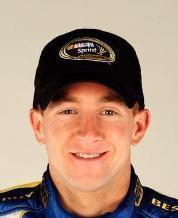

In [3]:
dataset["test"][1]['image']


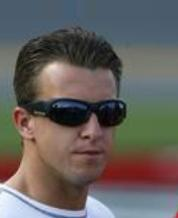

In [4]:
dataset["train"][1]['image']


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 164942
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 37657
    })
})

In [6]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1000]

'1739'

In [7]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [9]:
train_ds = dataset['train']
val_ds = dataset['test']

In [10]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 164942
})

In [11]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 37657
})

In [12]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


In [14]:
model_name = model_checkpoint.split("/")[-1]
print(model_name)

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

D:\work\vit_training\vit-base-patch16-224-in21k-finetuned-eurosat\checkpoint-12886


In [15]:
from datasets import load_metric

metric = load_metric("accuracy")

C:\Users\Pc\AppData\Local\Temp\ipykernel_11268\1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [16]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [17]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [19]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 10/12885 [00:19<5:01:49,  1.41s/it]

{'loss': 0.583, 'learning_rate': 3.878975950349108e-06, 'epoch': 0.0}


  0%|          | 20/12885 [00:32<4:48:24,  1.35s/it]

{'loss': 0.678, 'learning_rate': 7.757951900698216e-06, 'epoch': 0.01}


  0%|          | 30/12885 [00:46<4:48:42,  1.35s/it]

{'loss': 0.7736, 'learning_rate': 1.1636927851047324e-05, 'epoch': 0.01}


  0%|          | 40/12885 [00:59<4:48:31,  1.35s/it]

{'loss': 0.7121, 'learning_rate': 1.551590380139643e-05, 'epoch': 0.02}


  0%|          | 50/12885 [01:13<4:56:42,  1.39s/it]

{'loss': 0.7191, 'learning_rate': 1.9394879751745538e-05, 'epoch': 0.02}


  0%|          | 60/12885 [01:27<4:48:29,  1.35s/it]

{'loss': 0.6179, 'learning_rate': 2.3273855702094647e-05, 'epoch': 0.02}


  1%|          | 70/12885 [01:40<4:47:35,  1.35s/it]

{'loss': 0.5449, 'learning_rate': 2.7152831652443753e-05, 'epoch': 0.03}


  1%|          | 80/12885 [01:54<4:47:53,  1.35s/it]

{'loss': 0.5776, 'learning_rate': 3.103180760279286e-05, 'epoch': 0.03}


  1%|          | 90/12885 [02:08<5:06:39,  1.44s/it]

{'loss': 0.6168, 'learning_rate': 3.491078355314197e-05, 'epoch': 0.03}


  1%|          | 100/12885 [02:22<4:48:11,  1.35s/it]

{'loss': 0.6912, 'learning_rate': 3.8789759503491075e-05, 'epoch': 0.04}


  1%|          | 110/12885 [02:35<4:51:55,  1.37s/it]

{'loss': 0.5916, 'learning_rate': 4.266873545384019e-05, 'epoch': 0.04}


  1%|          | 120/12885 [02:49<4:44:34,  1.34s/it]

{'loss': 0.5822, 'learning_rate': 4.6547711404189294e-05, 'epoch': 0.05}


  1%|          | 130/12885 [03:03<4:55:38,  1.39s/it]

{'loss': 0.5992, 'learning_rate': 5.042668735453841e-05, 'epoch': 0.05}


  1%|          | 140/12885 [03:16<4:45:23,  1.34s/it]

{'loss': 0.651, 'learning_rate': 5.4305663304887507e-05, 'epoch': 0.05}


  1%|          | 150/12885 [03:30<4:51:52,  1.38s/it]

{'loss': 0.6609, 'learning_rate': 5.818463925523662e-05, 'epoch': 0.06}


  1%|          | 160/12885 [03:44<4:53:07,  1.38s/it]

{'loss': 0.6182, 'learning_rate': 6.206361520558573e-05, 'epoch': 0.06}


  1%|▏         | 170/12885 [03:58<4:45:08,  1.35s/it]

{'loss': 0.6397, 'learning_rate': 6.594259115593483e-05, 'epoch': 0.07}


  1%|▏         | 180/12885 [04:11<4:38:43,  1.32s/it]

{'loss': 0.4911, 'learning_rate': 6.982156710628394e-05, 'epoch': 0.07}


  1%|▏         | 190/12885 [04:25<4:39:34,  1.32s/it]

{'loss': 0.5068, 'learning_rate': 7.370054305663306e-05, 'epoch': 0.07}


  2%|▏         | 200/12885 [04:38<4:47:38,  1.36s/it]

{'loss': 0.6158, 'learning_rate': 7.757951900698215e-05, 'epoch': 0.08}


  2%|▏         | 210/12885 [04:52<4:42:40,  1.34s/it]

{'loss': 0.5947, 'learning_rate': 8.145849495733127e-05, 'epoch': 0.08}


  2%|▏         | 220/12885 [05:05<4:41:05,  1.33s/it]

{'loss': 0.6483, 'learning_rate': 8.533747090768038e-05, 'epoch': 0.09}


  2%|▏         | 230/12885 [05:18<4:37:31,  1.32s/it]

{'loss': 0.6362, 'learning_rate': 8.921644685802948e-05, 'epoch': 0.09}


  2%|▏         | 240/12885 [05:32<4:48:34,  1.37s/it]

{'loss': 0.5145, 'learning_rate': 9.309542280837859e-05, 'epoch': 0.09}


  2%|▏         | 250/12885 [05:45<4:38:35,  1.32s/it]

{'loss': 0.7261, 'learning_rate': 9.69743987587277e-05, 'epoch': 0.1}


  2%|▏         | 260/12885 [05:58<4:37:10,  1.32s/it]

{'loss': 0.6859, 'learning_rate': 0.00010085337470907681, 'epoch': 0.1}


  2%|▏         | 270/12885 [06:12<4:35:18,  1.31s/it]

{'loss': 0.5521, 'learning_rate': 0.00010473235065942592, 'epoch': 0.1}


  2%|▏         | 280/12885 [06:25<4:38:53,  1.33s/it]

{'loss': 0.643, 'learning_rate': 0.00010861132660977501, 'epoch': 0.11}


  2%|▏         | 290/12885 [06:38<4:34:25,  1.31s/it]

{'loss': 0.6129, 'learning_rate': 0.00011249030256012413, 'epoch': 0.11}


  2%|▏         | 300/12885 [06:51<4:32:02,  1.30s/it]

{'loss': 0.6448, 'learning_rate': 0.00011636927851047324, 'epoch': 0.12}


  2%|▏         | 310/12885 [07:05<4:37:00,  1.32s/it]

{'loss': 0.5792, 'learning_rate': 0.00012024825446082235, 'epoch': 0.12}


  2%|▏         | 320/12885 [07:18<4:39:07,  1.33s/it]

{'loss': 0.4735, 'learning_rate': 0.00012412723041117145, 'epoch': 0.12}


  3%|▎         | 330/12885 [07:31<4:38:28,  1.33s/it]

{'loss': 0.5043, 'learning_rate': 0.00012800620636152054, 'epoch': 0.13}


  3%|▎         | 340/12885 [07:45<4:40:52,  1.34s/it]

{'loss': 0.5734, 'learning_rate': 0.00013188518231186966, 'epoch': 0.13}


  3%|▎         | 350/12885 [07:58<4:37:16,  1.33s/it]

{'loss': 0.6115, 'learning_rate': 0.00013576415826221878, 'epoch': 0.14}


  3%|▎         | 360/12885 [08:12<4:38:51,  1.34s/it]

{'loss': 0.607, 'learning_rate': 0.00013964313421256788, 'epoch': 0.14}


  3%|▎         | 370/12885 [08:25<4:33:41,  1.31s/it]

{'loss': 0.5564, 'learning_rate': 0.000143522110162917, 'epoch': 0.14}


  3%|▎         | 380/12885 [08:38<4:34:55,  1.32s/it]

{'loss': 0.6254, 'learning_rate': 0.00014740108611326612, 'epoch': 0.15}


  3%|▎         | 390/12885 [08:51<4:37:39,  1.33s/it]

{'loss': 0.5624, 'learning_rate': 0.0001512800620636152, 'epoch': 0.15}


  3%|▎         | 400/12885 [09:04<4:33:47,  1.32s/it]

{'loss': 0.5562, 'learning_rate': 0.0001551590380139643, 'epoch': 0.16}


  3%|▎         | 410/12885 [09:18<4:31:35,  1.31s/it]

{'loss': 0.5656, 'learning_rate': 0.00015903801396431342, 'epoch': 0.16}


  3%|▎         | 420/12885 [09:31<4:30:32,  1.30s/it]

{'loss': 0.7069, 'learning_rate': 0.00016291698991466254, 'epoch': 0.16}


  3%|▎         | 430/12885 [09:44<4:32:05,  1.31s/it]

{'loss': 0.6574, 'learning_rate': 0.00016679596586501163, 'epoch': 0.17}


  3%|▎         | 440/12885 [09:57<4:30:48,  1.31s/it]

{'loss': 0.5697, 'learning_rate': 0.00017067494181536075, 'epoch': 0.17}


  3%|▎         | 450/12885 [10:10<4:29:39,  1.30s/it]

{'loss': 0.6064, 'learning_rate': 0.00017455391776570987, 'epoch': 0.17}


  4%|▎         | 460/12885 [10:23<4:30:01,  1.30s/it]

{'loss': 0.6373, 'learning_rate': 0.00017843289371605896, 'epoch': 0.18}


  4%|▎         | 470/12885 [10:37<4:30:58,  1.31s/it]

{'loss': 0.6011, 'learning_rate': 0.00018231186966640806, 'epoch': 0.18}


  4%|▎         | 480/12885 [10:50<4:29:30,  1.30s/it]

{'loss': 0.6085, 'learning_rate': 0.00018619084561675718, 'epoch': 0.19}


  4%|▍         | 490/12885 [11:03<4:30:38,  1.31s/it]

{'loss': 0.6033, 'learning_rate': 0.00019006982156710627, 'epoch': 0.19}


  4%|▍         | 500/12885 [11:16<4:29:01,  1.30s/it]

{'loss': 0.4781, 'learning_rate': 0.0001939487975174554, 'epoch': 0.19}


  4%|▍         | 510/12885 [11:29<4:29:07,  1.30s/it]

{'loss': 0.6679, 'learning_rate': 0.0001978277734678045, 'epoch': 0.2}


  4%|▍         | 520/12885 [11:42<4:28:45,  1.30s/it]

{'loss': 0.5538, 'learning_rate': 0.00020170674941815363, 'epoch': 0.2}


  4%|▍         | 530/12885 [11:55<4:28:20,  1.30s/it]

{'loss': 0.5859, 'learning_rate': 0.00020558572536850272, 'epoch': 0.21}


  4%|▍         | 540/12885 [12:09<4:27:59,  1.30s/it]

{'loss': 0.5903, 'learning_rate': 0.00020946470131885184, 'epoch': 0.21}


  4%|▍         | 550/12885 [12:22<4:28:02,  1.30s/it]

{'loss': 0.4796, 'learning_rate': 0.00021334367726920093, 'epoch': 0.21}


  4%|▍         | 560/12885 [12:35<4:27:29,  1.30s/it]

{'loss': 0.6692, 'learning_rate': 0.00021722265321955003, 'epoch': 0.22}


  4%|▍         | 570/12885 [12:48<4:29:30,  1.31s/it]

{'loss': 0.6138, 'learning_rate': 0.00022110162916989915, 'epoch': 0.22}


  5%|▍         | 580/12885 [13:01<4:35:50,  1.35s/it]

{'loss': 0.5902, 'learning_rate': 0.00022498060512024827, 'epoch': 0.23}


  5%|▍         | 590/12885 [13:15<4:27:45,  1.31s/it]

{'loss': 0.5491, 'learning_rate': 0.00022885958107059739, 'epoch': 0.23}


  5%|▍         | 600/12885 [13:28<4:27:53,  1.31s/it]

{'loss': 0.5803, 'learning_rate': 0.00023273855702094648, 'epoch': 0.23}


  5%|▍         | 610/12885 [13:41<4:26:45,  1.30s/it]

{'loss': 0.5029, 'learning_rate': 0.0002366175329712956, 'epoch': 0.24}


  5%|▍         | 620/12885 [13:54<4:26:27,  1.30s/it]

{'loss': 0.5484, 'learning_rate': 0.0002404965089216447, 'epoch': 0.24}


  5%|▍         | 630/12885 [14:07<4:26:50,  1.31s/it]

{'loss': 0.5522, 'learning_rate': 0.0002443754848719938, 'epoch': 0.24}


  5%|▍         | 640/12885 [14:20<4:26:18,  1.30s/it]

{'loss': 0.4894, 'learning_rate': 0.0002482544608223429, 'epoch': 0.25}


  5%|▌         | 650/12885 [14:34<4:26:12,  1.31s/it]

{'loss': 0.645, 'learning_rate': 0.000252133436772692, 'epoch': 0.25}


  5%|▌         | 660/12885 [14:47<4:26:21,  1.31s/it]

{'loss': 0.5737, 'learning_rate': 0.0002560124127230411, 'epoch': 0.26}


  5%|▌         | 670/12885 [15:00<4:25:31,  1.30s/it]

{'loss': 0.6366, 'learning_rate': 0.00025989138867339023, 'epoch': 0.26}


  5%|▌         | 680/12885 [15:13<4:29:57,  1.33s/it]

{'loss': 0.6691, 'learning_rate': 0.00026377036462373933, 'epoch': 0.26}


  5%|▌         | 690/12885 [15:26<4:25:50,  1.31s/it]

{'loss': 0.6838, 'learning_rate': 0.0002676493405740885, 'epoch': 0.27}


  5%|▌         | 700/12885 [15:39<4:25:00,  1.30s/it]

{'loss': 0.6608, 'learning_rate': 0.00027152831652443757, 'epoch': 0.27}


  6%|▌         | 710/12885 [15:53<4:24:59,  1.31s/it]

{'loss': 0.8427, 'learning_rate': 0.00027540729247478666, 'epoch': 0.28}


  6%|▌         | 720/12885 [16:06<4:24:14,  1.30s/it]

{'loss': 0.5995, 'learning_rate': 0.00027928626842513575, 'epoch': 0.28}


  6%|▌         | 730/12885 [16:19<4:25:46,  1.31s/it]

{'loss': 0.5014, 'learning_rate': 0.00028316524437548484, 'epoch': 0.28}


  6%|▌         | 740/12885 [16:32<4:23:32,  1.30s/it]

{'loss': 0.6867, 'learning_rate': 0.000287044220325834, 'epoch': 0.29}


  6%|▌         | 750/12885 [16:45<4:24:16,  1.31s/it]

{'loss': 0.6602, 'learning_rate': 0.0002909231962761831, 'epoch': 0.29}


  6%|▌         | 760/12885 [16:58<4:25:29,  1.31s/it]

{'loss': 0.6538, 'learning_rate': 0.00029480217222653223, 'epoch': 0.29}


  6%|▌         | 770/12885 [17:12<4:24:01,  1.31s/it]

{'loss': 0.5797, 'learning_rate': 0.0002986811481768813, 'epoch': 0.3}


  6%|▌         | 780/12885 [17:25<4:24:06,  1.31s/it]

{'loss': 0.6436, 'learning_rate': 0.0003025601241272304, 'epoch': 0.3}


  6%|▌         | 790/12885 [17:38<4:24:14,  1.31s/it]

{'loss': 0.5758, 'learning_rate': 0.0003064391000775795, 'epoch': 0.31}


  6%|▌         | 800/12885 [17:51<4:22:33,  1.30s/it]

{'loss': 0.6135, 'learning_rate': 0.0003103180760279286, 'epoch': 0.31}


  6%|▋         | 810/12885 [18:04<4:23:30,  1.31s/it]

{'loss': 0.6734, 'learning_rate': 0.00031419705197827775, 'epoch': 0.31}


  6%|▋         | 820/12885 [18:17<4:22:23,  1.30s/it]

{'loss': 0.6686, 'learning_rate': 0.00031807602792862684, 'epoch': 0.32}


  6%|▋         | 830/12885 [18:31<4:21:45,  1.30s/it]

{'loss': 0.6407, 'learning_rate': 0.000321955003878976, 'epoch': 0.32}


  7%|▋         | 840/12885 [18:44<4:24:38,  1.32s/it]

{'loss': 0.6553, 'learning_rate': 0.0003258339798293251, 'epoch': 0.33}


  7%|▋         | 850/12885 [18:57<4:20:45,  1.30s/it]

{'loss': 0.7403, 'learning_rate': 0.00032971295577967417, 'epoch': 0.33}


  7%|▋         | 860/12885 [19:10<4:21:20,  1.30s/it]

{'loss': 0.735, 'learning_rate': 0.00033359193173002327, 'epoch': 0.33}


  7%|▋         | 870/12885 [19:23<4:23:10,  1.31s/it]

{'loss': 0.6747, 'learning_rate': 0.00033747090768037236, 'epoch': 0.34}


  7%|▋         | 880/12885 [19:36<4:20:59,  1.30s/it]

{'loss': 0.6666, 'learning_rate': 0.0003413498836307215, 'epoch': 0.34}


  7%|▋         | 890/12885 [19:49<4:20:49,  1.30s/it]

{'loss': 0.6549, 'learning_rate': 0.0003452288595810706, 'epoch': 0.35}


  7%|▋         | 900/12885 [20:03<4:20:04,  1.30s/it]

{'loss': 0.7302, 'learning_rate': 0.00034910783553141974, 'epoch': 0.35}


  7%|▋         | 910/12885 [20:16<4:20:35,  1.31s/it]

{'loss': 0.5891, 'learning_rate': 0.00035298681148176884, 'epoch': 0.35}


  7%|▋         | 920/12885 [20:29<4:19:50,  1.30s/it]

{'loss': 0.6976, 'learning_rate': 0.00035686578743211793, 'epoch': 0.36}


  7%|▋         | 930/12885 [20:42<4:20:36,  1.31s/it]

{'loss': 0.7293, 'learning_rate': 0.000360744763382467, 'epoch': 0.36}


  7%|▋         | 940/12885 [20:55<4:20:12,  1.31s/it]

{'loss': 0.7532, 'learning_rate': 0.0003646237393328161, 'epoch': 0.36}


  7%|▋         | 950/12885 [21:08<4:21:54,  1.32s/it]

{'loss': 0.672, 'learning_rate': 0.00036850271528316526, 'epoch': 0.37}


  7%|▋         | 960/12885 [21:22<4:19:38,  1.31s/it]

{'loss': 0.6081, 'learning_rate': 0.00037238169123351435, 'epoch': 0.37}


  8%|▊         | 970/12885 [21:35<4:21:09,  1.32s/it]

{'loss': 0.6783, 'learning_rate': 0.0003762606671838635, 'epoch': 0.38}


  8%|▊         | 980/12885 [21:48<4:19:41,  1.31s/it]

{'loss': 0.8486, 'learning_rate': 0.00038013964313421254, 'epoch': 0.38}


  8%|▊         | 990/12885 [22:01<4:18:54,  1.31s/it]

{'loss': 0.6083, 'learning_rate': 0.0003840186190845617, 'epoch': 0.38}


  8%|▊         | 1000/12885 [22:14<4:18:37,  1.31s/it]

{'loss': 0.6828, 'learning_rate': 0.0003878975950349108, 'epoch': 0.39}


  8%|▊         | 1010/12885 [22:27<4:18:29,  1.31s/it]

{'loss': 0.6238, 'learning_rate': 0.00039177657098525987, 'epoch': 0.39}


  8%|▊         | 1020/12885 [22:41<4:17:54,  1.30s/it]

{'loss': 0.6981, 'learning_rate': 0.000395655546935609, 'epoch': 0.4}


  8%|▊         | 1030/12885 [22:54<4:21:03,  1.32s/it]

{'loss': 0.7813, 'learning_rate': 0.0003995345228859581, 'epoch': 0.4}


  8%|▊         | 1040/12885 [23:07<4:17:04,  1.30s/it]

{'loss': 0.8099, 'learning_rate': 0.00040341349883630726, 'epoch': 0.4}


  8%|▊         | 1050/12885 [23:20<4:17:58,  1.31s/it]

{'loss': 0.5752, 'learning_rate': 0.0004072924747866563, 'epoch': 0.41}


  8%|▊         | 1060/12885 [23:33<4:17:35,  1.31s/it]

{'loss': 0.7032, 'learning_rate': 0.00041117145073700544, 'epoch': 0.41}


  8%|▊         | 1070/12885 [23:47<4:18:30,  1.31s/it]

{'loss': 0.6756, 'learning_rate': 0.00041505042668735454, 'epoch': 0.42}


  8%|▊         | 1080/12885 [24:00<4:16:37,  1.30s/it]

{'loss': 0.6607, 'learning_rate': 0.0004189294026377037, 'epoch': 0.42}


  8%|▊         | 1090/12885 [24:13<4:22:24,  1.33s/it]

{'loss': 0.7398, 'learning_rate': 0.0004228083785880528, 'epoch': 0.42}


  9%|▊         | 1100/12885 [24:26<4:16:30,  1.31s/it]

{'loss': 0.7647, 'learning_rate': 0.00042668735453840187, 'epoch': 0.43}


  9%|▊         | 1110/12885 [24:39<4:16:24,  1.31s/it]

{'loss': 0.6936, 'learning_rate': 0.000430566330488751, 'epoch': 0.43}


  9%|▊         | 1120/12885 [24:52<4:16:19,  1.31s/it]

{'loss': 0.8477, 'learning_rate': 0.00043444530643910005, 'epoch': 0.43}


  9%|▉         | 1130/12885 [25:06<4:15:59,  1.31s/it]

{'loss': 0.9001, 'learning_rate': 0.0004383242823894492, 'epoch': 0.44}


  9%|▉         | 1140/12885 [25:19<4:17:05,  1.31s/it]

{'loss': 0.6414, 'learning_rate': 0.0004422032583397983, 'epoch': 0.44}


  9%|▉         | 1150/12885 [25:32<4:14:35,  1.30s/it]

{'loss': 0.7289, 'learning_rate': 0.00044608223429014744, 'epoch': 0.45}


  9%|▉         | 1160/12885 [25:45<4:14:44,  1.30s/it]

{'loss': 0.6481, 'learning_rate': 0.00044996121024049653, 'epoch': 0.45}


  9%|▉         | 1170/12885 [25:58<4:15:19,  1.31s/it]

{'loss': 0.6326, 'learning_rate': 0.0004538401861908456, 'epoch': 0.45}


  9%|▉         | 1180/12885 [26:11<4:15:07,  1.31s/it]

{'loss': 0.8513, 'learning_rate': 0.00045771916214119477, 'epoch': 0.46}


  9%|▉         | 1190/12885 [26:25<4:14:05,  1.30s/it]

{'loss': 0.6066, 'learning_rate': 0.0004615981380915438, 'epoch': 0.46}


  9%|▉         | 1200/12885 [26:38<4:14:17,  1.31s/it]

{'loss': 0.7478, 'learning_rate': 0.00046547711404189296, 'epoch': 0.47}


  9%|▉         | 1210/12885 [26:51<4:14:19,  1.31s/it]

{'loss': 0.7981, 'learning_rate': 0.00046935608999224205, 'epoch': 0.47}


  9%|▉         | 1220/12885 [27:04<4:16:44,  1.32s/it]

{'loss': 0.8557, 'learning_rate': 0.0004732350659425912, 'epoch': 0.47}


 10%|▉         | 1230/12885 [27:17<4:15:47,  1.32s/it]

{'loss': 0.7505, 'learning_rate': 0.0004771140418929403, 'epoch': 0.48}


 10%|▉         | 1240/12885 [27:30<4:13:25,  1.31s/it]

{'loss': 0.8452, 'learning_rate': 0.0004809930178432894, 'epoch': 0.48}


 10%|▉         | 1250/12885 [27:44<4:14:09,  1.31s/it]

{'loss': 0.8293, 'learning_rate': 0.0004848719937936385, 'epoch': 0.49}


 10%|▉         | 1260/12885 [27:57<4:12:43,  1.30s/it]

{'loss': 0.7967, 'learning_rate': 0.0004887509697439876, 'epoch': 0.49}


 10%|▉         | 1270/12885 [28:10<4:12:50,  1.31s/it]

{'loss': 0.8483, 'learning_rate': 0.0004926299456943367, 'epoch': 0.49}


 10%|▉         | 1280/12885 [28:23<4:12:45,  1.31s/it]

{'loss': 0.8429, 'learning_rate': 0.0004965089216446858, 'epoch': 0.5}


 10%|█         | 1290/12885 [28:36<4:12:20,  1.31s/it]

{'loss': 0.7902, 'learning_rate': 0.000499956881683339, 'epoch': 0.5}


 10%|█         | 1300/12885 [28:49<4:11:25,  1.30s/it]

{'loss': 0.8553, 'learning_rate': 0.0004995256985167299, 'epoch': 0.5}


 10%|█         | 1310/12885 [29:03<4:12:42,  1.31s/it]

{'loss': 0.7625, 'learning_rate': 0.0004990945153501207, 'epoch': 0.51}


 10%|█         | 1320/12885 [29:16<4:12:20,  1.31s/it]

{'loss': 0.8147, 'learning_rate': 0.0004986633321835116, 'epoch': 0.51}


 10%|█         | 1330/12885 [29:29<4:17:47,  1.34s/it]

{'loss': 0.865, 'learning_rate': 0.0004982321490169024, 'epoch': 0.52}


 10%|█         | 1340/12885 [29:42<4:10:29,  1.30s/it]

{'loss': 0.7351, 'learning_rate': 0.0004978009658502933, 'epoch': 0.52}


 10%|█         | 1350/12885 [29:55<4:10:27,  1.30s/it]

{'loss': 0.9602, 'learning_rate': 0.000497369782683684, 'epoch': 0.52}


 11%|█         | 1360/12885 [30:09<4:12:11,  1.31s/it]

{'loss': 0.8837, 'learning_rate': 0.0004969385995170749, 'epoch': 0.53}


 11%|█         | 1370/12885 [30:22<4:09:41,  1.30s/it]

{'loss': 0.7465, 'learning_rate': 0.0004965074163504657, 'epoch': 0.53}


 11%|█         | 1380/12885 [30:35<4:10:19,  1.31s/it]

{'loss': 0.9695, 'learning_rate': 0.0004960762331838566, 'epoch': 0.54}


 11%|█         | 1390/12885 [30:48<4:10:24,  1.31s/it]

{'loss': 0.7407, 'learning_rate': 0.0004956450500172474, 'epoch': 0.54}


 11%|█         | 1400/12885 [31:01<4:10:17,  1.31s/it]

{'loss': 0.9236, 'learning_rate': 0.0004952138668506381, 'epoch': 0.54}


 11%|█         | 1410/12885 [31:14<4:11:29,  1.31s/it]

{'loss': 0.8481, 'learning_rate': 0.000494782683684029, 'epoch': 0.55}


 11%|█         | 1420/12885 [31:28<4:09:45,  1.31s/it]

{'loss': 0.9091, 'learning_rate': 0.0004943515005174198, 'epoch': 0.55}


 11%|█         | 1430/12885 [31:41<4:09:56,  1.31s/it]

{'loss': 0.757, 'learning_rate': 0.0004939203173508106, 'epoch': 0.55}


 11%|█         | 1440/12885 [31:54<4:09:55,  1.31s/it]

{'loss': 0.6566, 'learning_rate': 0.0004934891341842015, 'epoch': 0.56}


 11%|█▏        | 1450/12885 [32:07<4:09:23,  1.31s/it]

{'loss': 0.7673, 'learning_rate': 0.0004930579510175922, 'epoch': 0.56}


 11%|█▏        | 1460/12885 [32:20<4:08:54,  1.31s/it]

{'loss': 0.7248, 'learning_rate': 0.0004926267678509831, 'epoch': 0.57}


 11%|█▏        | 1470/12885 [32:33<4:08:06,  1.30s/it]

{'loss': 0.7235, 'learning_rate': 0.0004921955846843739, 'epoch': 0.57}


 11%|█▏        | 1480/12885 [32:47<4:07:58,  1.30s/it]

{'loss': 0.8217, 'learning_rate': 0.0004917644015177648, 'epoch': 0.57}


 12%|█▏        | 1490/12885 [33:00<4:07:51,  1.31s/it]

{'loss': 0.8999, 'learning_rate': 0.0004913332183511556, 'epoch': 0.58}


 12%|█▏        | 1500/12885 [33:13<4:07:46,  1.31s/it]

{'loss': 0.8219, 'learning_rate': 0.0004909020351845464, 'epoch': 0.58}


 12%|█▏        | 1510/12885 [33:26<4:07:07,  1.30s/it]

{'loss': 0.7412, 'learning_rate': 0.0004904708520179372, 'epoch': 0.59}


 12%|█▏        | 1520/12885 [33:39<4:06:57,  1.30s/it]

{'loss': 0.7945, 'learning_rate': 0.0004900396688513281, 'epoch': 0.59}


 12%|█▏        | 1530/12885 [33:52<4:06:48,  1.30s/it]

{'loss': 0.8005, 'learning_rate': 0.0004896084856847189, 'epoch': 0.59}


 12%|█▏        | 1540/12885 [34:05<4:06:46,  1.31s/it]

{'loss': 0.8505, 'learning_rate': 0.0004891773025181097, 'epoch': 0.6}


 12%|█▏        | 1550/12885 [34:19<4:07:37,  1.31s/it]

{'loss': 0.7491, 'learning_rate': 0.0004887461193515006, 'epoch': 0.6}


 12%|█▏        | 1560/12885 [34:32<4:07:24,  1.31s/it]

{'loss': 0.8294, 'learning_rate': 0.0004883149361848913, 'epoch': 0.61}


 12%|█▏        | 1570/12885 [34:45<4:06:13,  1.31s/it]

{'loss': 0.8164, 'learning_rate': 0.0004878837530182822, 'epoch': 0.61}


 12%|█▏        | 1580/12885 [34:58<4:08:00,  1.32s/it]

{'loss': 0.6644, 'learning_rate': 0.00048745256985167305, 'epoch': 0.61}


 12%|█▏        | 1590/12885 [35:11<4:05:44,  1.31s/it]

{'loss': 0.7843, 'learning_rate': 0.0004870213866850638, 'epoch': 0.62}


 12%|█▏        | 1600/12885 [35:25<4:10:39,  1.33s/it]

{'loss': 0.802, 'learning_rate': 0.00048659020351845465, 'epoch': 0.62}


 12%|█▏        | 1610/12885 [35:38<4:05:48,  1.31s/it]

{'loss': 0.8335, 'learning_rate': 0.00048615902035184543, 'epoch': 0.62}


 13%|█▎        | 1620/12885 [35:51<4:05:39,  1.31s/it]

{'loss': 0.7677, 'learning_rate': 0.00048572783718523626, 'epoch': 0.63}


 13%|█▎        | 1630/12885 [36:04<4:06:07,  1.31s/it]

{'loss': 0.6666, 'learning_rate': 0.0004852966540186271, 'epoch': 0.63}


 13%|█▎        | 1640/12885 [36:17<4:04:56,  1.31s/it]

{'loss': 0.8081, 'learning_rate': 0.0004848654708520179, 'epoch': 0.64}


 13%|█▎        | 1650/12885 [36:31<4:05:09,  1.31s/it]

{'loss': 0.8467, 'learning_rate': 0.00048443428768540876, 'epoch': 0.64}


 13%|█▎        | 1660/12885 [36:44<4:04:19,  1.31s/it]

{'loss': 0.9676, 'learning_rate': 0.0004840031045187996, 'epoch': 0.64}


 13%|█▎        | 1670/12885 [36:57<4:06:28,  1.32s/it]

{'loss': 0.8438, 'learning_rate': 0.0004835719213521904, 'epoch': 0.65}


 13%|█▎        | 1680/12885 [37:10<4:03:33,  1.30s/it]

{'loss': 0.8983, 'learning_rate': 0.00048314073818558125, 'epoch': 0.65}


 13%|█▎        | 1690/12885 [37:23<4:03:48,  1.31s/it]

{'loss': 0.9987, 'learning_rate': 0.0004827095550189721, 'epoch': 0.66}


 13%|█▎        | 1700/12885 [37:37<4:03:30,  1.31s/it]

{'loss': 0.8506, 'learning_rate': 0.0004822783718523629, 'epoch': 0.66}


 13%|█▎        | 1710/12885 [37:50<4:06:00,  1.32s/it]

{'loss': 0.7557, 'learning_rate': 0.00048184718868575374, 'epoch': 0.66}


 13%|█▎        | 1720/12885 [38:03<4:04:06,  1.31s/it]

{'loss': 0.984, 'learning_rate': 0.0004814160055191446, 'epoch': 0.67}


 13%|█▎        | 1730/12885 [38:16<4:05:32,  1.32s/it]

{'loss': 0.7004, 'learning_rate': 0.00048098482235253535, 'epoch': 0.67}


 14%|█▎        | 1740/12885 [38:29<4:04:59,  1.32s/it]

{'loss': 0.8391, 'learning_rate': 0.0004805536391859262, 'epoch': 0.68}


 14%|█▎        | 1750/12885 [38:43<4:01:43,  1.30s/it]

{'loss': 0.8836, 'learning_rate': 0.000480122456019317, 'epoch': 0.68}


 14%|█▎        | 1760/12885 [38:56<4:01:29,  1.30s/it]

{'loss': 0.8684, 'learning_rate': 0.00047969127285270785, 'epoch': 0.68}


 14%|█▎        | 1770/12885 [39:09<4:01:59,  1.31s/it]

{'loss': 0.7504, 'learning_rate': 0.0004792600896860987, 'epoch': 0.69}


 14%|█▍        | 1780/12885 [39:22<4:02:47,  1.31s/it]

{'loss': 0.8998, 'learning_rate': 0.0004788289065194895, 'epoch': 0.69}


 14%|█▍        | 1790/12885 [39:35<4:01:26,  1.31s/it]

{'loss': 0.9552, 'learning_rate': 0.0004783977233528803, 'epoch': 0.69}


 14%|█▍        | 1800/12885 [39:49<4:01:32,  1.31s/it]

{'loss': 0.9035, 'learning_rate': 0.0004779665401862711, 'epoch': 0.7}


 14%|█▍        | 1810/12885 [40:02<4:00:28,  1.30s/it]

{'loss': 0.8307, 'learning_rate': 0.00047753535701966195, 'epoch': 0.7}


 14%|█▍        | 1820/12885 [40:15<4:01:51,  1.31s/it]

{'loss': 0.7009, 'learning_rate': 0.0004771041738530528, 'epoch': 0.71}


 14%|█▍        | 1830/12885 [40:28<4:01:10,  1.31s/it]

{'loss': 0.6929, 'learning_rate': 0.0004766729906864436, 'epoch': 0.71}


 14%|█▍        | 1840/12885 [40:41<3:59:55,  1.30s/it]

{'loss': 0.8812, 'learning_rate': 0.00047624180751983444, 'epoch': 0.71}


 14%|█▍        | 1850/12885 [40:54<4:01:17,  1.31s/it]

{'loss': 0.8264, 'learning_rate': 0.0004758106243532253, 'epoch': 0.72}


 14%|█▍        | 1860/12885 [41:08<3:59:35,  1.30s/it]

{'loss': 0.7749, 'learning_rate': 0.0004753794411866161, 'epoch': 0.72}


 15%|█▍        | 1870/12885 [41:21<4:00:35,  1.31s/it]

{'loss': 0.8195, 'learning_rate': 0.0004749482580200069, 'epoch': 0.73}


 15%|█▍        | 1880/12885 [41:34<4:00:02,  1.31s/it]

{'loss': 0.735, 'learning_rate': 0.0004745170748533977, 'epoch': 0.73}


 15%|█▍        | 1890/12885 [41:47<4:00:12,  1.31s/it]

{'loss': 0.9054, 'learning_rate': 0.00047408589168678855, 'epoch': 0.73}


 15%|█▍        | 1900/12885 [42:00<4:02:27,  1.32s/it]

{'loss': 0.7554, 'learning_rate': 0.0004736547085201794, 'epoch': 0.74}


 15%|█▍        | 1910/12885 [42:14<3:59:27,  1.31s/it]

{'loss': 0.7241, 'learning_rate': 0.0004732235253535702, 'epoch': 0.74}


 15%|█▍        | 1920/12885 [42:27<4:00:57,  1.32s/it]

{'loss': 0.8394, 'learning_rate': 0.00047279234218696104, 'epoch': 0.74}


 15%|█▍        | 1930/12885 [42:40<3:58:37,  1.31s/it]

{'loss': 0.7145, 'learning_rate': 0.00047236115902035187, 'epoch': 0.75}


 15%|█▌        | 1940/12885 [42:53<3:58:07,  1.31s/it]

{'loss': 0.8486, 'learning_rate': 0.0004719299758537427, 'epoch': 0.75}


 15%|█▌        | 1950/12885 [43:06<3:59:03,  1.31s/it]

{'loss': 0.6962, 'learning_rate': 0.00047149879268713353, 'epoch': 0.76}


 15%|█▌        | 1960/12885 [43:20<3:58:33,  1.31s/it]

{'loss': 0.831, 'learning_rate': 0.00047106760952052437, 'epoch': 0.76}


 15%|█▌        | 1970/12885 [43:33<3:57:42,  1.31s/it]

{'loss': 0.8258, 'learning_rate': 0.00047063642635391514, 'epoch': 0.76}


 15%|█▌        | 1980/12885 [43:46<4:00:25,  1.32s/it]

{'loss': 0.8398, 'learning_rate': 0.000470205243187306, 'epoch': 0.77}


 15%|█▌        | 1990/12885 [43:59<3:56:40,  1.30s/it]

{'loss': 0.9073, 'learning_rate': 0.0004697740600206968, 'epoch': 0.77}


 16%|█▌        | 2000/12885 [44:12<3:57:05,  1.31s/it]

{'loss': 0.7955, 'learning_rate': 0.0004693428768540876, 'epoch': 0.78}


 16%|█▌        | 2010/12885 [44:26<3:58:04,  1.31s/it]

{'loss': 0.7297, 'learning_rate': 0.0004689116936874784, 'epoch': 0.78}


 16%|█▌        | 2020/12885 [44:39<3:56:04,  1.30s/it]

{'loss': 0.7604, 'learning_rate': 0.00046848051052086925, 'epoch': 0.78}


 16%|█▌        | 2030/12885 [44:52<3:56:48,  1.31s/it]

{'loss': 0.6795, 'learning_rate': 0.0004680493273542601, 'epoch': 0.79}


 16%|█▌        | 2040/12885 [45:05<3:56:45,  1.31s/it]

{'loss': 0.8052, 'learning_rate': 0.0004676181441876509, 'epoch': 0.79}


 16%|█▌        | 2050/12885 [45:18<3:55:38,  1.30s/it]

{'loss': 0.7478, 'learning_rate': 0.00046718696102104174, 'epoch': 0.8}


 16%|█▌        | 2060/12885 [45:31<3:55:09,  1.30s/it]

{'loss': 0.8091, 'learning_rate': 0.00046675577785443257, 'epoch': 0.8}


 16%|█▌        | 2070/12885 [45:44<3:55:08,  1.30s/it]

{'loss': 0.795, 'learning_rate': 0.0004663245946878234, 'epoch': 0.8}


 16%|█▌        | 2080/12885 [45:58<3:54:46,  1.30s/it]

{'loss': 0.7457, 'learning_rate': 0.00046589341152121423, 'epoch': 0.81}


 16%|█▌        | 2090/12885 [46:11<3:54:58,  1.31s/it]

{'loss': 0.8686, 'learning_rate': 0.00046546222835460506, 'epoch': 0.81}


 16%|█▋        | 2100/12885 [46:24<3:54:07,  1.30s/it]

{'loss': 0.7757, 'learning_rate': 0.0004650310451879959, 'epoch': 0.81}


 16%|█▋        | 2110/12885 [46:37<3:54:23,  1.31s/it]

{'loss': 0.8045, 'learning_rate': 0.00046459986202138673, 'epoch': 0.82}


 16%|█▋        | 2120/12885 [46:50<3:56:31,  1.32s/it]

{'loss': 0.8197, 'learning_rate': 0.00046416867885477756, 'epoch': 0.82}


 17%|█▋        | 2130/12885 [47:03<3:54:05,  1.31s/it]

{'loss': 0.7489, 'learning_rate': 0.0004637374956881684, 'epoch': 0.83}


 17%|█▋        | 2140/12885 [47:17<3:53:48,  1.31s/it]

{'loss': 0.6599, 'learning_rate': 0.00046330631252155917, 'epoch': 0.83}


 17%|█▋        | 2150/12885 [47:30<3:53:08,  1.30s/it]

{'loss': 0.8205, 'learning_rate': 0.00046287512935495, 'epoch': 0.83}


 17%|█▋        | 2160/12885 [47:43<3:53:12,  1.30s/it]

{'loss': 0.7874, 'learning_rate': 0.0004624439461883408, 'epoch': 0.84}


 17%|█▋        | 2170/12885 [47:56<3:53:03,  1.30s/it]

{'loss': 0.7654, 'learning_rate': 0.0004620127630217316, 'epoch': 0.84}


 17%|█▋        | 2180/12885 [48:09<3:54:52,  1.32s/it]

{'loss': 0.6892, 'learning_rate': 0.00046158157985512244, 'epoch': 0.85}


 17%|█▋        | 2190/12885 [48:22<3:52:29,  1.30s/it]

{'loss': 0.7027, 'learning_rate': 0.00046115039668851327, 'epoch': 0.85}


 17%|█▋        | 2200/12885 [48:36<4:00:44,  1.35s/it]

{'loss': 0.7729, 'learning_rate': 0.0004607192135219041, 'epoch': 0.85}


 17%|█▋        | 2210/12885 [48:49<3:52:55,  1.31s/it]

{'loss': 0.6844, 'learning_rate': 0.00046028803035529493, 'epoch': 0.86}


 17%|█▋        | 2220/12885 [49:02<3:52:20,  1.31s/it]

{'loss': 0.8075, 'learning_rate': 0.00045985684718868576, 'epoch': 0.86}


 17%|█▋        | 2230/12885 [49:15<3:53:09,  1.31s/it]

{'loss': 0.6708, 'learning_rate': 0.0004594256640220766, 'epoch': 0.87}


 17%|█▋        | 2240/12885 [49:28<3:52:54,  1.31s/it]

{'loss': 0.6082, 'learning_rate': 0.0004589944808554674, 'epoch': 0.87}


 17%|█▋        | 2250/12885 [49:42<3:52:34,  1.31s/it]

{'loss': 0.6972, 'learning_rate': 0.00045856329768885826, 'epoch': 0.87}


 18%|█▊        | 2260/12885 [49:55<3:51:55,  1.31s/it]

{'loss': 0.7396, 'learning_rate': 0.0004581321145222491, 'epoch': 0.88}


 18%|█▊        | 2270/12885 [50:08<3:52:26,  1.31s/it]

{'loss': 0.6766, 'learning_rate': 0.00045770093135563987, 'epoch': 0.88}


 18%|█▊        | 2280/12885 [50:21<3:50:24,  1.30s/it]

{'loss': 0.7453, 'learning_rate': 0.0004572697481890307, 'epoch': 0.88}


 18%|█▊        | 2290/12885 [50:35<3:51:25,  1.31s/it]

{'loss': 0.7498, 'learning_rate': 0.00045683856502242153, 'epoch': 0.89}


 18%|█▊        | 2300/12885 [50:48<3:50:32,  1.31s/it]

{'loss': 0.7584, 'learning_rate': 0.00045640738185581236, 'epoch': 0.89}


 18%|█▊        | 2310/12885 [51:01<3:51:59,  1.32s/it]

{'loss': 0.813, 'learning_rate': 0.0004559761986892032, 'epoch': 0.9}


 18%|█▊        | 2320/12885 [51:14<3:50:00,  1.31s/it]

{'loss': 0.773, 'learning_rate': 0.000455545015522594, 'epoch': 0.9}


 18%|█▊        | 2330/12885 [51:27<3:49:17,  1.30s/it]

{'loss': 0.6166, 'learning_rate': 0.00045511383235598485, 'epoch': 0.9}


 18%|█▊        | 2340/12885 [51:41<3:52:42,  1.32s/it]

{'loss': 0.6802, 'learning_rate': 0.00045468264918937563, 'epoch': 0.91}


 18%|█▊        | 2350/12885 [51:54<3:49:45,  1.31s/it]

{'loss': 0.6628, 'learning_rate': 0.00045425146602276646, 'epoch': 0.91}


 18%|█▊        | 2360/12885 [52:07<3:49:32,  1.31s/it]

{'loss': 0.6808, 'learning_rate': 0.0004538202828561573, 'epoch': 0.92}


 18%|█▊        | 2370/12885 [52:20<3:48:37,  1.30s/it]

{'loss': 0.6629, 'learning_rate': 0.0004533890996895481, 'epoch': 0.92}


 18%|█▊        | 2380/12885 [52:33<3:48:25,  1.30s/it]

{'loss': 0.5707, 'learning_rate': 0.00045295791652293896, 'epoch': 0.92}


 19%|█▊        | 2390/12885 [52:46<3:48:16,  1.31s/it]

{'loss': 0.7125, 'learning_rate': 0.0004525267333563298, 'epoch': 0.93}


 19%|█▊        | 2400/12885 [53:00<3:48:38,  1.31s/it]

{'loss': 0.7658, 'learning_rate': 0.0004520955501897206, 'epoch': 0.93}


 19%|█▊        | 2410/12885 [53:13<3:48:11,  1.31s/it]

{'loss': 0.6414, 'learning_rate': 0.0004516643670231114, 'epoch': 0.94}


 19%|█▉        | 2420/12885 [53:26<3:49:52,  1.32s/it]

{'loss': 0.7313, 'learning_rate': 0.00045123318385650223, 'epoch': 0.94}


 19%|█▉        | 2430/12885 [53:39<3:49:54,  1.32s/it]

{'loss': 0.862, 'learning_rate': 0.00045080200068989306, 'epoch': 0.94}


 19%|█▉        | 2440/12885 [53:52<3:47:04,  1.30s/it]

{'loss': 0.765, 'learning_rate': 0.0004503708175232839, 'epoch': 0.95}


 19%|█▉        | 2450/12885 [54:06<3:46:54,  1.30s/it]

{'loss': 0.6872, 'learning_rate': 0.0004499396343566747, 'epoch': 0.95}


 19%|█▉        | 2460/12885 [54:19<3:46:31,  1.30s/it]

{'loss': 0.8125, 'learning_rate': 0.00044950845119006555, 'epoch': 0.95}


 19%|█▉        | 2470/12885 [54:32<3:48:36,  1.32s/it]

{'loss': 0.684, 'learning_rate': 0.0004490772680234564, 'epoch': 0.96}


 19%|█▉        | 2480/12885 [54:45<3:46:48,  1.31s/it]

{'loss': 0.738, 'learning_rate': 0.0004486460848568472, 'epoch': 0.96}


 19%|█▉        | 2490/12885 [54:58<3:45:57,  1.30s/it]

{'loss': 0.8951, 'learning_rate': 0.00044821490169023805, 'epoch': 0.97}


 19%|█▉        | 2500/12885 [55:11<3:46:48,  1.31s/it]

{'loss': 0.6161, 'learning_rate': 0.0004477837185236289, 'epoch': 0.97}


 19%|█▉        | 2510/12885 [55:25<3:45:07,  1.30s/it]

{'loss': 0.6553, 'learning_rate': 0.0004473525353570197, 'epoch': 0.97}


 20%|█▉        | 2520/12885 [55:37<3:40:57,  1.28s/it]

{'loss': 0.6614, 'learning_rate': 0.0004469213521904105, 'epoch': 0.98}


 20%|█▉        | 2530/12885 [55:50<3:41:32,  1.28s/it]

{'loss': 0.7146, 'learning_rate': 0.0004464901690238013, 'epoch': 0.98}


 20%|█▉        | 2540/12885 [56:03<3:40:46,  1.28s/it]

{'loss': 0.7003, 'learning_rate': 0.0004460589858571921, 'epoch': 0.99}


 20%|█▉        | 2550/12885 [56:16<3:40:10,  1.28s/it]

{'loss': 0.6506, 'learning_rate': 0.00044562780269058293, 'epoch': 0.99}


 20%|█▉        | 2560/12885 [56:29<3:40:55,  1.28s/it]

{'loss': 0.7102, 'learning_rate': 0.00044519661952397376, 'epoch': 0.99}


 20%|█▉        | 2570/12885 [56:41<3:39:44,  1.28s/it]

{'loss': 0.6733, 'learning_rate': 0.0004447654363573646, 'epoch': 1.0}


                                                      
 20%|██        | 2577/12885 [3:31:42<3:39:21,  1.28s/it]

{'eval_loss': 1.8273760080337524, 'eval_accuracy': 0.6678705154420161, 'eval_runtime': 9291.215, 'eval_samples_per_second': 4.053, 'eval_steps_per_second': 0.253, 'epoch': 1.0}


 20%|██        | 2580/12885 [3:32:04<3921:05:19, 1369.81s/it]

{'loss': 0.7528, 'learning_rate': 0.0004443342531907554, 'epoch': 1.0}


 20%|██        | 2590/12885 [3:32:17<114:18:09, 39.97s/it]   

{'loss': 0.728, 'learning_rate': 0.00044390307002414625, 'epoch': 1.0}


 20%|██        | 2600/12885 [3:32:30<6:51:11,  2.40s/it]  

{'loss': 0.8774, 'learning_rate': 0.0004434718868575371, 'epoch': 1.01}


 20%|██        | 2610/12885 [3:32:44<3:50:46,  1.35s/it]

{'loss': 0.7063, 'learning_rate': 0.0004430407036909279, 'epoch': 1.01}


 20%|██        | 2620/12885 [3:32:57<3:43:12,  1.30s/it]

{'loss': 0.5661, 'learning_rate': 0.00044260952052431875, 'epoch': 1.02}


 20%|██        | 2630/12885 [3:33:10<3:47:34,  1.33s/it]

{'loss': 0.7085, 'learning_rate': 0.0004421783373577096, 'epoch': 1.02}


 20%|██        | 2640/12885 [3:33:23<3:43:08,  1.31s/it]

{'loss': 0.5846, 'learning_rate': 0.0004417471541911004, 'epoch': 1.02}


 21%|██        | 2650/12885 [3:33:36<3:42:32,  1.30s/it]

{'loss': 0.6644, 'learning_rate': 0.00044131597102449124, 'epoch': 1.03}


 21%|██        | 2660/12885 [3:33:49<3:42:01,  1.30s/it]

{'loss': 0.8111, 'learning_rate': 0.00044088478785788207, 'epoch': 1.03}


 21%|██        | 2670/12885 [3:34:02<3:43:16,  1.31s/it]

{'loss': 0.5631, 'learning_rate': 0.0004404536046912729, 'epoch': 1.04}


 21%|██        | 2680/12885 [3:34:15<3:40:12,  1.29s/it]

{'loss': 0.6507, 'learning_rate': 0.0004400224215246637, 'epoch': 1.04}


 21%|██        | 2690/12885 [3:34:28<3:39:55,  1.29s/it]

{'loss': 0.6366, 'learning_rate': 0.0004395912383580545, 'epoch': 1.04}


 21%|██        | 2700/12885 [3:34:41<3:39:43,  1.29s/it]

{'loss': 0.6105, 'learning_rate': 0.00043916005519144534, 'epoch': 1.05}


 21%|██        | 2710/12885 [3:34:54<3:46:11,  1.33s/it]

{'loss': 0.7432, 'learning_rate': 0.0004387288720248361, 'epoch': 1.05}


 21%|██        | 2720/12885 [3:35:07<3:39:47,  1.30s/it]

{'loss': 0.5616, 'learning_rate': 0.00043829768885822695, 'epoch': 1.06}


 21%|██        | 2730/12885 [3:35:20<3:39:12,  1.30s/it]

{'loss': 0.7101, 'learning_rate': 0.0004378665056916178, 'epoch': 1.06}


 21%|██▏       | 2740/12885 [3:35:33<3:39:53,  1.30s/it]

{'loss': 0.6889, 'learning_rate': 0.0004374353225250086, 'epoch': 1.06}


 21%|██▏       | 2750/12885 [3:35:46<3:39:21,  1.30s/it]

{'loss': 0.7395, 'learning_rate': 0.00043700413935839945, 'epoch': 1.07}


 21%|██▏       | 2760/12885 [3:35:59<3:39:15,  1.30s/it]

{'loss': 0.6374, 'learning_rate': 0.0004365729561917903, 'epoch': 1.07}


 21%|██▏       | 2770/12885 [3:36:12<3:38:23,  1.30s/it]

{'loss': 0.7994, 'learning_rate': 0.0004361417730251811, 'epoch': 1.07}


 22%|██▏       | 2780/12885 [3:36:25<3:38:28,  1.30s/it]

{'loss': 0.6434, 'learning_rate': 0.00043571058985857194, 'epoch': 1.08}


 22%|██▏       | 2790/12885 [3:36:38<3:38:09,  1.30s/it]

{'loss': 0.7288, 'learning_rate': 0.00043527940669196277, 'epoch': 1.08}


 22%|██▏       | 2800/12885 [3:36:52<3:41:17,  1.32s/it]

{'loss': 0.6324, 'learning_rate': 0.0004348482235253536, 'epoch': 1.09}


 22%|██▏       | 2810/12885 [3:37:04<3:36:46,  1.29s/it]

{'loss': 0.5354, 'learning_rate': 0.00043441704035874443, 'epoch': 1.09}


 22%|██▏       | 2820/12885 [3:37:18<3:39:02,  1.31s/it]

{'loss': 0.6776, 'learning_rate': 0.0004339858571921352, 'epoch': 1.09}


 22%|██▏       | 2830/12885 [3:37:30<3:35:53,  1.29s/it]

{'loss': 0.6543, 'learning_rate': 0.00043355467402552604, 'epoch': 1.1}


 22%|██▏       | 2840/12885 [3:37:43<3:38:27,  1.30s/it]

{'loss': 0.8009, 'learning_rate': 0.0004331234908589169, 'epoch': 1.1}


 22%|██▏       | 2850/12885 [3:37:56<3:36:32,  1.29s/it]

{'loss': 0.6228, 'learning_rate': 0.0004326923076923077, 'epoch': 1.11}


 22%|██▏       | 2860/12885 [3:38:09<3:36:02,  1.29s/it]

{'loss': 0.7491, 'learning_rate': 0.00043226112452569854, 'epoch': 1.11}


 22%|██▏       | 2870/12885 [3:38:22<3:39:39,  1.32s/it]

{'loss': 0.6786, 'learning_rate': 0.00043182994135908937, 'epoch': 1.11}


 22%|██▏       | 2880/12885 [3:38:35<3:34:59,  1.29s/it]

{'loss': 0.6516, 'learning_rate': 0.0004313987581924802, 'epoch': 1.12}


 22%|██▏       | 2890/12885 [3:38:48<3:34:59,  1.29s/it]

{'loss': 0.6804, 'learning_rate': 0.000430967575025871, 'epoch': 1.12}


 23%|██▎       | 2900/12885 [3:39:01<3:35:14,  1.29s/it]

{'loss': 0.6519, 'learning_rate': 0.0004305363918592618, 'epoch': 1.13}


 23%|██▎       | 2910/12885 [3:39:14<3:34:53,  1.29s/it]

{'loss': 0.6179, 'learning_rate': 0.00043010520869265264, 'epoch': 1.13}


 23%|██▎       | 2920/12885 [3:39:27<3:34:33,  1.29s/it]

{'loss': 0.7121, 'learning_rate': 0.00042967402552604347, 'epoch': 1.13}


 23%|██▎       | 2930/12885 [3:39:40<3:36:25,  1.30s/it]

{'loss': 0.761, 'learning_rate': 0.0004292428423594343, 'epoch': 1.14}


 23%|██▎       | 2940/12885 [3:39:53<3:36:46,  1.31s/it]

{'loss': 0.6584, 'learning_rate': 0.00042881165919282513, 'epoch': 1.14}


 23%|██▎       | 2950/12885 [3:40:06<3:34:50,  1.30s/it]

{'loss': 0.8337, 'learning_rate': 0.0004283804760262159, 'epoch': 1.14}


 23%|██▎       | 2960/12885 [3:40:19<3:34:10,  1.29s/it]

{'loss': 0.5816, 'learning_rate': 0.00042794929285960674, 'epoch': 1.15}


 23%|██▎       | 2970/12885 [3:40:32<3:33:09,  1.29s/it]

{'loss': 0.6468, 'learning_rate': 0.0004275181096929976, 'epoch': 1.15}


 23%|██▎       | 2980/12885 [3:40:45<3:34:46,  1.30s/it]

{'loss': 0.6315, 'learning_rate': 0.0004270869265263884, 'epoch': 1.16}


 23%|██▎       | 2990/12885 [3:40:58<3:32:44,  1.29s/it]

{'loss': 0.7034, 'learning_rate': 0.00042665574335977924, 'epoch': 1.16}


 23%|██▎       | 3000/12885 [3:41:11<3:32:30,  1.29s/it]

{'loss': 0.5965, 'learning_rate': 0.00042622456019317007, 'epoch': 1.16}


 23%|██▎       | 3010/12885 [3:41:24<3:37:32,  1.32s/it]

{'loss': 0.6302, 'learning_rate': 0.0004257933770265609, 'epoch': 1.17}


 23%|██▎       | 3020/12885 [3:41:37<3:32:44,  1.29s/it]

{'loss': 0.702, 'learning_rate': 0.00042536219385995173, 'epoch': 1.17}


 24%|██▎       | 3030/12885 [3:41:50<3:31:35,  1.29s/it]

{'loss': 0.7671, 'learning_rate': 0.00042493101069334256, 'epoch': 1.18}


 24%|██▎       | 3040/12885 [3:42:03<3:31:55,  1.29s/it]

{'loss': 0.6638, 'learning_rate': 0.0004244998275267334, 'epoch': 1.18}


 24%|██▎       | 3050/12885 [3:42:16<3:31:02,  1.29s/it]

{'loss': 0.5977, 'learning_rate': 0.0004240686443601242, 'epoch': 1.18}


 24%|██▎       | 3060/12885 [3:42:29<3:31:36,  1.29s/it]

{'loss': 0.7439, 'learning_rate': 0.00042363746119351506, 'epoch': 1.19}


 24%|██▍       | 3070/12885 [3:42:42<3:32:31,  1.30s/it]

{'loss': 0.6288, 'learning_rate': 0.00042320627802690583, 'epoch': 1.19}


 24%|██▍       | 3080/12885 [3:42:55<3:31:16,  1.29s/it]

{'loss': 0.6311, 'learning_rate': 0.00042277509486029666, 'epoch': 1.2}


 24%|██▍       | 3090/12885 [3:43:08<3:30:41,  1.29s/it]

{'loss': 0.5242, 'learning_rate': 0.00042234391169368744, 'epoch': 1.2}


 24%|██▍       | 3100/12885 [3:43:21<3:31:36,  1.30s/it]

{'loss': 0.7445, 'learning_rate': 0.00042191272852707827, 'epoch': 1.2}


 24%|██▍       | 3110/12885 [3:43:34<3:31:56,  1.30s/it]

{'loss': 0.6799, 'learning_rate': 0.0004214815453604691, 'epoch': 1.21}


 24%|██▍       | 3120/12885 [3:43:47<3:32:19,  1.30s/it]

{'loss': 0.741, 'learning_rate': 0.00042105036219385994, 'epoch': 1.21}


 24%|██▍       | 3130/12885 [3:44:00<3:29:34,  1.29s/it]

{'loss': 0.7614, 'learning_rate': 0.00042061917902725077, 'epoch': 1.21}


 24%|██▍       | 3140/12885 [3:44:13<3:29:07,  1.29s/it]

{'loss': 0.7134, 'learning_rate': 0.0004201879958606416, 'epoch': 1.22}


 24%|██▍       | 3150/12885 [3:44:26<3:29:10,  1.29s/it]

{'loss': 0.6801, 'learning_rate': 0.00041975681269403243, 'epoch': 1.22}


 25%|██▍       | 3160/12885 [3:44:39<3:28:47,  1.29s/it]

{'loss': 0.7555, 'learning_rate': 0.00041932562952742326, 'epoch': 1.23}


 25%|██▍       | 3170/12885 [3:44:52<3:28:37,  1.29s/it]

{'loss': 0.7397, 'learning_rate': 0.0004188944463608141, 'epoch': 1.23}


 25%|██▍       | 3180/12885 [3:45:04<3:30:32,  1.30s/it]

{'loss': 0.7159, 'learning_rate': 0.0004184632631942049, 'epoch': 1.23}


 25%|██▍       | 3190/12885 [3:45:17<3:29:03,  1.29s/it]

{'loss': 0.7066, 'learning_rate': 0.00041803208002759575, 'epoch': 1.24}


 25%|██▍       | 3200/12885 [3:45:30<3:29:58,  1.30s/it]

{'loss': 0.7363, 'learning_rate': 0.0004176008968609866, 'epoch': 1.24}


 25%|██▍       | 3210/12885 [3:45:43<3:31:02,  1.31s/it]

{'loss': 0.5443, 'learning_rate': 0.0004171697136943774, 'epoch': 1.25}


 25%|██▍       | 3220/12885 [3:45:56<3:29:20,  1.30s/it]

{'loss': 0.6993, 'learning_rate': 0.00041673853052776825, 'epoch': 1.25}


 25%|██▌       | 3230/12885 [3:46:09<3:28:46,  1.30s/it]

{'loss': 0.5574, 'learning_rate': 0.000416307347361159, 'epoch': 1.25}


 25%|██▌       | 3240/12885 [3:46:22<3:26:55,  1.29s/it]

{'loss': 0.6945, 'learning_rate': 0.00041587616419454986, 'epoch': 1.26}


 25%|██▌       | 3250/12885 [3:46:35<3:29:26,  1.30s/it]

{'loss': 0.6459, 'learning_rate': 0.0004154449810279407, 'epoch': 1.26}


 25%|██▌       | 3260/12885 [3:46:48<3:26:53,  1.29s/it]

{'loss': 0.663, 'learning_rate': 0.00041501379786133147, 'epoch': 1.26}


 25%|██▌       | 3270/12885 [3:47:01<3:26:31,  1.29s/it]

{'loss': 0.6517, 'learning_rate': 0.0004145826146947223, 'epoch': 1.27}


 25%|██▌       | 3280/12885 [3:47:14<3:30:17,  1.31s/it]

{'loss': 0.6082, 'learning_rate': 0.00041415143152811313, 'epoch': 1.27}


 26%|██▌       | 3290/12885 [3:47:27<3:26:06,  1.29s/it]

{'loss': 0.6925, 'learning_rate': 0.00041372024836150396, 'epoch': 1.28}


 26%|██▌       | 3300/12885 [3:47:40<3:26:42,  1.29s/it]

{'loss': 0.5991, 'learning_rate': 0.0004132890651948948, 'epoch': 1.28}


 26%|██▌       | 3310/12885 [3:47:53<3:26:35,  1.29s/it]

{'loss': 0.726, 'learning_rate': 0.0004128578820282856, 'epoch': 1.28}


 26%|██▌       | 3320/12885 [3:48:06<3:28:31,  1.31s/it]

{'loss': 0.6664, 'learning_rate': 0.00041242669886167645, 'epoch': 1.29}


 26%|██▌       | 3330/12885 [3:48:19<3:25:34,  1.29s/it]

{'loss': 0.7034, 'learning_rate': 0.0004119955156950673, 'epoch': 1.29}


 26%|██▌       | 3340/12885 [3:48:32<3:25:09,  1.29s/it]

{'loss': 0.6375, 'learning_rate': 0.0004115643325284581, 'epoch': 1.3}


 26%|██▌       | 3350/12885 [3:48:45<3:27:47,  1.31s/it]

{'loss': 0.8027, 'learning_rate': 0.00041113314936184895, 'epoch': 1.3}


 26%|██▌       | 3360/12885 [3:48:58<3:25:09,  1.29s/it]

{'loss': 0.6412, 'learning_rate': 0.0004107019661952397, 'epoch': 1.3}


 26%|██▌       | 3370/12885 [3:49:11<3:24:48,  1.29s/it]

{'loss': 0.6922, 'learning_rate': 0.00041027078302863056, 'epoch': 1.31}


 26%|██▌       | 3380/12885 [3:49:24<3:24:53,  1.29s/it]

{'loss': 0.6602, 'learning_rate': 0.0004098395998620214, 'epoch': 1.31}


 26%|██▋       | 3390/12885 [3:49:37<3:26:46,  1.31s/it]

{'loss': 0.6786, 'learning_rate': 0.0004094084166954122, 'epoch': 1.32}


 26%|██▋       | 3400/12885 [3:49:50<3:24:33,  1.29s/it]

{'loss': 0.6873, 'learning_rate': 0.00040897723352880305, 'epoch': 1.32}


 26%|██▋       | 3410/12885 [3:50:03<3:23:57,  1.29s/it]

{'loss': 0.6504, 'learning_rate': 0.0004085460503621939, 'epoch': 1.32}


 27%|██▋       | 3420/12885 [3:50:16<3:26:05,  1.31s/it]

{'loss': 0.8184, 'learning_rate': 0.0004081148671955847, 'epoch': 1.33}


 27%|██▋       | 3430/12885 [3:50:29<3:23:29,  1.29s/it]

{'loss': 0.6684, 'learning_rate': 0.00040768368402897554, 'epoch': 1.33}


 27%|██▋       | 3440/12885 [3:50:42<3:23:23,  1.29s/it]

{'loss': 0.6873, 'learning_rate': 0.0004072525008623663, 'epoch': 1.33}


 27%|██▋       | 3450/12885 [3:50:54<3:22:10,  1.29s/it]

{'loss': 0.7927, 'learning_rate': 0.00040682131769575715, 'epoch': 1.34}


 27%|██▋       | 3460/12885 [3:51:07<3:23:28,  1.30s/it]

{'loss': 0.6047, 'learning_rate': 0.000406390134529148, 'epoch': 1.34}


 27%|██▋       | 3470/12885 [3:51:20<3:21:53,  1.29s/it]

{'loss': 0.6966, 'learning_rate': 0.0004059589513625388, 'epoch': 1.35}


 27%|██▋       | 3480/12885 [3:51:33<3:21:44,  1.29s/it]

{'loss': 0.7111, 'learning_rate': 0.00040552776819592965, 'epoch': 1.35}


 27%|██▋       | 3490/12885 [3:51:46<3:24:19,  1.30s/it]

{'loss': 0.7593, 'learning_rate': 0.0004050965850293205, 'epoch': 1.35}


 27%|██▋       | 3500/12885 [3:51:59<3:22:43,  1.30s/it]

{'loss': 0.7406, 'learning_rate': 0.00040466540186271126, 'epoch': 1.36}


 27%|██▋       | 3510/12885 [3:52:12<3:21:36,  1.29s/it]

{'loss': 0.7261, 'learning_rate': 0.0004042342186961021, 'epoch': 1.36}


 27%|██▋       | 3520/12885 [3:52:25<3:23:58,  1.31s/it]

{'loss': 0.6782, 'learning_rate': 0.0004038030355294929, 'epoch': 1.37}


 27%|██▋       | 3530/12885 [3:52:38<3:20:29,  1.29s/it]

{'loss': 0.6838, 'learning_rate': 0.00040337185236288375, 'epoch': 1.37}


 27%|██▋       | 3540/12885 [3:52:51<3:21:11,  1.29s/it]

{'loss': 0.65, 'learning_rate': 0.0004029406691962746, 'epoch': 1.37}


 28%|██▊       | 3550/12885 [3:53:04<3:20:18,  1.29s/it]

{'loss': 0.8146, 'learning_rate': 0.0004025094860296654, 'epoch': 1.38}


 28%|██▊       | 3560/12885 [3:53:17<3:19:54,  1.29s/it]

{'loss': 0.6515, 'learning_rate': 0.00040207830286305624, 'epoch': 1.38}


 28%|██▊       | 3570/12885 [3:53:30<3:20:34,  1.29s/it]

{'loss': 0.66, 'learning_rate': 0.0004016471196964471, 'epoch': 1.39}


 28%|██▊       | 3580/12885 [3:53:43<3:20:45,  1.29s/it]

{'loss': 0.7019, 'learning_rate': 0.0004012159365298379, 'epoch': 1.39}


 28%|██▊       | 3590/12885 [3:53:56<3:23:27,  1.31s/it]

{'loss': 0.6938, 'learning_rate': 0.00040078475336322874, 'epoch': 1.39}


 28%|██▊       | 3600/12885 [3:54:09<3:20:16,  1.29s/it]

{'loss': 0.6908, 'learning_rate': 0.00040035357019661957, 'epoch': 1.4}


 28%|██▊       | 3610/12885 [3:54:22<3:19:40,  1.29s/it]

{'loss': 0.7324, 'learning_rate': 0.0003999223870300104, 'epoch': 1.4}


 28%|██▊       | 3620/12885 [3:54:34<3:18:50,  1.29s/it]

{'loss': 0.8118, 'learning_rate': 0.0003994912038634012, 'epoch': 1.4}


 28%|██▊       | 3630/12885 [3:54:47<3:21:26,  1.31s/it]

{'loss': 0.6047, 'learning_rate': 0.00039906002069679195, 'epoch': 1.41}


 28%|██▊       | 3640/12885 [3:55:00<3:19:01,  1.29s/it]

{'loss': 0.6874, 'learning_rate': 0.0003986288375301828, 'epoch': 1.41}


 28%|██▊       | 3650/12885 [3:55:13<3:18:27,  1.29s/it]

{'loss': 0.7921, 'learning_rate': 0.0003981976543635736, 'epoch': 1.42}


 28%|██▊       | 3660/12885 [3:55:26<3:21:42,  1.31s/it]

{'loss': 0.5596, 'learning_rate': 0.00039776647119696445, 'epoch': 1.42}


 28%|██▊       | 3670/12885 [3:55:39<3:18:11,  1.29s/it]

{'loss': 0.6928, 'learning_rate': 0.0003973352880303553, 'epoch': 1.42}


 29%|██▊       | 3680/12885 [3:55:52<3:18:41,  1.30s/it]

{'loss': 0.6786, 'learning_rate': 0.0003969041048637461, 'epoch': 1.43}


 29%|██▊       | 3690/12885 [3:56:05<3:19:04,  1.30s/it]

{'loss': 0.7437, 'learning_rate': 0.00039647292169713694, 'epoch': 1.43}


 29%|██▊       | 3700/12885 [3:56:18<3:17:35,  1.29s/it]

{'loss': 0.648, 'learning_rate': 0.0003960417385305278, 'epoch': 1.44}


 29%|██▉       | 3710/12885 [3:56:31<3:16:32,  1.29s/it]

{'loss': 0.8163, 'learning_rate': 0.0003956105553639186, 'epoch': 1.44}


 29%|██▉       | 3720/12885 [3:56:44<3:16:46,  1.29s/it]

{'loss': 0.6457, 'learning_rate': 0.00039517937219730944, 'epoch': 1.44}


 29%|██▉       | 3730/12885 [3:56:57<3:18:29,  1.30s/it]

{'loss': 0.7004, 'learning_rate': 0.00039474818903070027, 'epoch': 1.45}


 29%|██▉       | 3740/12885 [3:57:10<3:16:51,  1.29s/it]

{'loss': 0.6021, 'learning_rate': 0.0003943170058640911, 'epoch': 1.45}


 29%|██▉       | 3750/12885 [3:57:23<3:16:23,  1.29s/it]

{'loss': 0.7128, 'learning_rate': 0.00039388582269748193, 'epoch': 1.46}


 29%|██▉       | 3760/12885 [3:57:36<3:15:33,  1.29s/it]

{'loss': 0.6704, 'learning_rate': 0.00039345463953087276, 'epoch': 1.46}


 29%|██▉       | 3770/12885 [3:57:49<3:17:43,  1.30s/it]

{'loss': 0.8048, 'learning_rate': 0.00039302345636426354, 'epoch': 1.46}


 29%|██▉       | 3780/12885 [3:58:01<3:15:13,  1.29s/it]

{'loss': 0.7259, 'learning_rate': 0.00039259227319765437, 'epoch': 1.47}


 29%|██▉       | 3790/12885 [3:58:14<3:14:13,  1.28s/it]

{'loss': 0.6992, 'learning_rate': 0.0003921610900310452, 'epoch': 1.47}


 29%|██▉       | 3800/12885 [3:58:27<3:15:02,  1.29s/it]

{'loss': 0.696, 'learning_rate': 0.00039172990686443603, 'epoch': 1.47}


 30%|██▉       | 3810/12885 [3:58:40<3:16:41,  1.30s/it]

{'loss': 0.7035, 'learning_rate': 0.0003912987236978268, 'epoch': 1.48}


 30%|██▉       | 3820/12885 [3:58:53<3:14:37,  1.29s/it]

{'loss': 0.711, 'learning_rate': 0.00039086754053121764, 'epoch': 1.48}


 30%|██▉       | 3830/12885 [3:59:06<3:18:11,  1.31s/it]

{'loss': 0.7159, 'learning_rate': 0.0003904363573646085, 'epoch': 1.49}


 30%|██▉       | 3840/12885 [3:59:19<3:16:00,  1.30s/it]

{'loss': 0.8111, 'learning_rate': 0.0003900051741979993, 'epoch': 1.49}


 30%|██▉       | 3850/12885 [3:59:32<3:16:23,  1.30s/it]

{'loss': 0.6185, 'learning_rate': 0.00038957399103139014, 'epoch': 1.49}


 30%|██▉       | 3860/12885 [3:59:45<3:14:22,  1.29s/it]

{'loss': 0.649, 'learning_rate': 0.00038914280786478097, 'epoch': 1.5}


 30%|███       | 3870/12885 [3:59:58<3:13:40,  1.29s/it]

{'loss': 0.652, 'learning_rate': 0.0003887116246981718, 'epoch': 1.5}


 30%|███       | 3880/12885 [4:00:11<3:16:08,  1.31s/it]

{'loss': 0.6256, 'learning_rate': 0.00038828044153156263, 'epoch': 1.51}


 30%|███       | 3890/12885 [4:00:24<3:13:04,  1.29s/it]

{'loss': 0.6343, 'learning_rate': 0.00038784925836495346, 'epoch': 1.51}


 30%|███       | 3900/12885 [4:00:37<3:12:43,  1.29s/it]

{'loss': 0.7173, 'learning_rate': 0.0003874180751983443, 'epoch': 1.51}


 30%|███       | 3910/12885 [4:00:50<3:12:43,  1.29s/it]

{'loss': 0.6874, 'learning_rate': 0.00038698689203173507, 'epoch': 1.52}


 30%|███       | 3920/12885 [4:01:03<3:12:38,  1.29s/it]

{'loss': 0.5625, 'learning_rate': 0.0003865557088651259, 'epoch': 1.52}


 31%|███       | 3930/12885 [4:01:16<3:11:56,  1.29s/it]

{'loss': 0.6266, 'learning_rate': 0.00038612452569851673, 'epoch': 1.52}


 31%|███       | 3940/12885 [4:01:29<3:11:37,  1.29s/it]

{'loss': 0.6927, 'learning_rate': 0.00038569334253190756, 'epoch': 1.53}


 31%|███       | 3950/12885 [4:01:41<3:11:33,  1.29s/it]

{'loss': 0.6665, 'learning_rate': 0.0003852621593652984, 'epoch': 1.53}


 31%|███       | 3960/12885 [4:01:54<3:12:44,  1.30s/it]

{'loss': 0.643, 'learning_rate': 0.0003848309761986892, 'epoch': 1.54}


 31%|███       | 3970/12885 [4:02:07<3:11:39,  1.29s/it]

{'loss': 0.7111, 'learning_rate': 0.00038439979303208006, 'epoch': 1.54}


 31%|███       | 3980/12885 [4:02:20<3:12:34,  1.30s/it]

{'loss': 0.7118, 'learning_rate': 0.0003839686098654709, 'epoch': 1.54}


 31%|███       | 3990/12885 [4:02:33<3:11:49,  1.29s/it]

{'loss': 0.6611, 'learning_rate': 0.00038353742669886167, 'epoch': 1.55}


 31%|███       | 4000/12885 [4:02:46<3:10:39,  1.29s/it]

{'loss': 0.7373, 'learning_rate': 0.0003831062435322525, 'epoch': 1.55}


 31%|███       | 4010/12885 [4:02:59<3:11:12,  1.29s/it]

{'loss': 0.7273, 'learning_rate': 0.00038267506036564333, 'epoch': 1.56}


 31%|███       | 4020/12885 [4:03:12<3:11:12,  1.29s/it]

{'loss': 0.6232, 'learning_rate': 0.00038224387719903416, 'epoch': 1.56}


 31%|███▏      | 4030/12885 [4:03:25<3:09:54,  1.29s/it]

{'loss': 0.7384, 'learning_rate': 0.000381812694032425, 'epoch': 1.56}


 31%|███▏      | 4040/12885 [4:03:38<3:10:43,  1.29s/it]

{'loss': 0.7242, 'learning_rate': 0.00038138151086581577, 'epoch': 1.57}


 31%|███▏      | 4050/12885 [4:03:51<3:10:25,  1.29s/it]

{'loss': 0.64, 'learning_rate': 0.0003809503276992066, 'epoch': 1.57}


 32%|███▏      | 4060/12885 [4:04:04<3:09:01,  1.29s/it]

{'loss': 0.6007, 'learning_rate': 0.00038051914453259743, 'epoch': 1.58}


 32%|███▏      | 4070/12885 [4:04:17<3:09:53,  1.29s/it]

{'loss': 0.6053, 'learning_rate': 0.00038008796136598826, 'epoch': 1.58}


 32%|███▏      | 4080/12885 [4:04:30<3:10:36,  1.30s/it]

{'loss': 0.5884, 'learning_rate': 0.0003796567781993791, 'epoch': 1.58}


 32%|███▏      | 4090/12885 [4:04:42<3:08:14,  1.28s/it]

{'loss': 0.756, 'learning_rate': 0.0003792255950327699, 'epoch': 1.59}


 32%|███▏      | 4100/12885 [4:04:55<3:08:16,  1.29s/it]

{'loss': 0.682, 'learning_rate': 0.00037879441186616076, 'epoch': 1.59}


 32%|███▏      | 4110/12885 [4:05:08<3:08:19,  1.29s/it]

{'loss': 0.7113, 'learning_rate': 0.0003783632286995516, 'epoch': 1.59}


 32%|███▏      | 4120/12885 [4:05:21<3:07:42,  1.28s/it]

{'loss': 0.7281, 'learning_rate': 0.0003779320455329424, 'epoch': 1.6}


 32%|███▏      | 4130/12885 [4:05:34<3:07:08,  1.28s/it]

{'loss': 0.6639, 'learning_rate': 0.00037750086236633325, 'epoch': 1.6}


 32%|███▏      | 4140/12885 [4:05:47<3:06:49,  1.28s/it]

{'loss': 0.606, 'learning_rate': 0.0003770696791997241, 'epoch': 1.61}


 32%|███▏      | 4150/12885 [4:06:00<3:08:21,  1.29s/it]

{'loss': 0.5728, 'learning_rate': 0.0003766384960331149, 'epoch': 1.61}


 32%|███▏      | 4160/12885 [4:06:13<3:07:43,  1.29s/it]

{'loss': 0.7303, 'learning_rate': 0.00037620731286650575, 'epoch': 1.61}


 32%|███▏      | 4170/12885 [4:06:26<3:07:28,  1.29s/it]

{'loss': 0.7062, 'learning_rate': 0.0003757761296998965, 'epoch': 1.62}


 32%|███▏      | 4180/12885 [4:06:39<3:09:43,  1.31s/it]

{'loss': 0.689, 'learning_rate': 0.0003753449465332873, 'epoch': 1.62}


 33%|███▎      | 4190/12885 [4:06:52<3:07:43,  1.30s/it]

{'loss': 0.6594, 'learning_rate': 0.00037491376336667813, 'epoch': 1.63}


 33%|███▎      | 4200/12885 [4:07:05<3:07:24,  1.29s/it]

{'loss': 0.7657, 'learning_rate': 0.00037448258020006896, 'epoch': 1.63}


 33%|███▎      | 4210/12885 [4:07:17<3:10:19,  1.32s/it]

{'loss': 0.8004, 'learning_rate': 0.0003740513970334598, 'epoch': 1.63}


 33%|███▎      | 4220/12885 [4:07:30<3:06:10,  1.29s/it]

{'loss': 0.7122, 'learning_rate': 0.0003736202138668506, 'epoch': 1.64}


 33%|███▎      | 4230/12885 [4:07:43<3:05:39,  1.29s/it]

{'loss': 0.7703, 'learning_rate': 0.00037318903070024146, 'epoch': 1.64}


 33%|███▎      | 4240/12885 [4:07:56<3:06:05,  1.29s/it]

{'loss': 0.6181, 'learning_rate': 0.0003727578475336323, 'epoch': 1.65}


 33%|███▎      | 4250/12885 [4:08:09<3:06:04,  1.29s/it]

{'loss': 0.6914, 'learning_rate': 0.0003723266643670231, 'epoch': 1.65}


 33%|███▎      | 4260/12885 [4:08:22<3:06:27,  1.30s/it]

{'loss': 0.7455, 'learning_rate': 0.00037189548120041395, 'epoch': 1.65}


 33%|███▎      | 4270/12885 [4:08:35<3:04:42,  1.29s/it]

{'loss': 0.6996, 'learning_rate': 0.0003714642980338048, 'epoch': 1.66}


 33%|███▎      | 4280/12885 [4:08:48<3:04:17,  1.29s/it]

{'loss': 0.5859, 'learning_rate': 0.0003710331148671956, 'epoch': 1.66}


 33%|███▎      | 4290/12885 [4:09:01<3:04:46,  1.29s/it]

{'loss': 0.6044, 'learning_rate': 0.00037060193170058644, 'epoch': 1.66}


 33%|███▎      | 4300/12885 [4:09:14<3:03:42,  1.28s/it]

{'loss': 0.7447, 'learning_rate': 0.0003701707485339773, 'epoch': 1.67}


 33%|███▎      | 4310/12885 [4:09:27<3:04:25,  1.29s/it]

{'loss': 0.6866, 'learning_rate': 0.0003697395653673681, 'epoch': 1.67}


 34%|███▎      | 4320/12885 [4:09:40<3:06:25,  1.31s/it]

{'loss': 0.6298, 'learning_rate': 0.0003693083822007589, 'epoch': 1.68}


 34%|███▎      | 4330/12885 [4:09:52<3:03:56,  1.29s/it]

{'loss': 0.6357, 'learning_rate': 0.0003688771990341497, 'epoch': 1.68}


 34%|███▎      | 4340/12885 [4:10:05<3:04:39,  1.30s/it]

{'loss': 0.6428, 'learning_rate': 0.00036844601586754055, 'epoch': 1.68}


 34%|███▍      | 4350/12885 [4:10:18<3:06:52,  1.31s/it]

{'loss': 0.6333, 'learning_rate': 0.0003680148327009314, 'epoch': 1.69}


 34%|███▍      | 4360/12885 [4:10:31<3:03:28,  1.29s/it]

{'loss': 0.7419, 'learning_rate': 0.00036758364953432216, 'epoch': 1.69}


 34%|███▍      | 4370/12885 [4:10:44<3:03:43,  1.29s/it]

{'loss': 0.6671, 'learning_rate': 0.000367152466367713, 'epoch': 1.7}


 34%|███▍      | 4380/12885 [4:10:57<3:03:31,  1.29s/it]

{'loss': 0.6827, 'learning_rate': 0.0003667212832011038, 'epoch': 1.7}


 34%|███▍      | 4390/12885 [4:11:10<3:02:05,  1.29s/it]

{'loss': 0.7496, 'learning_rate': 0.00036629010003449465, 'epoch': 1.7}


 34%|███▍      | 4400/12885 [4:11:23<3:01:56,  1.29s/it]

{'loss': 0.6551, 'learning_rate': 0.0003658589168678855, 'epoch': 1.71}


 34%|███▍      | 4410/12885 [4:11:36<3:01:46,  1.29s/it]

{'loss': 0.6773, 'learning_rate': 0.0003654277337012763, 'epoch': 1.71}


 34%|███▍      | 4420/12885 [4:11:49<3:03:20,  1.30s/it]

{'loss': 0.687, 'learning_rate': 0.00036499655053466714, 'epoch': 1.72}


 34%|███▍      | 4430/12885 [4:12:02<3:02:15,  1.29s/it]

{'loss': 0.6034, 'learning_rate': 0.000364565367368058, 'epoch': 1.72}


 34%|███▍      | 4440/12885 [4:12:15<3:01:04,  1.29s/it]

{'loss': 0.6362, 'learning_rate': 0.0003641341842014488, 'epoch': 1.72}


 35%|███▍      | 4450/12885 [4:12:28<3:01:06,  1.29s/it]

{'loss': 0.5371, 'learning_rate': 0.0003637030010348396, 'epoch': 1.73}


 35%|███▍      | 4460/12885 [4:12:41<3:00:32,  1.29s/it]

{'loss': 0.6032, 'learning_rate': 0.0003632718178682304, 'epoch': 1.73}


 35%|███▍      | 4470/12885 [4:12:54<3:01:37,  1.30s/it]

{'loss': 0.6598, 'learning_rate': 0.00036284063470162125, 'epoch': 1.73}


 35%|███▍      | 4480/12885 [4:13:07<3:00:55,  1.29s/it]

{'loss': 0.6918, 'learning_rate': 0.0003624094515350121, 'epoch': 1.74}


 35%|███▍      | 4490/12885 [4:13:19<3:00:27,  1.29s/it]

{'loss': 0.6917, 'learning_rate': 0.0003619782683684029, 'epoch': 1.74}


 35%|███▍      | 4500/12885 [4:13:32<3:01:22,  1.30s/it]

{'loss': 0.549, 'learning_rate': 0.00036154708520179374, 'epoch': 1.75}


 35%|███▌      | 4510/12885 [4:13:45<3:00:27,  1.29s/it]

{'loss': 0.7417, 'learning_rate': 0.00036111590203518457, 'epoch': 1.75}


 35%|███▌      | 4520/12885 [4:13:58<2:59:12,  1.29s/it]

{'loss': 0.5443, 'learning_rate': 0.0003606847188685754, 'epoch': 1.75}


 35%|███▌      | 4530/12885 [4:14:11<2:59:52,  1.29s/it]

{'loss': 0.6517, 'learning_rate': 0.00036025353570196623, 'epoch': 1.76}


 35%|███▌      | 4540/12885 [4:14:24<2:58:41,  1.28s/it]

{'loss': 0.6778, 'learning_rate': 0.000359822352535357, 'epoch': 1.76}


 35%|███▌      | 4550/12885 [4:14:37<2:58:57,  1.29s/it]

{'loss': 0.6044, 'learning_rate': 0.00035939116936874784, 'epoch': 1.77}


 35%|███▌      | 4560/12885 [4:14:50<2:58:45,  1.29s/it]

{'loss': 0.6926, 'learning_rate': 0.0003589599862021387, 'epoch': 1.77}


 35%|███▌      | 4570/12885 [4:15:03<2:59:51,  1.30s/it]

{'loss': 0.684, 'learning_rate': 0.0003585288030355295, 'epoch': 1.77}


 36%|███▌      | 4580/12885 [4:15:16<2:58:19,  1.29s/it]

{'loss': 0.5911, 'learning_rate': 0.00035809761986892034, 'epoch': 1.78}


 36%|███▌      | 4590/12885 [4:15:29<3:01:40,  1.31s/it]

{'loss': 0.6264, 'learning_rate': 0.0003576664367023111, 'epoch': 1.78}


 36%|███▌      | 4600/12885 [4:15:41<2:57:34,  1.29s/it]

{'loss': 0.6286, 'learning_rate': 0.00035723525353570195, 'epoch': 1.78}


 36%|███▌      | 4610/12885 [4:15:54<3:00:14,  1.31s/it]

{'loss': 0.5093, 'learning_rate': 0.0003568040703690928, 'epoch': 1.79}


 36%|███▌      | 4620/12885 [4:16:07<2:56:59,  1.28s/it]

{'loss': 0.6104, 'learning_rate': 0.0003563728872024836, 'epoch': 1.79}


 36%|███▌      | 4630/12885 [4:16:20<2:57:31,  1.29s/it]

{'loss': 0.5106, 'learning_rate': 0.00035594170403587444, 'epoch': 1.8}


 36%|███▌      | 4640/12885 [4:16:33<2:59:10,  1.30s/it]

{'loss': 0.606, 'learning_rate': 0.00035551052086926527, 'epoch': 1.8}


 36%|███▌      | 4650/12885 [4:16:46<2:56:54,  1.29s/it]

{'loss': 0.5616, 'learning_rate': 0.0003550793377026561, 'epoch': 1.8}


 36%|███▌      | 4660/12885 [4:16:59<2:57:02,  1.29s/it]

{'loss': 0.6011, 'learning_rate': 0.00035464815453604693, 'epoch': 1.81}


 36%|███▌      | 4670/12885 [4:17:12<2:56:49,  1.29s/it]

{'loss': 0.5512, 'learning_rate': 0.00035421697136943776, 'epoch': 1.81}


 36%|███▋      | 4680/12885 [4:17:25<2:55:44,  1.29s/it]

{'loss': 0.7312, 'learning_rate': 0.0003537857882028286, 'epoch': 1.82}


 36%|███▋      | 4690/12885 [4:17:38<2:55:44,  1.29s/it]

{'loss': 0.547, 'learning_rate': 0.00035335460503621943, 'epoch': 1.82}


 36%|███▋      | 4700/12885 [4:17:51<2:55:05,  1.28s/it]

{'loss': 0.7155, 'learning_rate': 0.00035292342186961026, 'epoch': 1.82}


 37%|███▋      | 4710/12885 [4:18:03<2:55:38,  1.29s/it]

{'loss': 0.6489, 'learning_rate': 0.0003524922387030011, 'epoch': 1.83}


 37%|███▋      | 4720/12885 [4:18:16<2:55:54,  1.29s/it]

{'loss': 0.619, 'learning_rate': 0.0003520610555363919, 'epoch': 1.83}


 37%|███▋      | 4730/12885 [4:18:29<2:54:36,  1.28s/it]

{'loss': 0.578, 'learning_rate': 0.00035162987236978264, 'epoch': 1.84}


 37%|███▋      | 4740/12885 [4:18:42<2:56:00,  1.30s/it]

{'loss': 0.639, 'learning_rate': 0.0003511986892031735, 'epoch': 1.84}


 37%|███▋      | 4750/12885 [4:18:55<2:55:39,  1.30s/it]

{'loss': 0.5837, 'learning_rate': 0.0003507675060365643, 'epoch': 1.84}


 37%|███▋      | 4760/12885 [4:19:08<2:54:39,  1.29s/it]

{'loss': 0.7549, 'learning_rate': 0.00035033632286995514, 'epoch': 1.85}


 37%|███▋      | 4770/12885 [4:19:21<2:54:19,  1.29s/it]

{'loss': 0.5224, 'learning_rate': 0.00034990513970334597, 'epoch': 1.85}


 37%|███▋      | 4780/12885 [4:19:34<2:54:45,  1.29s/it]

{'loss': 0.6171, 'learning_rate': 0.0003494739565367368, 'epoch': 1.85}


 37%|███▋      | 4790/12885 [4:19:47<2:54:17,  1.29s/it]

{'loss': 0.6725, 'learning_rate': 0.00034904277337012763, 'epoch': 1.86}


 37%|███▋      | 4800/12885 [4:20:00<2:57:36,  1.32s/it]

{'loss': 0.5855, 'learning_rate': 0.00034861159020351846, 'epoch': 1.86}


 37%|███▋      | 4810/12885 [4:20:13<2:53:26,  1.29s/it]

{'loss': 0.7191, 'learning_rate': 0.0003481804070369093, 'epoch': 1.87}


 37%|███▋      | 4820/12885 [4:20:26<2:53:34,  1.29s/it]

{'loss': 0.5189, 'learning_rate': 0.0003477492238703001, 'epoch': 1.87}


 37%|███▋      | 4830/12885 [4:20:39<2:54:10,  1.30s/it]

{'loss': 0.4987, 'learning_rate': 0.00034731804070369096, 'epoch': 1.87}


 38%|███▊      | 4840/12885 [4:20:52<2:52:45,  1.29s/it]

{'loss': 0.6611, 'learning_rate': 0.0003468868575370818, 'epoch': 1.88}


 38%|███▊      | 4850/12885 [4:21:05<2:52:31,  1.29s/it]

{'loss': 0.6504, 'learning_rate': 0.0003464556743704726, 'epoch': 1.88}


 38%|███▊      | 4860/12885 [4:21:18<2:52:30,  1.29s/it]

{'loss': 0.6211, 'learning_rate': 0.0003460244912038634, 'epoch': 1.89}


 38%|███▊      | 4870/12885 [4:21:30<2:51:51,  1.29s/it]

{'loss': 0.5167, 'learning_rate': 0.00034559330803725423, 'epoch': 1.89}


 38%|███▊      | 4880/12885 [4:21:43<2:52:48,  1.30s/it]

{'loss': 0.69, 'learning_rate': 0.00034516212487064506, 'epoch': 1.89}


 38%|███▊      | 4890/12885 [4:21:56<2:51:26,  1.29s/it]

{'loss': 0.6349, 'learning_rate': 0.0003447309417040359, 'epoch': 1.9}


 38%|███▊      | 4900/12885 [4:22:09<2:51:16,  1.29s/it]

{'loss': 0.7225, 'learning_rate': 0.0003442997585374267, 'epoch': 1.9}


 38%|███▊      | 4910/12885 [4:22:22<2:51:00,  1.29s/it]

{'loss': 0.5885, 'learning_rate': 0.0003438685753708175, 'epoch': 1.91}


 38%|███▊      | 4920/12885 [4:22:35<2:50:55,  1.29s/it]

{'loss': 0.5853, 'learning_rate': 0.00034343739220420833, 'epoch': 1.91}


 38%|███▊      | 4930/12885 [4:22:48<2:50:47,  1.29s/it]

{'loss': 0.6952, 'learning_rate': 0.00034300620903759916, 'epoch': 1.91}


 38%|███▊      | 4940/12885 [4:23:01<2:50:54,  1.29s/it]

{'loss': 0.5649, 'learning_rate': 0.00034257502587099, 'epoch': 1.92}


 38%|███▊      | 4950/12885 [4:23:14<2:50:46,  1.29s/it]

{'loss': 0.6828, 'learning_rate': 0.0003421438427043808, 'epoch': 1.92}


 38%|███▊      | 4960/12885 [4:23:27<2:50:52,  1.29s/it]

{'loss': 0.7163, 'learning_rate': 0.00034171265953777166, 'epoch': 1.92}


 39%|███▊      | 4970/12885 [4:23:40<2:50:23,  1.29s/it]

{'loss': 0.6044, 'learning_rate': 0.0003412814763711625, 'epoch': 1.93}


 39%|███▊      | 4980/12885 [4:23:53<2:50:00,  1.29s/it]

{'loss': 0.5781, 'learning_rate': 0.0003408502932045533, 'epoch': 1.93}


 39%|███▊      | 4990/12885 [4:24:06<2:51:12,  1.30s/it]

{'loss': 0.623, 'learning_rate': 0.00034041911003794415, 'epoch': 1.94}


 39%|███▉      | 5000/12885 [4:24:18<2:49:13,  1.29s/it]

{'loss': 0.611, 'learning_rate': 0.00033998792687133493, 'epoch': 1.94}


 39%|███▉      | 5010/12885 [4:24:31<2:48:51,  1.29s/it]

{'loss': 0.783, 'learning_rate': 0.00033955674370472576, 'epoch': 1.94}


 39%|███▉      | 5020/12885 [4:24:44<2:49:07,  1.29s/it]

{'loss': 0.6646, 'learning_rate': 0.0003391255605381166, 'epoch': 1.95}


 39%|███▉      | 5030/12885 [4:24:57<2:48:20,  1.29s/it]

{'loss': 0.6526, 'learning_rate': 0.0003386943773715074, 'epoch': 1.95}


 39%|███▉      | 5040/12885 [4:25:10<2:48:18,  1.29s/it]

{'loss': 0.7082, 'learning_rate': 0.00033826319420489825, 'epoch': 1.96}


 39%|███▉      | 5050/12885 [4:25:23<2:48:16,  1.29s/it]

{'loss': 0.6318, 'learning_rate': 0.0003378320110382891, 'epoch': 1.96}


 39%|███▉      | 5060/12885 [4:25:36<2:47:44,  1.29s/it]

{'loss': 0.6168, 'learning_rate': 0.0003374008278716799, 'epoch': 1.96}


 39%|███▉      | 5070/12885 [4:25:49<2:47:30,  1.29s/it]

{'loss': 0.5668, 'learning_rate': 0.00033696964470507075, 'epoch': 1.97}


 39%|███▉      | 5080/12885 [4:26:02<2:48:53,  1.30s/it]

{'loss': 0.525, 'learning_rate': 0.0003365384615384616, 'epoch': 1.97}


 40%|███▉      | 5090/12885 [4:26:14<2:47:05,  1.29s/it]

{'loss': 0.6689, 'learning_rate': 0.00033610727837185236, 'epoch': 1.97}


 40%|███▉      | 5100/12885 [4:26:27<2:48:01,  1.29s/it]

{'loss': 0.5108, 'learning_rate': 0.0003356760952052432, 'epoch': 1.98}


 40%|███▉      | 5110/12885 [4:26:40<2:46:49,  1.29s/it]

{'loss': 0.6028, 'learning_rate': 0.000335244912038634, 'epoch': 1.98}


 40%|███▉      | 5120/12885 [4:26:53<2:47:10,  1.29s/it]

{'loss': 0.712, 'learning_rate': 0.00033481372887202485, 'epoch': 1.99}


 40%|███▉      | 5130/12885 [4:27:06<2:47:02,  1.29s/it]

{'loss': 0.578, 'learning_rate': 0.00033438254570541563, 'epoch': 1.99}


 40%|███▉      | 5140/12885 [4:27:19<2:46:57,  1.29s/it]

{'loss': 0.6377, 'learning_rate': 0.00033395136253880646, 'epoch': 1.99}


 40%|███▉      | 5150/12885 [4:27:32<2:45:54,  1.29s/it]

{'loss': 0.6102, 'learning_rate': 0.0003335201793721973, 'epoch': 2.0}


                                                        
 40%|████      | 5154/12885 [4:36:36<2:46:51,  1.29s/it]

{'eval_loss': 1.6394190788269043, 'eval_accuracy': 0.7097750750192527, 'eval_runtime': 538.0164, 'eval_samples_per_second': 69.992, 'eval_steps_per_second': 4.375, 'epoch': 2.0}


 40%|████      | 5160/12885 [4:36:55<62:13:30, 29.00s/it]  

{'loss': 0.6071, 'learning_rate': 0.0003330889962055881, 'epoch': 2.0}


 40%|████      | 5170/12885 [4:37:07<4:15:40,  1.99s/it] 

{'loss': 0.4504, 'learning_rate': 0.00033265781303897895, 'epoch': 2.01}


 40%|████      | 5180/12885 [4:37:19<2:35:59,  1.21s/it]

{'loss': 0.631, 'learning_rate': 0.0003322266298723698, 'epoch': 2.01}


 40%|████      | 5190/12885 [4:37:31<2:34:11,  1.20s/it]

{'loss': 0.4071, 'learning_rate': 0.0003317954467057606, 'epoch': 2.01}


 40%|████      | 5200/12885 [4:37:43<2:32:38,  1.19s/it]

{'loss': 0.4328, 'learning_rate': 0.00033136426353915145, 'epoch': 2.02}


 40%|████      | 5210/12885 [4:37:55<2:34:16,  1.21s/it]

{'loss': 0.5636, 'learning_rate': 0.0003309330803725423, 'epoch': 2.02}


 41%|████      | 5220/12885 [4:38:07<2:32:39,  1.20s/it]

{'loss': 0.4284, 'learning_rate': 0.0003305018972059331, 'epoch': 2.03}


 41%|████      | 5230/12885 [4:38:19<2:31:50,  1.19s/it]

{'loss': 0.4676, 'learning_rate': 0.00033007071403932394, 'epoch': 2.03}


 41%|████      | 5240/12885 [4:38:31<2:32:51,  1.20s/it]

{'loss': 0.4625, 'learning_rate': 0.00032963953087271477, 'epoch': 2.03}


 41%|████      | 5250/12885 [4:38:43<2:33:26,  1.21s/it]

{'loss': 0.4828, 'learning_rate': 0.0003292083477061056, 'epoch': 2.04}


 41%|████      | 5260/12885 [4:38:55<2:31:20,  1.19s/it]

{'loss': 0.5832, 'learning_rate': 0.00032877716453949643, 'epoch': 2.04}


 41%|████      | 5270/12885 [4:39:07<2:32:38,  1.20s/it]

{'loss': 0.6346, 'learning_rate': 0.0003283459813728872, 'epoch': 2.04}


 41%|████      | 5280/12885 [4:39:19<2:30:31,  1.19s/it]

{'loss': 0.6649, 'learning_rate': 0.000327914798206278, 'epoch': 2.05}


 41%|████      | 5290/12885 [4:39:31<2:31:03,  1.19s/it]

{'loss': 0.5508, 'learning_rate': 0.0003274836150396688, 'epoch': 2.05}


 41%|████      | 5300/12885 [4:39:43<2:32:29,  1.21s/it]

{'loss': 0.4652, 'learning_rate': 0.00032705243187305965, 'epoch': 2.06}


 41%|████      | 5310/12885 [4:39:55<2:32:08,  1.21s/it]

{'loss': 0.4201, 'learning_rate': 0.0003266212487064505, 'epoch': 2.06}


 41%|████▏     | 5320/12885 [4:40:07<2:29:51,  1.19s/it]

{'loss': 0.4817, 'learning_rate': 0.0003261900655398413, 'epoch': 2.06}


 41%|████▏     | 5330/12885 [4:40:19<2:30:51,  1.20s/it]

{'loss': 0.5952, 'learning_rate': 0.00032575888237323215, 'epoch': 2.07}


 41%|████▏     | 5340/12885 [4:40:31<2:28:37,  1.18s/it]

{'loss': 0.4199, 'learning_rate': 0.000325327699206623, 'epoch': 2.07}


 42%|████▏     | 5350/12885 [4:40:43<2:29:43,  1.19s/it]

{'loss': 0.5599, 'learning_rate': 0.0003248965160400138, 'epoch': 2.08}


 42%|████▏     | 5360/12885 [4:40:55<2:31:54,  1.21s/it]

{'loss': 0.5455, 'learning_rate': 0.00032446533287340464, 'epoch': 2.08}


 42%|████▏     | 5370/12885 [4:41:07<2:31:24,  1.21s/it]

{'loss': 0.5303, 'learning_rate': 0.00032403414970679547, 'epoch': 2.08}


 42%|████▏     | 5380/12885 [4:41:19<2:29:24,  1.19s/it]

{'loss': 0.527, 'learning_rate': 0.0003236029665401863, 'epoch': 2.09}


 42%|████▏     | 5390/12885 [4:41:31<2:30:24,  1.20s/it]

{'loss': 0.5726, 'learning_rate': 0.00032317178337357713, 'epoch': 2.09}


 42%|████▏     | 5400/12885 [4:41:43<2:29:53,  1.20s/it]

{'loss': 0.5614, 'learning_rate': 0.0003227406002069679, 'epoch': 2.1}


 42%|████▏     | 5410/12885 [4:41:55<2:29:49,  1.20s/it]

{'loss': 0.5871, 'learning_rate': 0.00032230941704035874, 'epoch': 2.1}


 42%|████▏     | 5420/12885 [4:42:07<2:28:35,  1.19s/it]

{'loss': 0.5145, 'learning_rate': 0.0003218782338737496, 'epoch': 2.1}


 42%|████▏     | 5430/12885 [4:42:19<2:28:17,  1.19s/it]

{'loss': 0.5764, 'learning_rate': 0.0003214470507071404, 'epoch': 2.11}


 42%|████▏     | 5440/12885 [4:42:31<2:29:11,  1.20s/it]

{'loss': 0.4754, 'learning_rate': 0.00032101586754053124, 'epoch': 2.11}


 42%|████▏     | 5450/12885 [4:42:43<2:29:21,  1.21s/it]

{'loss': 0.4617, 'learning_rate': 0.00032058468437392207, 'epoch': 2.11}


 42%|████▏     | 5460/12885 [4:42:55<2:28:50,  1.20s/it]

{'loss': 0.5273, 'learning_rate': 0.00032015350120731284, 'epoch': 2.12}


 42%|████▏     | 5470/12885 [4:43:07<2:26:20,  1.18s/it]

{'loss': 0.4694, 'learning_rate': 0.0003197223180407037, 'epoch': 2.12}


 43%|████▎     | 5480/12885 [4:43:19<2:27:39,  1.20s/it]

{'loss': 0.4836, 'learning_rate': 0.0003192911348740945, 'epoch': 2.13}


 43%|████▎     | 5490/12885 [4:43:31<2:27:59,  1.20s/it]

{'loss': 0.5976, 'learning_rate': 0.00031885995170748534, 'epoch': 2.13}


 43%|████▎     | 5500/12885 [4:43:43<2:27:41,  1.20s/it]

{'loss': 0.5065, 'learning_rate': 0.00031842876854087617, 'epoch': 2.13}


 43%|████▎     | 5510/12885 [4:43:55<2:27:22,  1.20s/it]

{'loss': 0.5911, 'learning_rate': 0.000317997585374267, 'epoch': 2.14}


 43%|████▎     | 5520/12885 [4:44:07<2:28:33,  1.21s/it]

{'loss': 0.575, 'learning_rate': 0.00031756640220765783, 'epoch': 2.14}


 43%|████▎     | 5530/12885 [4:44:19<2:27:23,  1.20s/it]

{'loss': 0.5336, 'learning_rate': 0.00031713521904104866, 'epoch': 2.15}


 43%|████▎     | 5540/12885 [4:44:31<2:25:04,  1.19s/it]

{'loss': 0.4726, 'learning_rate': 0.00031670403587443944, 'epoch': 2.15}


 43%|████▎     | 5550/12885 [4:44:43<2:26:52,  1.20s/it]

{'loss': 0.466, 'learning_rate': 0.00031627285270783027, 'epoch': 2.15}


 43%|████▎     | 5560/12885 [4:44:55<2:26:39,  1.20s/it]

{'loss': 0.5331, 'learning_rate': 0.0003158416695412211, 'epoch': 2.16}


 43%|████▎     | 5570/12885 [4:45:07<2:27:12,  1.21s/it]

{'loss': 0.5469, 'learning_rate': 0.00031541048637461194, 'epoch': 2.16}


 43%|████▎     | 5580/12885 [4:45:19<2:25:07,  1.19s/it]

{'loss': 0.5323, 'learning_rate': 0.00031497930320800277, 'epoch': 2.17}


 43%|████▎     | 5590/12885 [4:45:31<2:24:08,  1.19s/it]

{'loss': 0.5541, 'learning_rate': 0.0003145481200413936, 'epoch': 2.17}


 43%|████▎     | 5600/12885 [4:45:42<2:24:07,  1.19s/it]

{'loss': 0.5034, 'learning_rate': 0.00031411693687478443, 'epoch': 2.17}


 44%|████▎     | 5610/12885 [4:45:54<2:24:43,  1.19s/it]

{'loss': 0.5469, 'learning_rate': 0.00031368575370817526, 'epoch': 2.18}


 44%|████▎     | 5620/12885 [4:46:06<2:26:20,  1.21s/it]

{'loss': 0.3057, 'learning_rate': 0.0003132545705415661, 'epoch': 2.18}


 44%|████▎     | 5630/12885 [4:46:18<2:26:02,  1.21s/it]

{'loss': 0.5298, 'learning_rate': 0.0003128233873749569, 'epoch': 2.18}


 44%|████▍     | 5640/12885 [4:46:30<2:24:21,  1.20s/it]

{'loss': 0.4932, 'learning_rate': 0.0003123922042083477, 'epoch': 2.19}


 44%|████▍     | 5650/12885 [4:46:42<2:23:40,  1.19s/it]

{'loss': 0.5639, 'learning_rate': 0.00031196102104173853, 'epoch': 2.19}


 44%|████▍     | 5660/12885 [4:46:54<2:25:16,  1.21s/it]

{'loss': 0.5766, 'learning_rate': 0.00031152983787512936, 'epoch': 2.2}


 44%|████▍     | 5670/12885 [4:47:07<2:25:16,  1.21s/it]

{'loss': 0.5455, 'learning_rate': 0.0003110986547085202, 'epoch': 2.2}


 44%|████▍     | 5680/12885 [4:47:19<2:23:17,  1.19s/it]

{'loss': 0.5742, 'learning_rate': 0.00031066747154191097, 'epoch': 2.2}


 44%|████▍     | 5690/12885 [4:47:31<2:24:46,  1.21s/it]

{'loss': 0.6917, 'learning_rate': 0.0003102362883753018, 'epoch': 2.21}


 44%|████▍     | 5700/12885 [4:47:43<2:24:10,  1.20s/it]

{'loss': 0.4613, 'learning_rate': 0.00030980510520869263, 'epoch': 2.21}


 44%|████▍     | 5710/12885 [4:47:55<2:23:04,  1.20s/it]

{'loss': 0.518, 'learning_rate': 0.00030937392204208347, 'epoch': 2.22}


 44%|████▍     | 5720/12885 [4:48:07<2:22:16,  1.19s/it]

{'loss': 0.5353, 'learning_rate': 0.0003089427388754743, 'epoch': 2.22}


 44%|████▍     | 5730/12885 [4:48:19<2:23:11,  1.20s/it]

{'loss': 0.582, 'learning_rate': 0.00030851155570886513, 'epoch': 2.22}


 45%|████▍     | 5740/12885 [4:48:31<2:20:46,  1.18s/it]

{'loss': 0.4396, 'learning_rate': 0.00030808037254225596, 'epoch': 2.23}


 45%|████▍     | 5750/12885 [4:48:43<2:22:14,  1.20s/it]

{'loss': 0.4916, 'learning_rate': 0.0003076491893756468, 'epoch': 2.23}


 45%|████▍     | 5760/12885 [4:48:55<2:22:19,  1.20s/it]

{'loss': 0.5407, 'learning_rate': 0.0003072180062090376, 'epoch': 2.23}


 45%|████▍     | 5770/12885 [4:49:07<2:21:55,  1.20s/it]

{'loss': 0.5069, 'learning_rate': 0.00030678682304242845, 'epoch': 2.24}


 45%|████▍     | 5780/12885 [4:49:19<2:21:17,  1.19s/it]

{'loss': 0.5191, 'learning_rate': 0.0003063556398758193, 'epoch': 2.24}


 45%|████▍     | 5790/12885 [4:49:30<2:21:02,  1.19s/it]

{'loss': 0.4815, 'learning_rate': 0.0003059244567092101, 'epoch': 2.25}


 45%|████▌     | 5800/12885 [4:49:42<2:22:49,  1.21s/it]

{'loss': 0.5707, 'learning_rate': 0.00030549327354260095, 'epoch': 2.25}


 45%|████▌     | 5810/12885 [4:49:54<2:20:14,  1.19s/it]

{'loss': 0.6251, 'learning_rate': 0.0003050620903759917, 'epoch': 2.25}


 45%|████▌     | 5820/12885 [4:50:06<2:21:40,  1.20s/it]

{'loss': 0.4382, 'learning_rate': 0.00030463090720938256, 'epoch': 2.26}


 45%|████▌     | 5830/12885 [4:50:18<2:19:54,  1.19s/it]

{'loss': 0.5699, 'learning_rate': 0.00030419972404277333, 'epoch': 2.26}


 45%|████▌     | 5840/12885 [4:50:30<2:20:29,  1.20s/it]

{'loss': 0.5719, 'learning_rate': 0.00030376854087616417, 'epoch': 2.27}


 45%|████▌     | 5850/12885 [4:50:42<2:19:56,  1.19s/it]

{'loss': 0.4535, 'learning_rate': 0.000303337357709555, 'epoch': 2.27}


 45%|████▌     | 5860/12885 [4:50:54<2:20:23,  1.20s/it]

{'loss': 0.5487, 'learning_rate': 0.00030290617454294583, 'epoch': 2.27}


 46%|████▌     | 5870/12885 [4:51:06<2:21:25,  1.21s/it]

{'loss': 0.5053, 'learning_rate': 0.00030247499137633666, 'epoch': 2.28}


 46%|████▌     | 5880/12885 [4:51:18<2:19:30,  1.19s/it]

{'loss': 0.6216, 'learning_rate': 0.0003020438082097275, 'epoch': 2.28}


 46%|████▌     | 5890/12885 [4:51:30<2:19:57,  1.20s/it]

{'loss': 0.4798, 'learning_rate': 0.0003016126250431183, 'epoch': 2.29}


 46%|████▌     | 5900/12885 [4:51:42<2:19:58,  1.20s/it]

{'loss': 0.5059, 'learning_rate': 0.00030118144187650915, 'epoch': 2.29}


 46%|████▌     | 5910/12885 [4:51:54<2:18:15,  1.19s/it]

{'loss': 0.6143, 'learning_rate': 0.0003007502587099, 'epoch': 2.29}


 46%|████▌     | 5920/12885 [4:52:06<2:19:23,  1.20s/it]

{'loss': 0.5587, 'learning_rate': 0.0003003190755432908, 'epoch': 2.3}


 46%|████▌     | 5930/12885 [4:52:18<2:18:34,  1.20s/it]

{'loss': 0.4874, 'learning_rate': 0.00029988789237668165, 'epoch': 2.3}


 46%|████▌     | 5940/12885 [4:52:30<2:18:25,  1.20s/it]

{'loss': 0.5314, 'learning_rate': 0.0002994567092100725, 'epoch': 2.3}


 46%|████▌     | 5950/12885 [4:52:42<2:18:32,  1.20s/it]

{'loss': 0.495, 'learning_rate': 0.00029902552604346326, 'epoch': 2.31}


 46%|████▋     | 5960/12885 [4:52:54<2:17:43,  1.19s/it]

{'loss': 0.4694, 'learning_rate': 0.0002985943428768541, 'epoch': 2.31}


 46%|████▋     | 5970/12885 [4:53:06<2:18:47,  1.20s/it]

{'loss': 0.5076, 'learning_rate': 0.0002981631597102449, 'epoch': 2.32}


 46%|████▋     | 5980/12885 [4:53:18<2:17:25,  1.19s/it]

{'loss': 0.3863, 'learning_rate': 0.00029773197654363575, 'epoch': 2.32}


 46%|████▋     | 5990/12885 [4:53:30<2:19:19,  1.21s/it]

{'loss': 0.5686, 'learning_rate': 0.0002973007933770266, 'epoch': 2.32}


 47%|████▋     | 6000/12885 [4:53:42<2:17:41,  1.20s/it]

{'loss': 0.5019, 'learning_rate': 0.0002968696102104174, 'epoch': 2.33}


 47%|████▋     | 6010/12885 [4:53:54<2:17:06,  1.20s/it]

{'loss': 0.5158, 'learning_rate': 0.0002964384270438082, 'epoch': 2.33}


 47%|████▋     | 6020/12885 [4:54:06<2:17:04,  1.20s/it]

{'loss': 0.5146, 'learning_rate': 0.000296007243877199, 'epoch': 2.34}


 47%|████▋     | 6030/12885 [4:54:18<2:16:29,  1.19s/it]

{'loss': 0.5611, 'learning_rate': 0.00029557606071058985, 'epoch': 2.34}


 47%|████▋     | 6040/12885 [4:54:31<2:20:15,  1.23s/it]

{'loss': 0.4344, 'learning_rate': 0.0002951448775439807, 'epoch': 2.34}


 47%|████▋     | 6050/12885 [4:54:43<2:20:40,  1.23s/it]

{'loss': 0.4855, 'learning_rate': 0.0002947136943773715, 'epoch': 2.35}


 47%|████▋     | 6060/12885 [4:54:55<2:18:58,  1.22s/it]

{'loss': 0.5906, 'learning_rate': 0.00029428251121076235, 'epoch': 2.35}


 47%|████▋     | 6070/12885 [4:55:08<2:37:09,  1.38s/it]

{'loss': 0.6181, 'learning_rate': 0.0002938513280441532, 'epoch': 2.36}


 47%|████▋     | 6080/12885 [4:55:21<2:26:36,  1.29s/it]

{'loss': 0.5019, 'learning_rate': 0.00029342014487754395, 'epoch': 2.36}


 47%|████▋     | 6090/12885 [4:55:34<2:25:48,  1.29s/it]

{'loss': 0.5098, 'learning_rate': 0.0002929889617109348, 'epoch': 2.36}


 47%|████▋     | 6100/12885 [4:55:47<2:25:14,  1.28s/it]

{'loss': 0.505, 'learning_rate': 0.0002925577785443256, 'epoch': 2.37}


 47%|████▋     | 6110/12885 [4:56:00<2:25:51,  1.29s/it]

{'loss': 0.5924, 'learning_rate': 0.00029212659537771645, 'epoch': 2.37}


 47%|████▋     | 6120/12885 [4:56:13<2:24:34,  1.28s/it]

{'loss': 0.4711, 'learning_rate': 0.0002916954122111073, 'epoch': 2.37}


 48%|████▊     | 6130/12885 [4:56:26<2:25:38,  1.29s/it]

{'loss': 0.4482, 'learning_rate': 0.0002912642290444981, 'epoch': 2.38}


 48%|████▊     | 6140/12885 [4:56:39<2:27:01,  1.31s/it]

{'loss': 0.6132, 'learning_rate': 0.00029083304587788894, 'epoch': 2.38}


 48%|████▊     | 6150/12885 [4:56:52<2:25:54,  1.30s/it]

{'loss': 0.4597, 'learning_rate': 0.0002904018627112798, 'epoch': 2.39}


 48%|████▊     | 6160/12885 [4:57:05<2:24:23,  1.29s/it]

{'loss': 0.4292, 'learning_rate': 0.0002899706795446706, 'epoch': 2.39}


 48%|████▊     | 6170/12885 [4:57:17<2:24:05,  1.29s/it]

{'loss': 0.6155, 'learning_rate': 0.00028953949637806144, 'epoch': 2.39}


 48%|████▊     | 6180/12885 [4:57:30<2:25:48,  1.30s/it]

{'loss': 0.449, 'learning_rate': 0.00028910831321145227, 'epoch': 2.4}


 48%|████▊     | 6190/12885 [4:57:43<2:25:25,  1.30s/it]

{'loss': 0.6116, 'learning_rate': 0.00028867713004484305, 'epoch': 2.4}


 48%|████▊     | 6200/12885 [4:57:56<2:23:46,  1.29s/it]

{'loss': 0.4377, 'learning_rate': 0.0002882459468782339, 'epoch': 2.41}


 48%|████▊     | 6210/12885 [4:58:09<2:25:18,  1.31s/it]

{'loss': 0.3833, 'learning_rate': 0.0002878147637116247, 'epoch': 2.41}


 48%|████▊     | 6220/12885 [4:58:22<2:23:10,  1.29s/it]

{'loss': 0.5212, 'learning_rate': 0.0002873835805450155, 'epoch': 2.41}


 48%|████▊     | 6230/12885 [4:58:35<2:23:02,  1.29s/it]

{'loss': 0.4215, 'learning_rate': 0.0002869523973784063, 'epoch': 2.42}


 48%|████▊     | 6240/12885 [4:58:48<2:22:10,  1.28s/it]

{'loss': 0.558, 'learning_rate': 0.00028652121421179715, 'epoch': 2.42}


 49%|████▊     | 6250/12885 [4:59:01<2:22:29,  1.29s/it]

{'loss': 0.5321, 'learning_rate': 0.000286090031045188, 'epoch': 2.43}


 49%|████▊     | 6260/12885 [4:59:14<2:22:29,  1.29s/it]

{'loss': 0.5655, 'learning_rate': 0.0002856588478785788, 'epoch': 2.43}


 49%|████▊     | 6270/12885 [4:59:27<2:21:43,  1.29s/it]

{'loss': 0.55, 'learning_rate': 0.00028522766471196964, 'epoch': 2.43}


 49%|████▊     | 6280/12885 [4:59:40<2:23:14,  1.30s/it]

{'loss': 0.533, 'learning_rate': 0.0002847964815453605, 'epoch': 2.44}


 49%|████▉     | 6290/12885 [4:59:53<2:22:41,  1.30s/it]

{'loss': 0.5034, 'learning_rate': 0.0002843652983787513, 'epoch': 2.44}


 49%|████▉     | 6300/12885 [5:00:06<2:22:40,  1.30s/it]

{'loss': 0.5003, 'learning_rate': 0.00028393411521214214, 'epoch': 2.44}


 49%|████▉     | 6310/12885 [5:00:19<2:21:08,  1.29s/it]

{'loss': 0.5725, 'learning_rate': 0.00028350293204553297, 'epoch': 2.45}


 49%|████▉     | 6320/12885 [5:00:32<2:22:02,  1.30s/it]

{'loss': 0.516, 'learning_rate': 0.0002830717488789238, 'epoch': 2.45}


 49%|████▉     | 6330/12885 [5:00:45<2:21:16,  1.29s/it]

{'loss': 0.474, 'learning_rate': 0.00028264056571231463, 'epoch': 2.46}


 49%|████▉     | 6340/12885 [5:00:58<2:20:24,  1.29s/it]

{'loss': 0.4638, 'learning_rate': 0.00028220938254570546, 'epoch': 2.46}


 49%|████▉     | 6350/12885 [5:01:11<2:22:04,  1.30s/it]

{'loss': 0.4661, 'learning_rate': 0.0002817781993790963, 'epoch': 2.46}


 49%|████▉     | 6360/12885 [5:01:24<2:20:47,  1.29s/it]

{'loss': 0.4769, 'learning_rate': 0.00028134701621248707, 'epoch': 2.47}


 49%|████▉     | 6370/12885 [5:01:36<2:19:05,  1.28s/it]

{'loss': 0.4329, 'learning_rate': 0.0002809158330458779, 'epoch': 2.47}


 50%|████▉     | 6380/12885 [5:01:49<2:22:09,  1.31s/it]

{'loss': 0.5286, 'learning_rate': 0.0002804846498792687, 'epoch': 2.48}


 50%|████▉     | 6390/12885 [5:02:02<2:20:47,  1.30s/it]

{'loss': 0.4587, 'learning_rate': 0.0002800534667126595, 'epoch': 2.48}


 50%|████▉     | 6400/12885 [5:02:15<2:19:40,  1.29s/it]

{'loss': 0.5085, 'learning_rate': 0.00027962228354605034, 'epoch': 2.48}


 50%|████▉     | 6410/12885 [5:02:28<2:18:51,  1.29s/it]

{'loss': 0.4793, 'learning_rate': 0.00027919110037944117, 'epoch': 2.49}


 50%|████▉     | 6420/12885 [5:02:41<2:19:51,  1.30s/it]

{'loss': 0.5857, 'learning_rate': 0.000278759917212832, 'epoch': 2.49}


 50%|████▉     | 6430/12885 [5:02:54<2:18:50,  1.29s/it]

{'loss': 0.6001, 'learning_rate': 0.00027832873404622284, 'epoch': 2.49}


 50%|████▉     | 6440/12885 [5:03:07<2:17:36,  1.28s/it]

{'loss': 0.4998, 'learning_rate': 0.00027789755087961367, 'epoch': 2.5}


 50%|█████     | 6450/12885 [5:03:20<2:19:39,  1.30s/it]

{'loss': 0.466, 'learning_rate': 0.0002774663677130045, 'epoch': 2.5}


 50%|█████     | 6460/12885 [5:03:33<2:17:41,  1.29s/it]

{'loss': 0.554, 'learning_rate': 0.00027703518454639533, 'epoch': 2.51}


 50%|█████     | 6470/12885 [5:03:46<2:17:56,  1.29s/it]

{'loss': 0.5994, 'learning_rate': 0.00027660400137978616, 'epoch': 2.51}


 50%|█████     | 6480/12885 [5:03:59<2:17:00,  1.28s/it]

{'loss': 0.6534, 'learning_rate': 0.000276172818213177, 'epoch': 2.51}


 50%|█████     | 6490/12885 [5:04:12<2:19:03,  1.30s/it]

{'loss': 0.5397, 'learning_rate': 0.00027574163504656777, 'epoch': 2.52}


 50%|█████     | 6500/12885 [5:04:25<2:17:53,  1.30s/it]

{'loss': 0.6455, 'learning_rate': 0.0002753104518799586, 'epoch': 2.52}


 51%|█████     | 6510/12885 [5:04:38<2:17:33,  1.29s/it]

{'loss': 0.5666, 'learning_rate': 0.00027487926871334943, 'epoch': 2.53}


 51%|█████     | 6520/12885 [5:04:51<2:18:28,  1.31s/it]

{'loss': 0.4318, 'learning_rate': 0.00027444808554674026, 'epoch': 2.53}


 51%|█████     | 6530/12885 [5:05:04<2:17:38,  1.30s/it]

{'loss': 0.5848, 'learning_rate': 0.0002740169023801311, 'epoch': 2.53}


 51%|█████     | 6540/12885 [5:05:17<2:16:36,  1.29s/it]

{'loss': 0.3997, 'learning_rate': 0.0002735857192135219, 'epoch': 2.54}


 51%|█████     | 6550/12885 [5:05:29<2:16:25,  1.29s/it]

{'loss': 0.4199, 'learning_rate': 0.00027315453604691276, 'epoch': 2.54}


 51%|█████     | 6560/12885 [5:05:42<2:16:20,  1.29s/it]

{'loss': 0.5472, 'learning_rate': 0.00027272335288030353, 'epoch': 2.55}


 51%|█████     | 6570/12885 [5:05:55<2:15:51,  1.29s/it]

{'loss': 0.4969, 'learning_rate': 0.00027229216971369437, 'epoch': 2.55}


 51%|█████     | 6580/12885 [5:06:08<2:14:50,  1.28s/it]

{'loss': 0.5528, 'learning_rate': 0.0002718609865470852, 'epoch': 2.55}


 51%|█████     | 6590/12885 [5:06:21<2:17:31,  1.31s/it]

{'loss': 0.4246, 'learning_rate': 0.00027142980338047603, 'epoch': 2.56}


 51%|█████     | 6600/12885 [5:06:34<2:15:34,  1.29s/it]

{'loss': 0.4839, 'learning_rate': 0.00027099862021386686, 'epoch': 2.56}


 51%|█████▏    | 6610/12885 [5:06:47<2:14:40,  1.29s/it]

{'loss': 0.5221, 'learning_rate': 0.0002705674370472577, 'epoch': 2.56}


 51%|█████▏    | 6620/12885 [5:07:00<2:14:35,  1.29s/it]

{'loss': 0.5173, 'learning_rate': 0.0002701362538806485, 'epoch': 2.57}


 51%|█████▏    | 6630/12885 [5:07:13<2:15:22,  1.30s/it]

{'loss': 0.6162, 'learning_rate': 0.0002697050707140393, 'epoch': 2.57}


 52%|█████▏    | 6640/12885 [5:07:26<2:14:32,  1.29s/it]

{'loss': 0.5381, 'learning_rate': 0.00026927388754743013, 'epoch': 2.58}


 52%|█████▏    | 6650/12885 [5:07:39<2:14:21,  1.29s/it]

{'loss': 0.4733, 'learning_rate': 0.00026884270438082096, 'epoch': 2.58}


 52%|█████▏    | 6660/12885 [5:07:52<2:14:56,  1.30s/it]

{'loss': 0.4951, 'learning_rate': 0.0002684115212142118, 'epoch': 2.58}


 52%|█████▏    | 6670/12885 [5:08:05<2:13:35,  1.29s/it]

{'loss': 0.5484, 'learning_rate': 0.0002679803380476026, 'epoch': 2.59}


 52%|█████▏    | 6680/12885 [5:08:18<2:14:07,  1.30s/it]

{'loss': 0.5258, 'learning_rate': 0.00026754915488099346, 'epoch': 2.59}


 52%|█████▏    | 6690/12885 [5:08:31<2:15:02,  1.31s/it]

{'loss': 0.4431, 'learning_rate': 0.0002671179717143843, 'epoch': 2.6}


 52%|█████▏    | 6700/12885 [5:08:44<2:13:21,  1.29s/it]

{'loss': 0.5592, 'learning_rate': 0.0002666867885477751, 'epoch': 2.6}


 52%|█████▏    | 6710/12885 [5:08:57<2:12:55,  1.29s/it]

{'loss': 0.4737, 'learning_rate': 0.00026625560538116595, 'epoch': 2.6}


 52%|█████▏    | 6720/12885 [5:09:09<2:12:44,  1.29s/it]

{'loss': 0.394, 'learning_rate': 0.0002658244222145568, 'epoch': 2.61}


 52%|█████▏    | 6730/12885 [5:09:22<2:12:47,  1.29s/it]

{'loss': 0.4954, 'learning_rate': 0.0002653932390479476, 'epoch': 2.61}


 52%|█████▏    | 6740/12885 [5:09:35<2:12:33,  1.29s/it]

{'loss': 0.5733, 'learning_rate': 0.0002649620558813384, 'epoch': 2.62}


 52%|█████▏    | 6750/12885 [5:09:48<2:11:49,  1.29s/it]

{'loss': 0.4765, 'learning_rate': 0.0002645308727147292, 'epoch': 2.62}


 52%|█████▏    | 6760/12885 [5:10:01<2:14:55,  1.32s/it]

{'loss': 0.6439, 'learning_rate': 0.00026409968954812, 'epoch': 2.62}


 53%|█████▎    | 6770/12885 [5:10:14<2:10:54,  1.28s/it]

{'loss': 0.5474, 'learning_rate': 0.00026366850638151083, 'epoch': 2.63}


 53%|█████▎    | 6780/12885 [5:10:27<2:10:52,  1.29s/it]

{'loss': 0.5253, 'learning_rate': 0.00026323732321490166, 'epoch': 2.63}


 53%|█████▎    | 6790/12885 [5:10:40<2:11:23,  1.29s/it]

{'loss': 0.5783, 'learning_rate': 0.0002628061400482925, 'epoch': 2.63}


 53%|█████▎    | 6800/12885 [5:10:54<2:23:58,  1.42s/it]

{'loss': 0.5455, 'learning_rate': 0.0002623749568816833, 'epoch': 2.64}


 53%|█████▎    | 6810/12885 [5:11:07<2:11:14,  1.30s/it]

{'loss': 0.4803, 'learning_rate': 0.00026194377371507416, 'epoch': 2.64}


 53%|█████▎    | 6820/12885 [5:11:20<2:10:17,  1.29s/it]

{'loss': 0.4973, 'learning_rate': 0.000261512590548465, 'epoch': 2.65}


 53%|█████▎    | 6830/12885 [5:11:32<2:09:45,  1.29s/it]

{'loss': 0.5035, 'learning_rate': 0.0002610814073818558, 'epoch': 2.65}


 53%|█████▎    | 6840/12885 [5:11:45<2:09:39,  1.29s/it]

{'loss': 0.4534, 'learning_rate': 0.00026065022421524665, 'epoch': 2.65}


 53%|█████▎    | 6850/12885 [5:11:58<2:09:15,  1.29s/it]

{'loss': 0.4603, 'learning_rate': 0.0002602190410486375, 'epoch': 2.66}


 53%|█████▎    | 6860/12885 [5:12:11<2:08:46,  1.28s/it]

{'loss': 0.5861, 'learning_rate': 0.0002597878578820283, 'epoch': 2.66}


 53%|█████▎    | 6870/12885 [5:12:24<2:08:37,  1.28s/it]

{'loss': 0.3988, 'learning_rate': 0.00025935667471541914, 'epoch': 2.67}


 53%|█████▎    | 6880/12885 [5:12:37<2:08:33,  1.28s/it]

{'loss': 0.4467, 'learning_rate': 0.00025892549154881, 'epoch': 2.67}


 53%|█████▎    | 6890/12885 [5:12:50<2:08:14,  1.28s/it]

{'loss': 0.4438, 'learning_rate': 0.0002584943083822008, 'epoch': 2.67}


 54%|█████▎    | 6900/12885 [5:13:02<2:07:53,  1.28s/it]

{'loss': 0.5112, 'learning_rate': 0.0002580631252155916, 'epoch': 2.68}


 54%|█████▎    | 6910/12885 [5:13:15<2:07:55,  1.28s/it]

{'loss': 0.505, 'learning_rate': 0.0002576319420489824, 'epoch': 2.68}


 54%|█████▎    | 6920/12885 [5:13:28<2:07:39,  1.28s/it]

{'loss': 0.5416, 'learning_rate': 0.00025720075888237325, 'epoch': 2.69}


 54%|█████▍    | 6930/12885 [5:13:41<2:07:23,  1.28s/it]

{'loss': 0.4809, 'learning_rate': 0.000256769575715764, 'epoch': 2.69}


 54%|█████▍    | 6940/12885 [5:13:54<2:07:16,  1.28s/it]

{'loss': 0.5977, 'learning_rate': 0.00025633839254915485, 'epoch': 2.69}


 54%|█████▍    | 6950/12885 [5:14:07<2:07:20,  1.29s/it]

{'loss': 0.4215, 'learning_rate': 0.0002559072093825457, 'epoch': 2.7}


 54%|█████▍    | 6960/12885 [5:14:20<2:07:23,  1.29s/it]

{'loss': 0.506, 'learning_rate': 0.0002554760262159365, 'epoch': 2.7}


 54%|█████▍    | 6970/12885 [5:14:32<2:06:51,  1.29s/it]

{'loss': 0.4564, 'learning_rate': 0.00025504484304932735, 'epoch': 2.7}


 54%|█████▍    | 6980/12885 [5:14:45<2:06:52,  1.29s/it]

{'loss': 0.5674, 'learning_rate': 0.0002546136598827182, 'epoch': 2.71}


 54%|█████▍    | 6990/12885 [5:14:58<2:06:30,  1.29s/it]

{'loss': 0.4594, 'learning_rate': 0.000254182476716109, 'epoch': 2.71}


 54%|█████▍    | 7000/12885 [5:15:11<2:05:57,  1.28s/it]

{'loss': 0.5547, 'learning_rate': 0.00025375129354949984, 'epoch': 2.72}


 54%|█████▍    | 7010/12885 [5:15:24<2:05:37,  1.28s/it]

{'loss': 0.4967, 'learning_rate': 0.0002533201103828907, 'epoch': 2.72}


 54%|█████▍    | 7020/12885 [5:15:37<2:05:25,  1.28s/it]

{'loss': 0.411, 'learning_rate': 0.0002528889272162815, 'epoch': 2.72}


 55%|█████▍    | 7030/12885 [5:15:50<2:05:26,  1.29s/it]

{'loss': 0.5736, 'learning_rate': 0.00025245774404967234, 'epoch': 2.73}


 55%|█████▍    | 7040/12885 [5:16:03<2:05:22,  1.29s/it]

{'loss': 0.5334, 'learning_rate': 0.0002520265608830631, 'epoch': 2.73}


 55%|█████▍    | 7050/12885 [5:16:15<2:05:01,  1.29s/it]

{'loss': 0.5546, 'learning_rate': 0.00025159537771645395, 'epoch': 2.74}


 55%|█████▍    | 7060/12885 [5:16:28<2:04:38,  1.28s/it]

{'loss': 0.5025, 'learning_rate': 0.0002511641945498448, 'epoch': 2.74}


 55%|█████▍    | 7070/12885 [5:16:41<2:04:27,  1.28s/it]

{'loss': 0.5229, 'learning_rate': 0.0002507330113832356, 'epoch': 2.74}


 55%|█████▍    | 7080/12885 [5:16:54<2:04:07,  1.28s/it]

{'loss': 0.5478, 'learning_rate': 0.00025030182821662644, 'epoch': 2.75}


 55%|█████▌    | 7090/12885 [5:17:07<2:04:15,  1.29s/it]

{'loss': 0.5407, 'learning_rate': 0.00024987064505001727, 'epoch': 2.75}


 55%|█████▌    | 7100/12885 [5:17:20<2:04:11,  1.29s/it]

{'loss': 0.4273, 'learning_rate': 0.0002494394618834081, 'epoch': 2.75}


 55%|█████▌    | 7110/12885 [5:17:33<2:04:05,  1.29s/it]

{'loss': 0.6039, 'learning_rate': 0.0002490082787167989, 'epoch': 2.76}


 55%|█████▌    | 7120/12885 [5:17:46<2:04:33,  1.30s/it]

{'loss': 0.5784, 'learning_rate': 0.0002485770955501897, 'epoch': 2.76}


 55%|█████▌    | 7130/12885 [5:17:58<2:03:15,  1.29s/it]

{'loss': 0.4919, 'learning_rate': 0.00024814591238358054, 'epoch': 2.77}


 55%|█████▌    | 7140/12885 [5:18:11<2:03:43,  1.29s/it]

{'loss': 0.4537, 'learning_rate': 0.0002477147292169714, 'epoch': 2.77}


 55%|█████▌    | 7150/12885 [5:18:24<2:03:09,  1.29s/it]

{'loss': 0.4816, 'learning_rate': 0.0002472835460503622, 'epoch': 2.77}


 56%|█████▌    | 7160/12885 [5:18:37<2:02:17,  1.28s/it]

{'loss': 0.4074, 'learning_rate': 0.00024685236288375304, 'epoch': 2.78}


 56%|█████▌    | 7170/12885 [5:18:50<2:02:10,  1.28s/it]

{'loss': 0.3873, 'learning_rate': 0.0002464211797171438, 'epoch': 2.78}


 56%|█████▌    | 7180/12885 [5:19:03<2:01:56,  1.28s/it]

{'loss': 0.4325, 'learning_rate': 0.00024598999655053464, 'epoch': 2.79}


 56%|█████▌    | 7190/12885 [5:19:16<2:02:04,  1.29s/it]

{'loss': 0.5747, 'learning_rate': 0.0002455588133839255, 'epoch': 2.79}


 56%|█████▌    | 7200/12885 [5:19:28<2:01:39,  1.28s/it]

{'loss': 0.3668, 'learning_rate': 0.0002451276302173163, 'epoch': 2.79}


 56%|█████▌    | 7210/12885 [5:19:41<2:01:25,  1.28s/it]

{'loss': 0.4559, 'learning_rate': 0.00024469644705070714, 'epoch': 2.8}


 56%|█████▌    | 7220/12885 [5:19:54<2:01:43,  1.29s/it]

{'loss': 0.6117, 'learning_rate': 0.00024426526388409797, 'epoch': 2.8}


 56%|█████▌    | 7230/12885 [5:20:07<2:01:09,  1.29s/it]

{'loss': 0.4923, 'learning_rate': 0.0002438340807174888, 'epoch': 2.81}


 56%|█████▌    | 7240/12885 [5:20:20<2:01:09,  1.29s/it]

{'loss': 0.427, 'learning_rate': 0.00024340289755087963, 'epoch': 2.81}


 56%|█████▋    | 7250/12885 [5:20:33<2:01:37,  1.29s/it]

{'loss': 0.5383, 'learning_rate': 0.00024297171438427044, 'epoch': 2.81}


 56%|█████▋    | 7260/12885 [5:20:46<2:00:50,  1.29s/it]

{'loss': 0.5333, 'learning_rate': 0.00024254053121766127, 'epoch': 2.82}


 56%|█████▋    | 7270/12885 [5:20:59<2:00:26,  1.29s/it]

{'loss': 0.5079, 'learning_rate': 0.0002421093480510521, 'epoch': 2.82}


 56%|█████▋    | 7280/12885 [5:21:12<2:00:20,  1.29s/it]

{'loss': 0.5335, 'learning_rate': 0.0002416781648844429, 'epoch': 2.82}


 57%|█████▋    | 7290/12885 [5:21:24<2:00:04,  1.29s/it]

{'loss': 0.4212, 'learning_rate': 0.00024124698171783374, 'epoch': 2.83}


 57%|█████▋    | 7300/12885 [5:21:37<1:59:44,  1.29s/it]

{'loss': 0.5065, 'learning_rate': 0.00024081579855122457, 'epoch': 2.83}


 57%|█████▋    | 7310/12885 [5:21:50<2:00:05,  1.29s/it]

{'loss': 0.4423, 'learning_rate': 0.0002403846153846154, 'epoch': 2.84}


 57%|█████▋    | 7320/12885 [5:22:03<1:59:11,  1.29s/it]

{'loss': 0.483, 'learning_rate': 0.00023995343221800623, 'epoch': 2.84}


 57%|█████▋    | 7330/12885 [5:22:16<1:58:44,  1.28s/it]

{'loss': 0.4839, 'learning_rate': 0.00023952224905139706, 'epoch': 2.84}


 57%|█████▋    | 7340/12885 [5:22:29<1:59:52,  1.30s/it]

{'loss': 0.6469, 'learning_rate': 0.00023909106588478784, 'epoch': 2.85}


 57%|█████▋    | 7350/12885 [5:22:42<1:58:39,  1.29s/it]

{'loss': 0.5169, 'learning_rate': 0.00023865988271817867, 'epoch': 2.85}


 57%|█████▋    | 7360/12885 [5:22:54<1:58:06,  1.28s/it]

{'loss': 0.4955, 'learning_rate': 0.0002382286995515695, 'epoch': 2.86}


 57%|█████▋    | 7370/12885 [5:23:07<1:58:38,  1.29s/it]

{'loss': 0.4581, 'learning_rate': 0.00023779751638496033, 'epoch': 2.86}


 57%|█████▋    | 7380/12885 [5:23:20<1:58:14,  1.29s/it]

{'loss': 0.5853, 'learning_rate': 0.00023736633321835116, 'epoch': 2.86}


 57%|█████▋    | 7390/12885 [5:23:33<1:57:36,  1.28s/it]

{'loss': 0.5166, 'learning_rate': 0.000236935150051742, 'epoch': 2.87}


 57%|█████▋    | 7400/12885 [5:23:46<1:57:32,  1.29s/it]

{'loss': 0.4798, 'learning_rate': 0.00023650396688513283, 'epoch': 2.87}


 58%|█████▊    | 7410/12885 [5:23:59<1:57:42,  1.29s/it]

{'loss': 0.5095, 'learning_rate': 0.00023607278371852363, 'epoch': 2.88}


 58%|█████▊    | 7420/12885 [5:24:12<1:57:28,  1.29s/it]

{'loss': 0.5621, 'learning_rate': 0.00023564160055191446, 'epoch': 2.88}


 58%|█████▊    | 7430/12885 [5:24:25<1:57:03,  1.29s/it]

{'loss': 0.492, 'learning_rate': 0.00023521041738530527, 'epoch': 2.88}


 58%|█████▊    | 7440/12885 [5:24:37<1:56:44,  1.29s/it]

{'loss': 0.4154, 'learning_rate': 0.0002347792342186961, 'epoch': 2.89}


 58%|█████▊    | 7450/12885 [5:24:50<1:56:52,  1.29s/it]

{'loss': 0.4803, 'learning_rate': 0.00023434805105208693, 'epoch': 2.89}


 58%|█████▊    | 7460/12885 [5:25:03<1:56:24,  1.29s/it]

{'loss': 0.4175, 'learning_rate': 0.00023391686788547776, 'epoch': 2.89}


 58%|█████▊    | 7470/12885 [5:25:16<1:55:44,  1.28s/it]

{'loss': 0.4297, 'learning_rate': 0.0002334856847188686, 'epoch': 2.9}


 58%|█████▊    | 7480/12885 [5:25:29<1:55:05,  1.28s/it]

{'loss': 0.5444, 'learning_rate': 0.0002330545015522594, 'epoch': 2.9}


 58%|█████▊    | 7490/12885 [5:25:42<1:55:35,  1.29s/it]

{'loss': 0.5244, 'learning_rate': 0.00023262331838565023, 'epoch': 2.91}


 58%|█████▊    | 7500/12885 [5:25:55<1:55:21,  1.29s/it]

{'loss': 0.4814, 'learning_rate': 0.00023219213521904106, 'epoch': 2.91}


 58%|█████▊    | 7510/12885 [5:26:07<1:55:03,  1.28s/it]

{'loss': 0.4334, 'learning_rate': 0.0002317609520524319, 'epoch': 2.91}


 58%|█████▊    | 7520/12885 [5:26:20<1:54:48,  1.28s/it]

{'loss': 0.4549, 'learning_rate': 0.0002313297688858227, 'epoch': 2.92}


 58%|█████▊    | 7530/12885 [5:26:33<1:54:51,  1.29s/it]

{'loss': 0.5033, 'learning_rate': 0.00023089858571921353, 'epoch': 2.92}


 59%|█████▊    | 7540/12885 [5:26:46<1:54:53,  1.29s/it]

{'loss': 0.3588, 'learning_rate': 0.00023046740255260436, 'epoch': 2.93}


 59%|█████▊    | 7550/12885 [5:26:59<1:54:18,  1.29s/it]

{'loss': 0.4202, 'learning_rate': 0.00023003621938599516, 'epoch': 2.93}


 59%|█████▊    | 7560/12885 [5:27:12<1:54:04,  1.29s/it]

{'loss': 0.3946, 'learning_rate': 0.000229605036219386, 'epoch': 2.93}


 59%|█████▉    | 7570/12885 [5:27:25<1:54:10,  1.29s/it]

{'loss': 0.5403, 'learning_rate': 0.00022917385305277682, 'epoch': 2.94}


 59%|█████▉    | 7580/12885 [5:27:38<1:53:56,  1.29s/it]

{'loss': 0.4367, 'learning_rate': 0.00022874266988616765, 'epoch': 2.94}


 59%|█████▉    | 7590/12885 [5:27:50<1:53:50,  1.29s/it]

{'loss': 0.4945, 'learning_rate': 0.00022831148671955849, 'epoch': 2.94}


 59%|█████▉    | 7600/12885 [5:28:03<1:54:01,  1.29s/it]

{'loss': 0.4108, 'learning_rate': 0.00022788030355294932, 'epoch': 2.95}


 59%|█████▉    | 7610/12885 [5:28:16<1:54:01,  1.30s/it]

{'loss': 0.4008, 'learning_rate': 0.00022744912038634012, 'epoch': 2.95}


 59%|█████▉    | 7620/12885 [5:28:29<1:53:56,  1.30s/it]

{'loss': 0.598, 'learning_rate': 0.00022701793721973093, 'epoch': 2.96}


 59%|█████▉    | 7630/12885 [5:28:42<1:52:40,  1.29s/it]

{'loss': 0.4864, 'learning_rate': 0.00022658675405312176, 'epoch': 2.96}


 59%|█████▉    | 7640/12885 [5:28:55<1:52:11,  1.28s/it]

{'loss': 0.4564, 'learning_rate': 0.0002261555708865126, 'epoch': 2.96}


 59%|█████▉    | 7650/12885 [5:29:08<1:52:31,  1.29s/it]

{'loss': 0.5226, 'learning_rate': 0.00022572438771990342, 'epoch': 2.97}


 59%|█████▉    | 7660/12885 [5:29:21<1:52:03,  1.29s/it]

{'loss': 0.413, 'learning_rate': 0.00022529320455329425, 'epoch': 2.97}


 60%|█████▉    | 7670/12885 [5:29:34<1:51:25,  1.28s/it]

{'loss': 0.5036, 'learning_rate': 0.00022486202138668508, 'epoch': 2.98}


 60%|█████▉    | 7680/12885 [5:29:46<1:51:21,  1.28s/it]

{'loss': 0.4351, 'learning_rate': 0.0002244308382200759, 'epoch': 2.98}


 60%|█████▉    | 7690/12885 [5:29:59<1:51:21,  1.29s/it]

{'loss': 0.4905, 'learning_rate': 0.00022399965505346672, 'epoch': 2.98}


 60%|█████▉    | 7700/12885 [5:30:12<1:50:58,  1.28s/it]

{'loss': 0.4003, 'learning_rate': 0.00022356847188685755, 'epoch': 2.99}


 60%|█████▉    | 7710/12885 [5:30:25<1:50:55,  1.29s/it]

{'loss': 0.3781, 'learning_rate': 0.00022313728872024835, 'epoch': 2.99}


 60%|█████▉    | 7720/12885 [5:30:38<1:50:29,  1.28s/it]

{'loss': 0.5659, 'learning_rate': 0.00022270610555363919, 'epoch': 3.0}


 60%|█████▉    | 7730/12885 [5:30:51<1:50:48,  1.29s/it]

{'loss': 0.3961, 'learning_rate': 0.00022227492238703002, 'epoch': 3.0}


                                                        
 60%|██████    | 7731/12885 [5:39:49<1:50:47,  1.29s/it]

{'eval_loss': 1.5405163764953613, 'eval_accuracy': 0.7281780279894841, 'eval_runtime': 535.9393, 'eval_samples_per_second': 70.264, 'eval_steps_per_second': 4.392, 'epoch': 3.0}


 60%|██████    | 7740/12885 [5:40:20<15:27:43, 10.82s/it]  

{'loss': 0.4126, 'learning_rate': 0.00022184373922042085, 'epoch': 3.0}


 60%|██████    | 7750/12885 [5:40:32<2:05:56,  1.47s/it] 

{'loss': 0.3175, 'learning_rate': 0.00022141255605381165, 'epoch': 3.01}


 60%|██████    | 7760/12885 [5:40:44<1:42:03,  1.19s/it]

{'loss': 0.396, 'learning_rate': 0.00022098137288720248, 'epoch': 3.01}


 60%|██████    | 7770/12885 [5:40:55<1:41:52,  1.20s/it]

{'loss': 0.4166, 'learning_rate': 0.00022055018972059331, 'epoch': 3.01}


 60%|██████    | 7780/12885 [5:41:08<1:43:27,  1.22s/it]

{'loss': 0.3442, 'learning_rate': 0.00022011900655398415, 'epoch': 3.02}


 60%|██████    | 7790/12885 [5:41:20<1:41:36,  1.20s/it]

{'loss': 0.3656, 'learning_rate': 0.00021968782338737498, 'epoch': 3.02}


 61%|██████    | 7800/12885 [5:41:32<1:41:18,  1.20s/it]

{'loss': 0.3134, 'learning_rate': 0.00021925664022076578, 'epoch': 3.03}


 61%|██████    | 7810/12885 [5:41:44<1:41:58,  1.21s/it]

{'loss': 0.4004, 'learning_rate': 0.0002188254570541566, 'epoch': 3.03}


 61%|██████    | 7820/12885 [5:41:56<1:41:50,  1.21s/it]

{'loss': 0.3755, 'learning_rate': 0.00021839427388754742, 'epoch': 3.03}


 61%|██████    | 7830/12885 [5:42:08<1:41:21,  1.20s/it]

{'loss': 0.3418, 'learning_rate': 0.00021796309072093825, 'epoch': 3.04}


 61%|██████    | 7840/12885 [5:42:20<1:40:22,  1.19s/it]

{'loss': 0.3742, 'learning_rate': 0.00021753190755432908, 'epoch': 3.04}


 61%|██████    | 7850/12885 [5:42:32<1:40:42,  1.20s/it]

{'loss': 0.4055, 'learning_rate': 0.0002171007243877199, 'epoch': 3.05}


 61%|██████    | 7860/12885 [5:42:44<1:39:21,  1.19s/it]

{'loss': 0.3816, 'learning_rate': 0.00021666954122111074, 'epoch': 3.05}


 61%|██████    | 7870/12885 [5:42:56<1:40:41,  1.20s/it]

{'loss': 0.3593, 'learning_rate': 0.00021623835805450157, 'epoch': 3.05}


 61%|██████    | 7880/12885 [5:43:08<1:41:02,  1.21s/it]

{'loss': 0.3856, 'learning_rate': 0.0002158071748878924, 'epoch': 3.06}


 61%|██████    | 7890/12885 [5:43:20<1:39:27,  1.19s/it]

{'loss': 0.3156, 'learning_rate': 0.00021537599172128318, 'epoch': 3.06}


 61%|██████▏   | 7900/12885 [5:43:32<1:39:02,  1.19s/it]

{'loss': 0.2433, 'learning_rate': 0.00021494480855467401, 'epoch': 3.07}


 61%|██████▏   | 7910/12885 [5:43:44<1:38:45,  1.19s/it]

{'loss': 0.2538, 'learning_rate': 0.00021451362538806485, 'epoch': 3.07}


 61%|██████▏   | 7920/12885 [5:43:56<1:38:19,  1.19s/it]

{'loss': 0.3087, 'learning_rate': 0.00021408244222145568, 'epoch': 3.07}


 62%|██████▏   | 7930/12885 [5:44:07<1:38:20,  1.19s/it]

{'loss': 0.325, 'learning_rate': 0.0002136512590548465, 'epoch': 3.08}


 62%|██████▏   | 7940/12885 [5:44:19<1:39:13,  1.20s/it]

{'loss': 0.3383, 'learning_rate': 0.00021322007588823734, 'epoch': 3.08}


 62%|██████▏   | 7950/12885 [5:44:31<1:38:37,  1.20s/it]

{'loss': 0.3945, 'learning_rate': 0.00021278889272162817, 'epoch': 3.08}


 62%|██████▏   | 7960/12885 [5:44:43<1:37:42,  1.19s/it]

{'loss': 0.3886, 'learning_rate': 0.00021235770955501897, 'epoch': 3.09}


 62%|██████▏   | 7970/12885 [5:44:55<1:38:52,  1.21s/it]

{'loss': 0.4132, 'learning_rate': 0.0002119265263884098, 'epoch': 3.09}


 62%|██████▏   | 7980/12885 [5:45:07<1:37:27,  1.19s/it]

{'loss': 0.4033, 'learning_rate': 0.0002114953432218006, 'epoch': 3.1}


 62%|██████▏   | 7990/12885 [5:45:19<1:38:41,  1.21s/it]

{'loss': 0.2554, 'learning_rate': 0.00021106416005519144, 'epoch': 3.1}


 62%|██████▏   | 8000/12885 [5:45:31<1:38:07,  1.21s/it]

{'loss': 0.5057, 'learning_rate': 0.00021063297688858227, 'epoch': 3.1}


 62%|██████▏   | 8010/12885 [5:45:43<1:36:57,  1.19s/it]

{'loss': 0.3875, 'learning_rate': 0.0002102017937219731, 'epoch': 3.11}


 62%|██████▏   | 8020/12885 [5:45:55<1:36:56,  1.20s/it]

{'loss': 0.359, 'learning_rate': 0.0002097706105553639, 'epoch': 3.11}


 62%|██████▏   | 8030/12885 [5:46:07<1:36:24,  1.19s/it]

{'loss': 0.2802, 'learning_rate': 0.00020933942738875474, 'epoch': 3.12}


 62%|██████▏   | 8040/12885 [5:46:19<1:37:15,  1.20s/it]

{'loss': 0.392, 'learning_rate': 0.00020890824422214557, 'epoch': 3.12}


 62%|██████▏   | 8050/12885 [5:46:31<1:36:39,  1.20s/it]

{'loss': 0.2908, 'learning_rate': 0.0002084770610555364, 'epoch': 3.12}


 63%|██████▎   | 8060/12885 [5:46:43<1:35:18,  1.19s/it]

{'loss': 0.3519, 'learning_rate': 0.00020804587788892723, 'epoch': 3.13}


 63%|██████▎   | 8070/12885 [5:46:55<1:35:36,  1.19s/it]

{'loss': 0.3224, 'learning_rate': 0.00020761469472231804, 'epoch': 3.13}


 63%|██████▎   | 8080/12885 [5:47:07<1:36:26,  1.20s/it]

{'loss': 0.326, 'learning_rate': 0.00020718351155570887, 'epoch': 3.14}


 63%|██████▎   | 8090/12885 [5:47:19<1:36:26,  1.21s/it]

{'loss': 0.306, 'learning_rate': 0.00020675232838909967, 'epoch': 3.14}


 63%|██████▎   | 8100/12885 [5:47:31<1:35:31,  1.20s/it]

{'loss': 0.3713, 'learning_rate': 0.0002063211452224905, 'epoch': 3.14}


 63%|██████▎   | 8110/12885 [5:47:43<1:34:59,  1.19s/it]

{'loss': 0.3642, 'learning_rate': 0.00020588996205588134, 'epoch': 3.15}


 63%|██████▎   | 8120/12885 [5:47:55<1:34:26,  1.19s/it]

{'loss': 0.4101, 'learning_rate': 0.00020545877888927217, 'epoch': 3.15}


 63%|██████▎   | 8130/12885 [5:48:07<1:34:43,  1.20s/it]

{'loss': 0.3538, 'learning_rate': 0.000205027595722663, 'epoch': 3.15}


 63%|██████▎   | 8140/12885 [5:48:19<1:34:09,  1.19s/it]

{'loss': 0.36, 'learning_rate': 0.00020459641255605383, 'epoch': 3.16}


 63%|██████▎   | 8150/12885 [5:48:31<1:35:23,  1.21s/it]

{'loss': 0.4923, 'learning_rate': 0.00020416522938944466, 'epoch': 3.16}


 63%|██████▎   | 8160/12885 [5:48:43<1:34:16,  1.20s/it]

{'loss': 0.3438, 'learning_rate': 0.00020373404622283547, 'epoch': 3.17}


 63%|██████▎   | 8170/12885 [5:48:55<1:34:08,  1.20s/it]

{'loss': 0.4743, 'learning_rate': 0.00020330286305622627, 'epoch': 3.17}


 63%|██████▎   | 8180/12885 [5:49:07<1:33:21,  1.19s/it]

{'loss': 0.3797, 'learning_rate': 0.0002028716798896171, 'epoch': 3.17}


 64%|██████▎   | 8190/12885 [5:49:19<1:33:36,  1.20s/it]

{'loss': 0.3367, 'learning_rate': 0.00020244049672300793, 'epoch': 3.18}


 64%|██████▎   | 8200/12885 [5:49:31<1:33:23,  1.20s/it]

{'loss': 0.2984, 'learning_rate': 0.00020200931355639876, 'epoch': 3.18}


 64%|██████▎   | 8210/12885 [5:49:43<1:33:42,  1.20s/it]

{'loss': 0.3372, 'learning_rate': 0.0002015781303897896, 'epoch': 3.19}


 64%|██████▍   | 8220/12885 [5:49:55<1:32:27,  1.19s/it]

{'loss': 0.3175, 'learning_rate': 0.00020114694722318043, 'epoch': 3.19}


 64%|██████▍   | 8230/12885 [5:50:07<1:32:36,  1.19s/it]

{'loss': 0.2923, 'learning_rate': 0.00020071576405657123, 'epoch': 3.19}


 64%|██████▍   | 8240/12885 [5:50:18<1:31:37,  1.18s/it]

{'loss': 0.3368, 'learning_rate': 0.00020028458088996206, 'epoch': 3.2}


 64%|██████▍   | 8250/12885 [5:50:30<1:32:33,  1.20s/it]

{'loss': 0.3742, 'learning_rate': 0.0001998533977233529, 'epoch': 3.2}


 64%|██████▍   | 8260/12885 [5:50:42<1:30:43,  1.18s/it]

{'loss': 0.2293, 'learning_rate': 0.0001994222145567437, 'epoch': 3.2}


 64%|██████▍   | 8270/12885 [5:50:54<1:31:50,  1.19s/it]

{'loss': 0.3529, 'learning_rate': 0.00019899103139013453, 'epoch': 3.21}


 64%|██████▍   | 8280/12885 [5:51:06<1:31:45,  1.20s/it]

{'loss': 0.3805, 'learning_rate': 0.00019855984822352536, 'epoch': 3.21}


 64%|██████▍   | 8290/12885 [5:51:18<1:31:54,  1.20s/it]

{'loss': 0.2591, 'learning_rate': 0.0001981286650569162, 'epoch': 3.22}


 64%|██████▍   | 8300/12885 [5:51:30<1:31:49,  1.20s/it]

{'loss': 0.2973, 'learning_rate': 0.000197697481890307, 'epoch': 3.22}


 64%|██████▍   | 8310/12885 [5:51:42<1:29:47,  1.18s/it]

{'loss': 0.2777, 'learning_rate': 0.00019726629872369783, 'epoch': 3.22}


 65%|██████▍   | 8320/12885 [5:51:54<1:30:40,  1.19s/it]

{'loss': 0.3689, 'learning_rate': 0.00019683511555708866, 'epoch': 3.23}


 65%|██████▍   | 8330/12885 [5:52:06<1:32:08,  1.21s/it]

{'loss': 0.2476, 'learning_rate': 0.0001964039323904795, 'epoch': 3.23}


 65%|██████▍   | 8340/12885 [5:52:18<1:31:37,  1.21s/it]

{'loss': 0.3357, 'learning_rate': 0.00019597274922387032, 'epoch': 3.24}


 65%|██████▍   | 8350/12885 [5:52:30<1:29:59,  1.19s/it]

{'loss': 0.3453, 'learning_rate': 0.00019554156605726113, 'epoch': 3.24}


 65%|██████▍   | 8360/12885 [5:52:42<1:30:47,  1.20s/it]

{'loss': 0.3251, 'learning_rate': 0.00019511038289065193, 'epoch': 3.24}


 65%|██████▍   | 8370/12885 [5:52:54<1:29:35,  1.19s/it]

{'loss': 0.2774, 'learning_rate': 0.00019467919972404276, 'epoch': 3.25}


 65%|██████▌   | 8380/12885 [5:53:06<1:29:47,  1.20s/it]

{'loss': 0.454, 'learning_rate': 0.0001942480165574336, 'epoch': 3.25}


 65%|██████▌   | 8390/12885 [5:53:18<1:29:29,  1.19s/it]

{'loss': 0.3029, 'learning_rate': 0.00019381683339082442, 'epoch': 3.26}


 65%|██████▌   | 8400/12885 [5:53:30<1:29:24,  1.20s/it]

{'loss': 0.34, 'learning_rate': 0.00019338565022421526, 'epoch': 3.26}


 65%|██████▌   | 8410/12885 [5:53:42<1:29:29,  1.20s/it]

{'loss': 0.3332, 'learning_rate': 0.0001929544670576061, 'epoch': 3.26}


 65%|██████▌   | 8420/12885 [5:53:54<1:29:11,  1.20s/it]

{'loss': 0.4777, 'learning_rate': 0.00019252328389099692, 'epoch': 3.27}


 65%|██████▌   | 8430/12885 [5:54:06<1:28:51,  1.20s/it]

{'loss': 0.3193, 'learning_rate': 0.00019209210072438772, 'epoch': 3.27}


 66%|██████▌   | 8440/12885 [5:54:18<1:28:03,  1.19s/it]

{'loss': 0.3627, 'learning_rate': 0.00019166091755777853, 'epoch': 3.27}


 66%|██████▌   | 8450/12885 [5:54:30<1:28:01,  1.19s/it]

{'loss': 0.2844, 'learning_rate': 0.00019122973439116936, 'epoch': 3.28}


 66%|██████▌   | 8460/12885 [5:54:42<1:28:48,  1.20s/it]

{'loss': 0.2634, 'learning_rate': 0.0001907985512245602, 'epoch': 3.28}


 66%|██████▌   | 8470/12885 [5:54:54<1:29:16,  1.21s/it]

{'loss': 0.2231, 'learning_rate': 0.00019036736805795102, 'epoch': 3.29}


 66%|██████▌   | 8480/12885 [5:55:06<1:27:43,  1.19s/it]

{'loss': 0.2997, 'learning_rate': 0.00018993618489134185, 'epoch': 3.29}


 66%|██████▌   | 8490/12885 [5:55:18<1:28:37,  1.21s/it]

{'loss': 0.4497, 'learning_rate': 0.00018950500172473268, 'epoch': 3.29}


 66%|██████▌   | 8500/12885 [5:55:30<1:27:57,  1.20s/it]

{'loss': 0.4054, 'learning_rate': 0.0001890738185581235, 'epoch': 3.3}


 66%|██████▌   | 8510/12885 [5:55:42<1:27:41,  1.20s/it]

{'loss': 0.273, 'learning_rate': 0.00018864263539151432, 'epoch': 3.3}


 66%|██████▌   | 8520/12885 [5:55:54<1:28:23,  1.21s/it]

{'loss': 0.3013, 'learning_rate': 0.00018821145222490515, 'epoch': 3.31}


 66%|██████▌   | 8530/12885 [5:56:06<1:27:49,  1.21s/it]

{'loss': 0.2693, 'learning_rate': 0.00018778026905829596, 'epoch': 3.31}


 66%|██████▋   | 8540/12885 [5:56:18<1:26:59,  1.20s/it]

{'loss': 0.3304, 'learning_rate': 0.0001873490858916868, 'epoch': 3.31}


 66%|██████▋   | 8550/12885 [5:56:31<1:27:35,  1.21s/it]

{'loss': 0.4007, 'learning_rate': 0.00018691790272507762, 'epoch': 3.32}


 66%|██████▋   | 8560/12885 [5:56:43<1:27:29,  1.21s/it]

{'loss': 0.3722, 'learning_rate': 0.00018648671955846845, 'epoch': 3.32}


 67%|██████▋   | 8570/12885 [5:56:55<1:27:15,  1.21s/it]

{'loss': 0.3031, 'learning_rate': 0.00018605553639185925, 'epoch': 3.33}


 67%|██████▋   | 8580/12885 [5:57:07<1:25:49,  1.20s/it]

{'loss': 0.3856, 'learning_rate': 0.00018562435322525009, 'epoch': 3.33}


 67%|██████▋   | 8590/12885 [5:57:19<1:26:44,  1.21s/it]

{'loss': 0.2969, 'learning_rate': 0.00018519317005864092, 'epoch': 3.33}


 67%|██████▋   | 8600/12885 [5:57:31<1:27:32,  1.23s/it]

{'loss': 0.3275, 'learning_rate': 0.00018476198689203175, 'epoch': 3.34}


 67%|██████▋   | 8610/12885 [5:57:43<1:26:24,  1.21s/it]

{'loss': 0.3155, 'learning_rate': 0.00018433080372542258, 'epoch': 3.34}


 67%|██████▋   | 8620/12885 [5:57:56<1:26:13,  1.21s/it]

{'loss': 0.36, 'learning_rate': 0.00018389962055881338, 'epoch': 3.34}


 67%|██████▋   | 8630/12885 [5:58:08<1:27:10,  1.23s/it]

{'loss': 0.3856, 'learning_rate': 0.00018346843739220421, 'epoch': 3.35}


 67%|██████▋   | 8640/12885 [5:58:20<1:26:07,  1.22s/it]

{'loss': 0.4081, 'learning_rate': 0.00018303725422559502, 'epoch': 3.35}


 67%|██████▋   | 8650/12885 [5:58:32<1:25:37,  1.21s/it]

{'loss': 0.3033, 'learning_rate': 0.00018260607105898585, 'epoch': 3.36}


 67%|██████▋   | 8660/12885 [5:58:44<1:26:21,  1.23s/it]

{'loss': 0.4455, 'learning_rate': 0.00018217488789237668, 'epoch': 3.36}


 67%|██████▋   | 8670/12885 [5:58:57<1:25:15,  1.21s/it]

{'loss': 0.4397, 'learning_rate': 0.0001817437047257675, 'epoch': 3.36}


 67%|██████▋   | 8680/12885 [5:59:09<1:25:52,  1.23s/it]

{'loss': 0.4167, 'learning_rate': 0.00018131252155915834, 'epoch': 3.37}


 67%|██████▋   | 8690/12885 [5:59:21<1:25:01,  1.22s/it]

{'loss': 0.286, 'learning_rate': 0.00018088133839254918, 'epoch': 3.37}


 68%|██████▊   | 8700/12885 [5:59:33<1:25:03,  1.22s/it]

{'loss': 0.3411, 'learning_rate': 0.00018045015522594, 'epoch': 3.38}


 68%|██████▊   | 8710/12885 [5:59:46<1:24:43,  1.22s/it]

{'loss': 0.296, 'learning_rate': 0.0001800189720593308, 'epoch': 3.38}


 68%|██████▊   | 8720/12885 [5:59:58<1:25:40,  1.23s/it]

{'loss': 0.3855, 'learning_rate': 0.00017958778889272162, 'epoch': 3.38}


 68%|██████▊   | 8730/12885 [6:00:10<1:24:50,  1.23s/it]

{'loss': 0.4049, 'learning_rate': 0.00017915660572611245, 'epoch': 3.39}


 68%|██████▊   | 8740/12885 [6:00:23<1:25:20,  1.24s/it]

{'loss': 0.3876, 'learning_rate': 0.00017872542255950328, 'epoch': 3.39}


 68%|██████▊   | 8750/12885 [6:00:35<1:25:35,  1.24s/it]

{'loss': 0.3144, 'learning_rate': 0.0001782942393928941, 'epoch': 3.4}


 68%|██████▊   | 8760/12885 [6:00:47<1:25:20,  1.24s/it]

{'loss': 0.3611, 'learning_rate': 0.00017786305622628494, 'epoch': 3.4}


 68%|██████▊   | 8770/12885 [6:01:00<1:25:40,  1.25s/it]

{'loss': 0.3217, 'learning_rate': 0.00017743187305967575, 'epoch': 3.4}


 68%|██████▊   | 8780/12885 [6:01:12<1:25:28,  1.25s/it]

{'loss': 0.3521, 'learning_rate': 0.00017700068989306658, 'epoch': 3.41}


 68%|██████▊   | 8790/12885 [6:01:25<1:25:15,  1.25s/it]

{'loss': 0.3567, 'learning_rate': 0.0001765695067264574, 'epoch': 3.41}


 68%|██████▊   | 8800/12885 [6:01:37<1:24:51,  1.25s/it]

{'loss': 0.3398, 'learning_rate': 0.00017613832355984824, 'epoch': 3.41}


 68%|██████▊   | 8810/12885 [6:01:50<1:25:08,  1.25s/it]

{'loss': 0.2635, 'learning_rate': 0.00017570714039323904, 'epoch': 3.42}


 68%|██████▊   | 8820/12885 [6:02:02<1:25:04,  1.26s/it]

{'loss': 0.266, 'learning_rate': 0.00017527595722662987, 'epoch': 3.42}


 69%|██████▊   | 8830/12885 [6:02:15<1:25:21,  1.26s/it]

{'loss': 0.4141, 'learning_rate': 0.0001748447740600207, 'epoch': 3.43}


 69%|██████▊   | 8840/12885 [6:02:27<1:23:39,  1.24s/it]

{'loss': 0.3591, 'learning_rate': 0.0001744135908934115, 'epoch': 3.43}


 69%|██████▊   | 8850/12885 [6:02:40<1:23:59,  1.25s/it]

{'loss': 0.3869, 'learning_rate': 0.00017398240772680234, 'epoch': 3.43}


 69%|██████▉   | 8860/12885 [6:02:52<1:23:39,  1.25s/it]

{'loss': 0.3464, 'learning_rate': 0.00017355122456019317, 'epoch': 3.44}


 69%|██████▉   | 8870/12885 [6:03:05<1:23:28,  1.25s/it]

{'loss': 0.3414, 'learning_rate': 0.000173120041393584, 'epoch': 3.44}


 69%|██████▉   | 8880/12885 [6:03:17<1:23:44,  1.25s/it]

{'loss': 0.2934, 'learning_rate': 0.00017268885822697484, 'epoch': 3.45}


 69%|██████▉   | 8890/12885 [6:03:30<1:23:35,  1.26s/it]

{'loss': 0.3328, 'learning_rate': 0.00017225767506036567, 'epoch': 3.45}


 69%|██████▉   | 8900/12885 [6:03:43<1:24:44,  1.28s/it]

{'loss': 0.3624, 'learning_rate': 0.00017182649189375647, 'epoch': 3.45}


 69%|██████▉   | 8910/12885 [6:03:55<1:23:50,  1.27s/it]

{'loss': 0.226, 'learning_rate': 0.00017139530872714728, 'epoch': 3.46}


 69%|██████▉   | 8920/12885 [6:04:08<1:23:05,  1.26s/it]

{'loss': 0.3415, 'learning_rate': 0.0001709641255605381, 'epoch': 3.46}


 69%|██████▉   | 8930/12885 [6:04:21<1:23:41,  1.27s/it]

{'loss': 0.3522, 'learning_rate': 0.00017053294239392894, 'epoch': 3.46}


 69%|██████▉   | 8940/12885 [6:04:33<1:23:43,  1.27s/it]

{'loss': 0.4085, 'learning_rate': 0.00017010175922731977, 'epoch': 3.47}


 69%|██████▉   | 8950/12885 [6:04:46<1:23:10,  1.27s/it]

{'loss': 0.3621, 'learning_rate': 0.0001696705760607106, 'epoch': 3.47}


 70%|██████▉   | 8960/12885 [6:04:59<1:23:02,  1.27s/it]

{'loss': 0.3116, 'learning_rate': 0.00016923939289410143, 'epoch': 3.48}


 70%|██████▉   | 8970/12885 [6:05:11<1:23:18,  1.28s/it]

{'loss': 0.2773, 'learning_rate': 0.00016880820972749226, 'epoch': 3.48}


 70%|██████▉   | 8980/12885 [6:05:24<1:23:44,  1.29s/it]

{'loss': 0.3193, 'learning_rate': 0.00016837702656088307, 'epoch': 3.48}


 70%|██████▉   | 8990/12885 [6:05:37<1:22:54,  1.28s/it]

{'loss': 0.3118, 'learning_rate': 0.00016794584339427387, 'epoch': 3.49}


 70%|██████▉   | 9000/12885 [6:05:50<1:23:23,  1.29s/it]

{'loss': 0.298, 'learning_rate': 0.0001675146602276647, 'epoch': 3.49}


 70%|██████▉   | 9010/12885 [6:06:03<1:23:08,  1.29s/it]

{'loss': 0.4561, 'learning_rate': 0.00016708347706105553, 'epoch': 3.5}


 70%|███████   | 9020/12885 [6:06:16<1:22:38,  1.28s/it]

{'loss': 0.3597, 'learning_rate': 0.00016665229389444637, 'epoch': 3.5}


 70%|███████   | 9030/12885 [6:06:29<1:22:23,  1.28s/it]

{'loss': 0.302, 'learning_rate': 0.0001662211107278372, 'epoch': 3.5}


 70%|███████   | 9040/12885 [6:06:41<1:22:00,  1.28s/it]

{'loss': 0.2407, 'learning_rate': 0.00016578992756122803, 'epoch': 3.51}


 70%|███████   | 9050/12885 [6:06:54<1:22:01,  1.28s/it]

{'loss': 0.2909, 'learning_rate': 0.00016535874439461883, 'epoch': 3.51}


 70%|███████   | 9060/12885 [6:07:07<1:21:38,  1.28s/it]

{'loss': 0.3592, 'learning_rate': 0.00016492756122800966, 'epoch': 3.52}


 70%|███████   | 9070/12885 [6:07:20<1:21:29,  1.28s/it]

{'loss': 0.3733, 'learning_rate': 0.0001644963780614005, 'epoch': 3.52}


 70%|███████   | 9080/12885 [6:07:33<1:21:06,  1.28s/it]

{'loss': 0.275, 'learning_rate': 0.0001640651948947913, 'epoch': 3.52}


 71%|███████   | 9090/12885 [6:07:45<1:21:08,  1.28s/it]

{'loss': 0.2935, 'learning_rate': 0.00016363401172818213, 'epoch': 3.53}


 71%|███████   | 9100/12885 [6:07:58<1:21:03,  1.29s/it]

{'loss': 0.2957, 'learning_rate': 0.00016320282856157296, 'epoch': 3.53}


 71%|███████   | 9110/12885 [6:08:11<1:20:42,  1.28s/it]

{'loss': 0.4475, 'learning_rate': 0.00016277164539496377, 'epoch': 3.53}


 71%|███████   | 9120/12885 [6:08:24<1:20:30,  1.28s/it]

{'loss': 0.3914, 'learning_rate': 0.0001623404622283546, 'epoch': 3.54}


 71%|███████   | 9130/12885 [6:08:37<1:20:34,  1.29s/it]

{'loss': 0.2769, 'learning_rate': 0.00016190927906174543, 'epoch': 3.54}


 71%|███████   | 9140/12885 [6:08:50<1:20:26,  1.29s/it]

{'loss': 0.4309, 'learning_rate': 0.00016147809589513626, 'epoch': 3.55}


 71%|███████   | 9150/12885 [6:09:03<1:19:32,  1.28s/it]

{'loss': 0.3797, 'learning_rate': 0.0001610469127285271, 'epoch': 3.55}


 71%|███████   | 9160/12885 [6:09:15<1:19:20,  1.28s/it]

{'loss': 0.3384, 'learning_rate': 0.00016061572956191792, 'epoch': 3.55}


 71%|███████   | 9170/12885 [6:09:28<1:19:19,  1.28s/it]

{'loss': 0.3476, 'learning_rate': 0.00016018454639530873, 'epoch': 3.56}


 71%|███████   | 9180/12885 [6:09:41<1:19:09,  1.28s/it]

{'loss': 0.357, 'learning_rate': 0.00015975336322869953, 'epoch': 3.56}


 71%|███████▏  | 9190/12885 [6:09:54<1:18:32,  1.28s/it]

{'loss': 0.328, 'learning_rate': 0.00015932218006209036, 'epoch': 3.57}


 71%|███████▏  | 9200/12885 [6:10:07<1:18:35,  1.28s/it]

{'loss': 0.3236, 'learning_rate': 0.0001588909968954812, 'epoch': 3.57}


 71%|███████▏  | 9210/12885 [6:10:20<1:18:12,  1.28s/it]

{'loss': 0.2608, 'learning_rate': 0.00015845981372887203, 'epoch': 3.57}


 72%|███████▏  | 9220/12885 [6:10:32<1:18:21,  1.28s/it]

{'loss': 0.2707, 'learning_rate': 0.00015802863056226286, 'epoch': 3.58}


 72%|███████▏  | 9230/12885 [6:10:45<1:17:52,  1.28s/it]

{'loss': 0.3552, 'learning_rate': 0.0001575974473956537, 'epoch': 3.58}


 72%|███████▏  | 9240/12885 [6:10:58<1:18:17,  1.29s/it]

{'loss': 0.3025, 'learning_rate': 0.00015716626422904452, 'epoch': 3.59}


 72%|███████▏  | 9250/12885 [6:11:11<1:17:25,  1.28s/it]

{'loss': 0.3621, 'learning_rate': 0.00015673508106243532, 'epoch': 3.59}


 72%|███████▏  | 9260/12885 [6:11:24<1:17:18,  1.28s/it]

{'loss': 0.3303, 'learning_rate': 0.00015630389789582616, 'epoch': 3.59}


 72%|███████▏  | 9270/12885 [6:11:37<1:17:18,  1.28s/it]

{'loss': 0.3208, 'learning_rate': 0.00015587271472921696, 'epoch': 3.6}


 72%|███████▏  | 9280/12885 [6:11:50<1:16:55,  1.28s/it]

{'loss': 0.3057, 'learning_rate': 0.0001554415315626078, 'epoch': 3.6}


 72%|███████▏  | 9290/12885 [6:12:02<1:16:55,  1.28s/it]

{'loss': 0.3168, 'learning_rate': 0.00015501034839599862, 'epoch': 3.6}


 72%|███████▏  | 9300/12885 [6:12:15<1:16:51,  1.29s/it]

{'loss': 0.3159, 'learning_rate': 0.00015457916522938945, 'epoch': 3.61}


 72%|███████▏  | 9310/12885 [6:12:28<1:15:57,  1.27s/it]

{'loss': 0.3351, 'learning_rate': 0.00015414798206278029, 'epoch': 3.61}


 72%|███████▏  | 9320/12885 [6:12:41<1:16:04,  1.28s/it]

{'loss': 0.3502, 'learning_rate': 0.0001537167988961711, 'epoch': 3.62}


 72%|███████▏  | 9330/12885 [6:12:54<1:15:41,  1.28s/it]

{'loss': 0.3015, 'learning_rate': 0.00015328561572956192, 'epoch': 3.62}


 72%|███████▏  | 9340/12885 [6:13:07<1:15:45,  1.28s/it]

{'loss': 0.3001, 'learning_rate': 0.00015285443256295275, 'epoch': 3.62}


 73%|███████▎  | 9350/12885 [6:13:19<1:15:50,  1.29s/it]

{'loss': 0.2677, 'learning_rate': 0.00015242324939634358, 'epoch': 3.63}


 73%|███████▎  | 9360/12885 [6:13:32<1:15:15,  1.28s/it]

{'loss': 0.3632, 'learning_rate': 0.0001519920662297344, 'epoch': 3.63}


 73%|███████▎  | 9370/12885 [6:13:45<1:14:42,  1.28s/it]

{'loss': 0.3509, 'learning_rate': 0.00015156088306312522, 'epoch': 3.64}


 73%|███████▎  | 9380/12885 [6:13:58<1:14:56,  1.28s/it]

{'loss': 0.263, 'learning_rate': 0.00015112969989651605, 'epoch': 3.64}


 73%|███████▎  | 9390/12885 [6:14:11<1:14:36,  1.28s/it]

{'loss': 0.3739, 'learning_rate': 0.00015069851672990686, 'epoch': 3.64}


 73%|███████▎  | 9400/12885 [6:14:23<1:14:08,  1.28s/it]

{'loss': 0.3561, 'learning_rate': 0.0001502673335632977, 'epoch': 3.65}


 73%|███████▎  | 9410/12885 [6:14:36<1:14:12,  1.28s/it]

{'loss': 0.3138, 'learning_rate': 0.00014983615039668852, 'epoch': 3.65}


 73%|███████▎  | 9420/12885 [6:14:49<1:13:57,  1.28s/it]

{'loss': 0.3203, 'learning_rate': 0.00014940496723007935, 'epoch': 3.66}


 73%|███████▎  | 9430/12885 [6:15:02<1:13:59,  1.28s/it]

{'loss': 0.4029, 'learning_rate': 0.00014897378406347018, 'epoch': 3.66}


 73%|███████▎  | 9440/12885 [6:15:15<1:13:32,  1.28s/it]

{'loss': 0.3722, 'learning_rate': 0.000148542600896861, 'epoch': 3.66}


 73%|███████▎  | 9450/12885 [6:15:28<1:13:39,  1.29s/it]

{'loss': 0.3481, 'learning_rate': 0.0001481114177302518, 'epoch': 3.67}


 73%|███████▎  | 9460/12885 [6:15:40<1:13:03,  1.28s/it]

{'loss': 0.2368, 'learning_rate': 0.00014768023456364262, 'epoch': 3.67}


 73%|███████▎  | 9470/12885 [6:15:53<1:13:07,  1.28s/it]

{'loss': 0.3418, 'learning_rate': 0.00014724905139703345, 'epoch': 3.67}


 74%|███████▎  | 9480/12885 [6:16:06<1:12:44,  1.28s/it]

{'loss': 0.2591, 'learning_rate': 0.00014681786823042428, 'epoch': 3.68}


 74%|███████▎  | 9490/12885 [6:16:19<1:12:23,  1.28s/it]

{'loss': 0.3667, 'learning_rate': 0.00014638668506381511, 'epoch': 3.68}


 74%|███████▎  | 9500/12885 [6:16:32<1:12:57,  1.29s/it]

{'loss': 0.3393, 'learning_rate': 0.00014595550189720595, 'epoch': 3.69}


 74%|███████▍  | 9510/12885 [6:16:45<1:12:04,  1.28s/it]

{'loss': 0.3462, 'learning_rate': 0.00014552431873059678, 'epoch': 3.69}


 74%|███████▍  | 9520/12885 [6:16:57<1:11:28,  1.27s/it]

{'loss': 0.316, 'learning_rate': 0.00014509313556398758, 'epoch': 3.69}


 74%|███████▍  | 9530/12885 [6:17:10<1:11:15,  1.27s/it]

{'loss': 0.2627, 'learning_rate': 0.0001446619523973784, 'epoch': 3.7}


 74%|███████▍  | 9540/12885 [6:17:23<1:11:09,  1.28s/it]

{'loss': 0.2687, 'learning_rate': 0.00014423076923076922, 'epoch': 3.7}


 74%|███████▍  | 9550/12885 [6:17:36<1:11:10,  1.28s/it]

{'loss': 0.2832, 'learning_rate': 0.00014379958606416005, 'epoch': 3.71}


 74%|███████▍  | 9560/12885 [6:17:49<1:10:59,  1.28s/it]

{'loss': 0.3406, 'learning_rate': 0.00014336840289755088, 'epoch': 3.71}


 74%|███████▍  | 9570/12885 [6:18:02<1:11:24,  1.29s/it]

{'loss': 0.2766, 'learning_rate': 0.0001429372197309417, 'epoch': 3.71}


 74%|███████▍  | 9580/12885 [6:18:14<1:11:01,  1.29s/it]

{'loss': 0.2977, 'learning_rate': 0.00014250603656433254, 'epoch': 3.72}


 74%|███████▍  | 9590/12885 [6:18:27<1:10:15,  1.28s/it]

{'loss': 0.2983, 'learning_rate': 0.00014207485339772335, 'epoch': 3.72}


 75%|███████▍  | 9600/12885 [6:18:40<1:10:09,  1.28s/it]

{'loss': 0.35, 'learning_rate': 0.00014164367023111418, 'epoch': 3.72}


 75%|███████▍  | 9610/12885 [6:18:53<1:10:17,  1.29s/it]

{'loss': 0.3584, 'learning_rate': 0.000141212487064505, 'epoch': 3.73}


 75%|███████▍  | 9620/12885 [6:19:06<1:10:07,  1.29s/it]

{'loss': 0.3162, 'learning_rate': 0.00014078130389789584, 'epoch': 3.73}


 75%|███████▍  | 9630/12885 [6:19:19<1:09:05,  1.27s/it]

{'loss': 0.2885, 'learning_rate': 0.00014035012073128665, 'epoch': 3.74}


 75%|███████▍  | 9640/12885 [6:19:31<1:09:06,  1.28s/it]

{'loss': 0.2688, 'learning_rate': 0.00013991893756467748, 'epoch': 3.74}


 75%|███████▍  | 9650/12885 [6:19:44<1:08:57,  1.28s/it]

{'loss': 0.3197, 'learning_rate': 0.0001394877543980683, 'epoch': 3.74}


 75%|███████▍  | 9660/12885 [6:19:57<1:08:32,  1.28s/it]

{'loss': 0.4029, 'learning_rate': 0.0001390565712314591, 'epoch': 3.75}


 75%|███████▌  | 9670/12885 [6:20:10<1:09:02,  1.29s/it]

{'loss': 0.3613, 'learning_rate': 0.00013862538806484994, 'epoch': 3.75}


 75%|███████▌  | 9680/12885 [6:20:23<1:08:23,  1.28s/it]

{'loss': 0.2923, 'learning_rate': 0.00013819420489824077, 'epoch': 3.76}


 75%|███████▌  | 9690/12885 [6:20:35<1:08:13,  1.28s/it]

{'loss': 0.3344, 'learning_rate': 0.0001377630217316316, 'epoch': 3.76}


 75%|███████▌  | 9700/12885 [6:20:48<1:07:50,  1.28s/it]

{'loss': 0.2955, 'learning_rate': 0.00013733183856502244, 'epoch': 3.76}


 75%|███████▌  | 9710/12885 [6:21:01<1:07:24,  1.27s/it]

{'loss': 0.355, 'learning_rate': 0.00013690065539841327, 'epoch': 3.77}


 75%|███████▌  | 9720/12885 [6:21:14<1:07:46,  1.28s/it]

{'loss': 0.3353, 'learning_rate': 0.00013646947223180405, 'epoch': 3.77}


 76%|███████▌  | 9730/12885 [6:21:27<1:07:12,  1.28s/it]

{'loss': 0.267, 'learning_rate': 0.00013603828906519488, 'epoch': 3.78}


 76%|███████▌  | 9740/12885 [6:21:40<1:07:34,  1.29s/it]

{'loss': 0.3151, 'learning_rate': 0.0001356071058985857, 'epoch': 3.78}


 76%|███████▌  | 9750/12885 [6:21:52<1:07:00,  1.28s/it]

{'loss': 0.3177, 'learning_rate': 0.00013517592273197654, 'epoch': 3.78}


 76%|███████▌  | 9760/12885 [6:22:05<1:06:46,  1.28s/it]

{'loss': 0.3465, 'learning_rate': 0.00013474473956536737, 'epoch': 3.79}


 76%|███████▌  | 9770/12885 [6:22:18<1:07:16,  1.30s/it]

{'loss': 0.3093, 'learning_rate': 0.0001343135563987582, 'epoch': 3.79}


 76%|███████▌  | 9780/12885 [6:22:31<1:06:22,  1.28s/it]

{'loss': 0.3122, 'learning_rate': 0.00013388237323214903, 'epoch': 3.79}


 76%|███████▌  | 9790/12885 [6:22:44<1:05:56,  1.28s/it]

{'loss': 0.2993, 'learning_rate': 0.00013345119006553984, 'epoch': 3.8}


 76%|███████▌  | 9800/12885 [6:22:57<1:06:02,  1.28s/it]

{'loss': 0.2703, 'learning_rate': 0.00013302000689893067, 'epoch': 3.8}


 76%|███████▌  | 9810/12885 [6:23:09<1:05:40,  1.28s/it]

{'loss': 0.2933, 'learning_rate': 0.0001325888237323215, 'epoch': 3.81}


 76%|███████▌  | 9820/12885 [6:23:22<1:05:28,  1.28s/it]

{'loss': 0.283, 'learning_rate': 0.0001321576405657123, 'epoch': 3.81}


 76%|███████▋  | 9830/12885 [6:23:35<1:06:14,  1.30s/it]

{'loss': 0.2194, 'learning_rate': 0.00013172645739910314, 'epoch': 3.81}


 76%|███████▋  | 9840/12885 [6:23:48<1:05:36,  1.29s/it]

{'loss': 0.3757, 'learning_rate': 0.00013129527423249397, 'epoch': 3.82}


 76%|███████▋  | 9850/12885 [6:24:01<1:05:02,  1.29s/it]

{'loss': 0.3353, 'learning_rate': 0.0001308640910658848, 'epoch': 3.82}


 77%|███████▋  | 9860/12885 [6:24:14<1:04:16,  1.27s/it]

{'loss': 0.4215, 'learning_rate': 0.0001304329078992756, 'epoch': 3.83}


 77%|███████▋  | 9870/12885 [6:24:26<1:04:05,  1.28s/it]

{'loss': 0.3544, 'learning_rate': 0.00013000172473266643, 'epoch': 3.83}


 77%|███████▋  | 9880/12885 [6:24:39<1:04:05,  1.28s/it]

{'loss': 0.3457, 'learning_rate': 0.00012957054156605727, 'epoch': 3.83}


 77%|███████▋  | 9890/12885 [6:24:52<1:03:54,  1.28s/it]

{'loss': 0.3053, 'learning_rate': 0.0001291393583994481, 'epoch': 3.84}


 77%|███████▋  | 9900/12885 [6:25:05<1:03:38,  1.28s/it]

{'loss': 0.2707, 'learning_rate': 0.00012870817523283893, 'epoch': 3.84}


 77%|███████▋  | 9910/12885 [6:25:18<1:03:24,  1.28s/it]

{'loss': 0.293, 'learning_rate': 0.00012827699206622973, 'epoch': 3.85}


 77%|███████▋  | 9920/12885 [6:25:31<1:03:18,  1.28s/it]

{'loss': 0.3576, 'learning_rate': 0.00012784580889962056, 'epoch': 3.85}


 77%|███████▋  | 9930/12885 [6:25:43<1:03:19,  1.29s/it]

{'loss': 0.4169, 'learning_rate': 0.00012741462573301137, 'epoch': 3.85}


 77%|███████▋  | 9940/12885 [6:25:56<1:02:49,  1.28s/it]

{'loss': 0.4106, 'learning_rate': 0.0001269834425664022, 'epoch': 3.86}


 77%|███████▋  | 9950/12885 [6:26:09<1:02:43,  1.28s/it]

{'loss': 0.3203, 'learning_rate': 0.00012655225939979303, 'epoch': 3.86}


 77%|███████▋  | 9960/12885 [6:26:22<1:02:33,  1.28s/it]

{'loss': 0.3246, 'learning_rate': 0.00012612107623318386, 'epoch': 3.86}


 77%|███████▋  | 9970/12885 [6:26:35<1:02:04,  1.28s/it]

{'loss': 0.3653, 'learning_rate': 0.0001256898930665747, 'epoch': 3.87}


 77%|███████▋  | 9980/12885 [6:26:47<1:01:46,  1.28s/it]

{'loss': 0.3397, 'learning_rate': 0.00012525870989996553, 'epoch': 3.87}


 78%|███████▊  | 9990/12885 [6:27:00<1:01:27,  1.27s/it]

{'loss': 0.3992, 'learning_rate': 0.00012482752673335633, 'epoch': 3.88}


 78%|███████▊  | 10000/12885 [6:27:13<1:01:14,  1.27s/it]

{'loss': 0.2796, 'learning_rate': 0.00012439634356674716, 'epoch': 3.88}


 78%|███████▊  | 10010/12885 [6:27:26<1:01:16,  1.28s/it]

{'loss': 0.3116, 'learning_rate': 0.000123965160400138, 'epoch': 3.88}


 78%|███████▊  | 10020/12885 [6:27:39<1:01:04,  1.28s/it]

{'loss': 0.3619, 'learning_rate': 0.0001235339772335288, 'epoch': 3.89}


 78%|███████▊  | 10030/12885 [6:27:51<1:00:52,  1.28s/it]

{'loss': 0.3397, 'learning_rate': 0.00012310279406691963, 'epoch': 3.89}


 78%|███████▊  | 10040/12885 [6:28:04<1:01:04,  1.29s/it]

{'loss': 0.2613, 'learning_rate': 0.00012267161090031046, 'epoch': 3.9}


 78%|███████▊  | 10050/12885 [6:28:17<1:01:35,  1.30s/it]

{'loss': 0.3115, 'learning_rate': 0.0001222404277337013, 'epoch': 3.9}


 78%|███████▊  | 10060/12885 [6:28:30<1:00:46,  1.29s/it]

{'loss': 0.3614, 'learning_rate': 0.00012180924456709211, 'epoch': 3.9}


 78%|███████▊  | 10070/12885 [6:28:43<1:01:07,  1.30s/it]

{'loss': 0.2835, 'learning_rate': 0.00012137806140048293, 'epoch': 3.91}


 78%|███████▊  | 10080/12885 [6:28:56<1:00:55,  1.30s/it]

{'loss': 0.3541, 'learning_rate': 0.00012094687823387374, 'epoch': 3.91}


 78%|███████▊  | 10090/12885 [6:29:09<1:00:04,  1.29s/it]

{'loss': 0.3156, 'learning_rate': 0.00012051569506726458, 'epoch': 3.92}


 78%|███████▊  | 10100/12885 [6:29:22<59:53,  1.29s/it]  

{'loss': 0.1974, 'learning_rate': 0.00012008451190065541, 'epoch': 3.92}


 78%|███████▊  | 10110/12885 [6:29:35<1:00:15,  1.30s/it]

{'loss': 0.2895, 'learning_rate': 0.00011965332873404622, 'epoch': 3.92}


 79%|███████▊  | 10120/12885 [6:29:48<59:23,  1.29s/it]  

{'loss': 0.3545, 'learning_rate': 0.00011922214556743704, 'epoch': 3.93}


 79%|███████▊  | 10130/12885 [6:30:01<58:55,  1.28s/it]  

{'loss': 0.3075, 'learning_rate': 0.00011879096240082787, 'epoch': 3.93}


 79%|███████▊  | 10140/12885 [6:30:14<58:25,  1.28s/it]  

{'loss': 0.2553, 'learning_rate': 0.0001183597792342187, 'epoch': 3.93}


 79%|███████▉  | 10150/12885 [6:30:27<59:23,  1.30s/it]

{'loss': 0.4136, 'learning_rate': 0.00011792859606760952, 'epoch': 3.94}


 79%|███████▉  | 10160/12885 [6:30:40<58:39,  1.29s/it]

{'loss': 0.2191, 'learning_rate': 0.00011749741290100034, 'epoch': 3.94}


 79%|███████▉  | 10170/12885 [6:30:53<58:02,  1.28s/it]

{'loss': 0.3401, 'learning_rate': 0.00011706622973439117, 'epoch': 3.95}


 79%|███████▉  | 10180/12885 [6:31:06<59:04,  1.31s/it]

{'loss': 0.3681, 'learning_rate': 0.00011663504656778199, 'epoch': 3.95}


 79%|███████▉  | 10190/12885 [6:31:18<58:01,  1.29s/it]

{'loss': 0.3901, 'learning_rate': 0.00011620386340117282, 'epoch': 3.95}


 79%|███████▉  | 10200/12885 [6:31:31<57:50,  1.29s/it]

{'loss': 0.3074, 'learning_rate': 0.00011577268023456365, 'epoch': 3.96}


 79%|███████▉  | 10210/12885 [6:31:44<57:17,  1.29s/it]

{'loss': 0.3274, 'learning_rate': 0.00011534149706795447, 'epoch': 3.96}


 79%|███████▉  | 10220/12885 [6:31:57<57:35,  1.30s/it]

{'loss': 0.3506, 'learning_rate': 0.00011491031390134529, 'epoch': 3.97}


 79%|███████▉  | 10230/12885 [6:32:10<57:14,  1.29s/it]

{'loss': 0.3297, 'learning_rate': 0.00011447913073473612, 'epoch': 3.97}


 79%|███████▉  | 10240/12885 [6:32:23<57:01,  1.29s/it]

{'loss': 0.3201, 'learning_rate': 0.00011404794756812695, 'epoch': 3.97}


 80%|███████▉  | 10250/12885 [6:32:36<57:05,  1.30s/it]

{'loss': 0.3504, 'learning_rate': 0.00011361676440151776, 'epoch': 3.98}


 80%|███████▉  | 10260/12885 [6:32:49<56:01,  1.28s/it]

{'loss': 0.3019, 'learning_rate': 0.00011318558123490859, 'epoch': 3.98}


 80%|███████▉  | 10270/12885 [6:33:02<55:54,  1.28s/it]

{'loss': 0.3251, 'learning_rate': 0.00011275439806829942, 'epoch': 3.98}


 80%|███████▉  | 10280/12885 [6:33:15<56:47,  1.31s/it]

{'loss': 0.3152, 'learning_rate': 0.00011232321490169025, 'epoch': 3.99}


 80%|███████▉  | 10290/12885 [6:33:28<56:05,  1.30s/it]

{'loss': 0.5007, 'learning_rate': 0.00011189203173508107, 'epoch': 3.99}


 80%|███████▉  | 10300/12885 [6:33:41<55:20,  1.28s/it]

{'loss': 0.2443, 'learning_rate': 0.00011146084856847188, 'epoch': 4.0}


                                                       
 80%|████████  | 10309/12885 [6:42:48<53:25,  1.24s/it]

{'eval_loss': 1.3052902221679688, 'eval_accuracy': 0.771649361340521, 'eval_runtime': 536.25, 'eval_samples_per_second': 70.223, 'eval_steps_per_second': 4.39, 'epoch': 4.0}


 80%|████████  | 10310/12885 [6:43:02<118:32:08, 165.72s/it]

{'loss': 0.3429, 'learning_rate': 0.00011102966540186272, 'epoch': 4.0}


 80%|████████  | 10320/12885 [6:43:13<4:09:03,  5.83s/it]   

{'loss': 0.2425, 'learning_rate': 0.00011059848223525353, 'epoch': 4.0}


 80%|████████  | 10330/12885 [6:43:25<55:29,  1.30s/it]  

{'loss': 0.2728, 'learning_rate': 0.00011016729906864437, 'epoch': 4.01}


 80%|████████  | 10340/12885 [6:43:37<50:19,  1.19s/it]

{'loss': 0.1418, 'learning_rate': 0.00010973611590203518, 'epoch': 4.01}


 80%|████████  | 10350/12885 [6:43:49<50:05,  1.19s/it]

{'loss': 0.2882, 'learning_rate': 0.000109304932735426, 'epoch': 4.02}


 80%|████████  | 10360/12885 [6:44:01<50:38,  1.20s/it]

{'loss': 0.2386, 'learning_rate': 0.00010887374956881683, 'epoch': 4.02}


 80%|████████  | 10370/12885 [6:44:13<50:53,  1.21s/it]

{'loss': 0.2058, 'learning_rate': 0.00010844256640220766, 'epoch': 4.02}


 81%|████████  | 10380/12885 [6:44:25<49:39,  1.19s/it]

{'loss': 0.3091, 'learning_rate': 0.0001080113832355985, 'epoch': 4.03}


 81%|████████  | 10390/12885 [6:44:37<49:14,  1.18s/it]

{'loss': 0.2961, 'learning_rate': 0.0001075802000689893, 'epoch': 4.03}


 81%|████████  | 10400/12885 [6:44:49<51:10,  1.24s/it]

{'loss': 0.2074, 'learning_rate': 0.00010714901690238013, 'epoch': 4.04}


 81%|████████  | 10410/12885 [6:45:01<50:22,  1.22s/it]

{'loss': 0.2254, 'learning_rate': 0.00010671783373577096, 'epoch': 4.04}


 81%|████████  | 10420/12885 [6:45:13<48:46,  1.19s/it]

{'loss': 0.28, 'learning_rate': 0.00010628665056916178, 'epoch': 4.04}


 81%|████████  | 10430/12885 [6:45:25<48:37,  1.19s/it]

{'loss': 0.2169, 'learning_rate': 0.00010585546740255261, 'epoch': 4.05}


 81%|████████  | 10440/12885 [6:45:37<48:26,  1.19s/it]

{'loss': 0.2871, 'learning_rate': 0.00010542428423594343, 'epoch': 4.05}


 81%|████████  | 10450/12885 [6:45:49<49:30,  1.22s/it]

{'loss': 0.2901, 'learning_rate': 0.00010499310106933426, 'epoch': 4.05}


 81%|████████  | 10460/12885 [6:46:01<49:00,  1.21s/it]

{'loss': 0.1399, 'learning_rate': 0.00010456191790272508, 'epoch': 4.06}


 81%|████████▏ | 10470/12885 [6:46:13<48:35,  1.21s/it]

{'loss': 0.1569, 'learning_rate': 0.00010413073473611591, 'epoch': 4.06}


 81%|████████▏ | 10480/12885 [6:46:25<47:55,  1.20s/it]

{'loss': 0.2905, 'learning_rate': 0.00010369955156950673, 'epoch': 4.07}


 81%|████████▏ | 10490/12885 [6:46:37<47:09,  1.18s/it]

{'loss': 0.2932, 'learning_rate': 0.00010326836840289754, 'epoch': 4.07}


 81%|████████▏ | 10500/12885 [6:46:49<48:14,  1.21s/it]

{'loss': 0.1839, 'learning_rate': 0.00010283718523628838, 'epoch': 4.07}


 82%|████████▏ | 10510/12885 [6:47:01<47:55,  1.21s/it]

{'loss': 0.2654, 'learning_rate': 0.00010240600206967921, 'epoch': 4.08}


 82%|████████▏ | 10520/12885 [6:47:13<47:21,  1.20s/it]

{'loss': 0.3088, 'learning_rate': 0.00010197481890307004, 'epoch': 4.08}


 82%|████████▏ | 10530/12885 [6:47:25<46:47,  1.19s/it]

{'loss': 0.2168, 'learning_rate': 0.00010154363573646084, 'epoch': 4.09}


 82%|████████▏ | 10540/12885 [6:47:37<46:49,  1.20s/it]

{'loss': 0.2513, 'learning_rate': 0.00010111245256985167, 'epoch': 4.09}


 82%|████████▏ | 10550/12885 [6:47:50<47:17,  1.22s/it]

{'loss': 0.1493, 'learning_rate': 0.0001006812694032425, 'epoch': 4.09}


 82%|████████▏ | 10560/12885 [6:48:01<45:59,  1.19s/it]

{'loss': 0.2024, 'learning_rate': 0.00010025008623663332, 'epoch': 4.1}


 82%|████████▏ | 10570/12885 [6:48:13<46:15,  1.20s/it]

{'loss': 0.2058, 'learning_rate': 9.981890307002414e-05, 'epoch': 4.1}


 82%|████████▏ | 10580/12885 [6:48:25<45:50,  1.19s/it]

{'loss': 0.2951, 'learning_rate': 9.938771990341497e-05, 'epoch': 4.11}


 82%|████████▏ | 10590/12885 [6:48:37<45:07,  1.18s/it]

{'loss': 0.2614, 'learning_rate': 9.895653673680579e-05, 'epoch': 4.11}


 82%|████████▏ | 10600/12885 [6:48:49<45:51,  1.20s/it]

{'loss': 0.2353, 'learning_rate': 9.852535357019662e-05, 'epoch': 4.11}


 82%|████████▏ | 10610/12885 [6:49:01<45:33,  1.20s/it]

{'loss': 0.218, 'learning_rate': 9.809417040358745e-05, 'epoch': 4.12}


 82%|████████▏ | 10620/12885 [6:49:13<44:57,  1.19s/it]

{'loss': 0.2385, 'learning_rate': 9.766298723697827e-05, 'epoch': 4.12}


 82%|████████▏ | 10630/12885 [6:49:25<45:09,  1.20s/it]

{'loss': 0.2078, 'learning_rate': 9.723180407036909e-05, 'epoch': 4.12}


 83%|████████▎ | 10640/12885 [6:49:37<44:28,  1.19s/it]

{'loss': 0.187, 'learning_rate': 9.680062090375992e-05, 'epoch': 4.13}


 83%|████████▎ | 10650/12885 [6:49:49<44:55,  1.21s/it]

{'loss': 0.3022, 'learning_rate': 9.636943773715075e-05, 'epoch': 4.13}


 83%|████████▎ | 10660/12885 [6:50:01<44:17,  1.19s/it]

{'loss': 0.2628, 'learning_rate': 9.593825457054157e-05, 'epoch': 4.14}


 83%|████████▎ | 10670/12885 [6:50:13<44:21,  1.20s/it]

{'loss': 0.2261, 'learning_rate': 9.550707140393239e-05, 'epoch': 4.14}


 83%|████████▎ | 10680/12885 [6:50:25<44:10,  1.20s/it]

{'loss': 0.2307, 'learning_rate': 9.507588823732322e-05, 'epoch': 4.14}


 83%|████████▎ | 10690/12885 [6:50:37<43:31,  1.19s/it]

{'loss': 0.1728, 'learning_rate': 9.464470507071405e-05, 'epoch': 4.15}


 83%|████████▎ | 10700/12885 [6:50:49<44:31,  1.22s/it]

{'loss': 0.2776, 'learning_rate': 9.421352190410487e-05, 'epoch': 4.15}


 83%|████████▎ | 10710/12885 [6:51:01<43:26,  1.20s/it]

{'loss': 0.3254, 'learning_rate': 9.378233873749569e-05, 'epoch': 4.16}


 83%|████████▎ | 10720/12885 [6:51:13<43:21,  1.20s/it]

{'loss': 0.2386, 'learning_rate': 9.335115557088652e-05, 'epoch': 4.16}


 83%|████████▎ | 10730/12885 [6:51:25<42:38,  1.19s/it]

{'loss': 0.2262, 'learning_rate': 9.291997240427733e-05, 'epoch': 4.16}


 83%|████████▎ | 10740/12885 [6:51:37<43:41,  1.22s/it]

{'loss': 0.2074, 'learning_rate': 9.248878923766817e-05, 'epoch': 4.17}


 83%|████████▎ | 10750/12885 [6:51:49<43:52,  1.23s/it]

{'loss': 0.1784, 'learning_rate': 9.2057606071059e-05, 'epoch': 4.17}


 84%|████████▎ | 10760/12885 [6:52:01<42:28,  1.20s/it]

{'loss': 0.2541, 'learning_rate': 9.16264229044498e-05, 'epoch': 4.17}


 84%|████████▎ | 10770/12885 [6:52:13<42:01,  1.19s/it]

{'loss': 0.2691, 'learning_rate': 9.119523973784063e-05, 'epoch': 4.18}


 84%|████████▎ | 10780/12885 [6:52:25<42:26,  1.21s/it]

{'loss': 0.2772, 'learning_rate': 9.076405657123146e-05, 'epoch': 4.18}


 84%|████████▎ | 10790/12885 [6:52:37<41:29,  1.19s/it]

{'loss': 0.3185, 'learning_rate': 9.03328734046223e-05, 'epoch': 4.19}


 84%|████████▍ | 10800/12885 [6:52:49<42:49,  1.23s/it]

{'loss': 0.2149, 'learning_rate': 8.99016902380131e-05, 'epoch': 4.19}


 84%|████████▍ | 10810/12885 [6:53:01<41:34,  1.20s/it]

{'loss': 0.1983, 'learning_rate': 8.947050707140393e-05, 'epoch': 4.19}


 84%|████████▍ | 10820/12885 [6:53:13<40:39,  1.18s/it]

{'loss': 0.2733, 'learning_rate': 8.903932390479476e-05, 'epoch': 4.2}


 84%|████████▍ | 10830/12885 [6:53:25<41:22,  1.21s/it]

{'loss': 0.2225, 'learning_rate': 8.860814073818558e-05, 'epoch': 4.2}


 84%|████████▍ | 10840/12885 [6:53:37<41:00,  1.20s/it]

{'loss': 0.2262, 'learning_rate': 8.817695757157641e-05, 'epoch': 4.21}


 84%|████████▍ | 10850/12885 [6:53:49<40:01,  1.18s/it]

{'loss': 0.2261, 'learning_rate': 8.774577440496723e-05, 'epoch': 4.21}


 84%|████████▍ | 10860/12885 [6:54:01<40:50,  1.21s/it]

{'loss': 0.3149, 'learning_rate': 8.731459123835806e-05, 'epoch': 4.21}


 84%|████████▍ | 10870/12885 [6:54:13<40:18,  1.20s/it]

{'loss': 0.2898, 'learning_rate': 8.688340807174888e-05, 'epoch': 4.22}


 84%|████████▍ | 10880/12885 [6:54:25<39:58,  1.20s/it]

{'loss': 0.2558, 'learning_rate': 8.645222490513971e-05, 'epoch': 4.22}


 85%|████████▍ | 10890/12885 [6:54:38<39:43,  1.19s/it]

{'loss': 0.2162, 'learning_rate': 8.602104173853053e-05, 'epoch': 4.23}


 85%|████████▍ | 10900/12885 [6:54:50<39:44,  1.20s/it]

{'loss': 0.2901, 'learning_rate': 8.558985857192135e-05, 'epoch': 4.23}


 85%|████████▍ | 10910/12885 [6:55:02<39:12,  1.19s/it]

{'loss': 0.2905, 'learning_rate': 8.515867540531218e-05, 'epoch': 4.23}


 85%|████████▍ | 10920/12885 [6:55:14<39:32,  1.21s/it]

{'loss': 0.2436, 'learning_rate': 8.472749223870301e-05, 'epoch': 4.24}


 85%|████████▍ | 10930/12885 [6:55:26<39:02,  1.20s/it]

{'loss': 0.2597, 'learning_rate': 8.429630907209383e-05, 'epoch': 4.24}


 85%|████████▍ | 10940/12885 [6:55:38<39:40,  1.22s/it]

{'loss': 0.1697, 'learning_rate': 8.386512590548464e-05, 'epoch': 4.24}


 85%|████████▍ | 10950/12885 [6:55:50<39:47,  1.23s/it]

{'loss': 0.2622, 'learning_rate': 8.343394273887548e-05, 'epoch': 4.25}


 85%|████████▌ | 10960/12885 [6:56:02<38:58,  1.21s/it]

{'loss': 0.3087, 'learning_rate': 8.30027595722663e-05, 'epoch': 4.25}


 85%|████████▌ | 10970/12885 [6:56:14<38:26,  1.20s/it]

{'loss': 0.2712, 'learning_rate': 8.257157640565712e-05, 'epoch': 4.26}


 85%|████████▌ | 10980/12885 [6:56:27<38:16,  1.21s/it]

{'loss': 0.2207, 'learning_rate': 8.214039323904796e-05, 'epoch': 4.26}


 85%|████████▌ | 10990/12885 [6:56:38<37:32,  1.19s/it]

{'loss': 0.2637, 'learning_rate': 8.170921007243877e-05, 'epoch': 4.26}


 85%|████████▌ | 11000/12885 [6:56:51<38:16,  1.22s/it]

{'loss': 0.2705, 'learning_rate': 8.127802690582959e-05, 'epoch': 4.27}


 85%|████████▌ | 11010/12885 [6:57:02<37:18,  1.19s/it]

{'loss': 0.2985, 'learning_rate': 8.084684373922042e-05, 'epoch': 4.27}


 86%|████████▌ | 11020/12885 [6:57:14<36:46,  1.18s/it]

{'loss': 0.277, 'learning_rate': 8.041566057261125e-05, 'epoch': 4.28}


 86%|████████▌ | 11030/12885 [6:57:27<37:21,  1.21s/it]

{'loss': 0.2137, 'learning_rate': 7.998447740600207e-05, 'epoch': 4.28}


 86%|████████▌ | 11040/12885 [6:57:39<36:48,  1.20s/it]

{'loss': 0.1712, 'learning_rate': 7.955329423939289e-05, 'epoch': 4.28}


 86%|████████▌ | 11050/12885 [6:57:51<37:00,  1.21s/it]

{'loss': 0.2872, 'learning_rate': 7.912211107278372e-05, 'epoch': 4.29}


 86%|████████▌ | 11060/12885 [6:58:03<36:43,  1.21s/it]

{'loss': 0.2579, 'learning_rate': 7.869092790617455e-05, 'epoch': 4.29}


 86%|████████▌ | 11070/12885 [6:58:15<36:21,  1.20s/it]

{'loss': 0.2583, 'learning_rate': 7.825974473956537e-05, 'epoch': 4.3}


 86%|████████▌ | 11080/12885 [6:58:27<36:32,  1.21s/it]

{'loss': 0.2142, 'learning_rate': 7.782856157295619e-05, 'epoch': 4.3}


 86%|████████▌ | 11090/12885 [6:58:39<36:39,  1.23s/it]

{'loss': 0.2795, 'learning_rate': 7.739737840634702e-05, 'epoch': 4.3}


 86%|████████▌ | 11100/12885 [6:58:51<36:20,  1.22s/it]

{'loss': 0.2252, 'learning_rate': 7.696619523973784e-05, 'epoch': 4.31}


 86%|████████▌ | 11110/12885 [6:59:03<35:53,  1.21s/it]

{'loss': 0.278, 'learning_rate': 7.653501207312867e-05, 'epoch': 4.31}


 86%|████████▋ | 11120/12885 [6:59:16<35:50,  1.22s/it]

{'loss': 0.2825, 'learning_rate': 7.610382890651949e-05, 'epoch': 4.31}


 86%|████████▋ | 11130/12885 [6:59:28<35:10,  1.20s/it]

{'loss': 0.1616, 'learning_rate': 7.567264573991032e-05, 'epoch': 4.32}


 86%|████████▋ | 11140/12885 [6:59:40<35:57,  1.24s/it]

{'loss': 0.3529, 'learning_rate': 7.524146257330114e-05, 'epoch': 4.32}


 87%|████████▋ | 11150/12885 [6:59:52<35:21,  1.22s/it]

{'loss': 0.2005, 'learning_rate': 7.481027940669197e-05, 'epoch': 4.33}


 87%|████████▋ | 11160/12885 [7:00:04<34:53,  1.21s/it]

{'loss': 0.3026, 'learning_rate': 7.43790962400828e-05, 'epoch': 4.33}


 87%|████████▋ | 11170/12885 [7:00:16<34:22,  1.20s/it]

{'loss': 0.2869, 'learning_rate': 7.39479130734736e-05, 'epoch': 4.33}


 87%|████████▋ | 11180/12885 [7:00:28<34:32,  1.22s/it]

{'loss': 0.2495, 'learning_rate': 7.351672990686443e-05, 'epoch': 4.34}


 87%|████████▋ | 11190/12885 [7:00:41<34:25,  1.22s/it]

{'loss': 0.2614, 'learning_rate': 7.308554674025527e-05, 'epoch': 4.34}


 87%|████████▋ | 11200/12885 [7:00:53<34:20,  1.22s/it]

{'loss': 0.2506, 'learning_rate': 7.26543635736461e-05, 'epoch': 4.35}


 87%|████████▋ | 11210/12885 [7:01:05<33:49,  1.21s/it]

{'loss': 0.223, 'learning_rate': 7.222318040703691e-05, 'epoch': 4.35}


 87%|████████▋ | 11220/12885 [7:01:17<33:46,  1.22s/it]

{'loss': 0.2038, 'learning_rate': 7.179199724042773e-05, 'epoch': 4.35}


 87%|████████▋ | 11230/12885 [7:01:29<33:19,  1.21s/it]

{'loss': 0.2379, 'learning_rate': 7.136081407381856e-05, 'epoch': 4.36}


 87%|████████▋ | 11240/12885 [7:01:41<33:08,  1.21s/it]

{'loss': 0.215, 'learning_rate': 7.092963090720938e-05, 'epoch': 4.36}


 87%|████████▋ | 11250/12885 [7:01:53<33:13,  1.22s/it]

{'loss': 0.2289, 'learning_rate': 7.049844774060021e-05, 'epoch': 4.37}


 87%|████████▋ | 11260/12885 [7:02:06<33:14,  1.23s/it]

{'loss': 0.2106, 'learning_rate': 7.006726457399103e-05, 'epoch': 4.37}


 87%|████████▋ | 11270/12885 [7:02:18<32:37,  1.21s/it]

{'loss': 0.2511, 'learning_rate': 6.963608140738185e-05, 'epoch': 4.37}


 88%|████████▊ | 11280/12885 [7:02:30<33:23,  1.25s/it]

{'loss': 0.2391, 'learning_rate': 6.920489824077268e-05, 'epoch': 4.38}


 88%|████████▊ | 11290/12885 [7:02:43<32:40,  1.23s/it]

{'loss': 0.2074, 'learning_rate': 6.877371507416351e-05, 'epoch': 4.38}


 88%|████████▊ | 11300/12885 [7:02:55<32:35,  1.23s/it]

{'loss': 0.191, 'learning_rate': 6.834253190755434e-05, 'epoch': 4.38}


 88%|████████▊ | 11310/12885 [7:03:07<32:00,  1.22s/it]

{'loss': 0.1487, 'learning_rate': 6.791134874094515e-05, 'epoch': 4.39}


 88%|████████▊ | 11320/12885 [7:03:20<32:52,  1.26s/it]

{'loss': 0.2141, 'learning_rate': 6.748016557433598e-05, 'epoch': 4.39}


 88%|████████▊ | 11330/12885 [7:03:32<32:10,  1.24s/it]

{'loss': 0.281, 'learning_rate': 6.704898240772681e-05, 'epoch': 4.4}


 88%|████████▊ | 11340/12885 [7:03:45<31:40,  1.23s/it]

{'loss': 0.2134, 'learning_rate': 6.661779924111763e-05, 'epoch': 4.4}


 88%|████████▊ | 11350/12885 [7:03:57<31:38,  1.24s/it]

{'loss': 0.2128, 'learning_rate': 6.618661607450844e-05, 'epoch': 4.4}


 88%|████████▊ | 11360/12885 [7:04:09<31:17,  1.23s/it]

{'loss': 0.2015, 'learning_rate': 6.575543290789928e-05, 'epoch': 4.41}


 88%|████████▊ | 11370/12885 [7:04:22<31:35,  1.25s/it]

{'loss': 0.2715, 'learning_rate': 6.532424974129011e-05, 'epoch': 4.41}


 88%|████████▊ | 11380/12885 [7:04:34<30:55,  1.23s/it]

{'loss': 0.2216, 'learning_rate': 6.489306657468093e-05, 'epoch': 4.42}


 88%|████████▊ | 11390/12885 [7:04:46<30:45,  1.23s/it]

{'loss': 0.2953, 'learning_rate': 6.446188340807176e-05, 'epoch': 4.42}


 88%|████████▊ | 11400/12885 [7:04:59<30:39,  1.24s/it]

{'loss': 0.2183, 'learning_rate': 6.403070024146257e-05, 'epoch': 4.42}


 89%|████████▊ | 11410/12885 [7:05:11<31:15,  1.27s/it]

{'loss': 0.2561, 'learning_rate': 6.359951707485339e-05, 'epoch': 4.43}


 89%|████████▊ | 11420/12885 [7:05:24<30:28,  1.25s/it]

{'loss': 0.2025, 'learning_rate': 6.316833390824422e-05, 'epoch': 4.43}


 89%|████████▊ | 11430/12885 [7:05:36<30:01,  1.24s/it]

{'loss': 0.2602, 'learning_rate': 6.273715074163505e-05, 'epoch': 4.43}


 89%|████████▉ | 11440/12885 [7:05:49<30:00,  1.25s/it]

{'loss': 0.2722, 'learning_rate': 6.230596757502587e-05, 'epoch': 4.44}


 89%|████████▉ | 11450/12885 [7:06:02<29:44,  1.24s/it]

{'loss': 0.2141, 'learning_rate': 6.18747844084167e-05, 'epoch': 4.44}


 89%|████████▉ | 11460/12885 [7:06:14<29:45,  1.25s/it]

{'loss': 0.2628, 'learning_rate': 6.144360124180752e-05, 'epoch': 4.45}


 89%|████████▉ | 11470/12885 [7:06:27<29:19,  1.24s/it]

{'loss': 0.1898, 'learning_rate': 6.1012418075198346e-05, 'epoch': 4.45}


 89%|████████▉ | 11480/12885 [7:06:39<28:57,  1.24s/it]

{'loss': 0.2631, 'learning_rate': 6.058123490858917e-05, 'epoch': 4.45}


 89%|████████▉ | 11490/12885 [7:06:52<28:57,  1.25s/it]

{'loss': 0.2623, 'learning_rate': 6.0150051741979996e-05, 'epoch': 4.46}


 89%|████████▉ | 11500/12885 [7:07:04<28:59,  1.26s/it]

{'loss': 0.2313, 'learning_rate': 5.971886857537081e-05, 'epoch': 4.46}


 89%|████████▉ | 11510/12885 [7:07:17<28:42,  1.25s/it]

{'loss': 0.2085, 'learning_rate': 5.9287685408761645e-05, 'epoch': 4.47}


 89%|████████▉ | 11520/12885 [7:07:29<28:37,  1.26s/it]

{'loss': 0.2471, 'learning_rate': 5.885650224215247e-05, 'epoch': 4.47}


 89%|████████▉ | 11530/12885 [7:07:42<28:36,  1.27s/it]

{'loss': 0.2553, 'learning_rate': 5.8425319075543294e-05, 'epoch': 4.47}


 90%|████████▉ | 11540/12885 [7:07:55<28:39,  1.28s/it]

{'loss': 0.2344, 'learning_rate': 5.799413590893412e-05, 'epoch': 4.48}


 90%|████████▉ | 11550/12885 [7:08:07<28:08,  1.26s/it]

{'loss': 0.1936, 'learning_rate': 5.7562952742324936e-05, 'epoch': 4.48}


 90%|████████▉ | 11560/12885 [7:08:20<27:53,  1.26s/it]

{'loss': 0.2535, 'learning_rate': 5.713176957571577e-05, 'epoch': 4.49}


 90%|████████▉ | 11570/12885 [7:08:33<28:14,  1.29s/it]

{'loss': 0.2419, 'learning_rate': 5.6700586409106585e-05, 'epoch': 4.49}


 90%|████████▉ | 11580/12885 [7:08:46<27:54,  1.28s/it]

{'loss': 0.2659, 'learning_rate': 5.626940324249742e-05, 'epoch': 4.49}


 90%|████████▉ | 11590/12885 [7:08:58<27:29,  1.27s/it]

{'loss': 0.2856, 'learning_rate': 5.5838220075888235e-05, 'epoch': 4.5}


 90%|█████████ | 11600/12885 [7:09:11<27:45,  1.30s/it]

{'loss': 0.222, 'learning_rate': 5.5407036909279066e-05, 'epoch': 4.5}


 90%|█████████ | 11610/12885 [7:09:24<27:06,  1.28s/it]

{'loss': 0.1992, 'learning_rate': 5.497585374266989e-05, 'epoch': 4.5}


 90%|█████████ | 11620/12885 [7:09:37<27:06,  1.29s/it]

{'loss': 0.2346, 'learning_rate': 5.454467057606071e-05, 'epoch': 4.51}


 90%|█████████ | 11630/12885 [7:09:50<26:29,  1.27s/it]

{'loss': 0.1781, 'learning_rate': 5.411348740945154e-05, 'epoch': 4.51}


 90%|█████████ | 11640/12885 [7:10:03<26:25,  1.27s/it]

{'loss': 0.231, 'learning_rate': 5.368230424284236e-05, 'epoch': 4.52}


 90%|█████████ | 11650/12885 [7:10:16<26:13,  1.27s/it]

{'loss': 0.2985, 'learning_rate': 5.325112107623319e-05, 'epoch': 4.52}


 90%|█████████ | 11660/12885 [7:10:28<26:13,  1.28s/it]

{'loss': 0.2945, 'learning_rate': 5.2819937909624007e-05, 'epoch': 4.52}


 91%|█████████ | 11670/12885 [7:10:41<26:16,  1.30s/it]

{'loss': 0.2576, 'learning_rate': 5.238875474301483e-05, 'epoch': 4.53}


 91%|█████████ | 11680/12885 [7:10:57<32:11,  1.60s/it]

{'loss': 0.1882, 'learning_rate': 5.195757157640566e-05, 'epoch': 4.53}


 91%|█████████ | 11690/12885 [7:11:11<26:10,  1.31s/it]

{'loss': 0.2289, 'learning_rate': 5.152638840979648e-05, 'epoch': 4.54}


 91%|█████████ | 11700/12885 [7:11:23<25:00,  1.27s/it]

{'loss': 0.1921, 'learning_rate': 5.109520524318731e-05, 'epoch': 4.54}


 91%|█████████ | 11710/12885 [7:11:36<24:57,  1.27s/it]

{'loss': 0.1982, 'learning_rate': 5.066402207657813e-05, 'epoch': 4.54}


 91%|█████████ | 11720/12885 [7:11:49<24:35,  1.27s/it]

{'loss': 0.2005, 'learning_rate': 5.0232838909968954e-05, 'epoch': 4.55}


 91%|█████████ | 11730/12885 [7:12:01<24:36,  1.28s/it]

{'loss': 0.191, 'learning_rate': 4.980165574335978e-05, 'epoch': 4.55}


 91%|█████████ | 11740/12885 [7:12:14<24:24,  1.28s/it]

{'loss': 0.1895, 'learning_rate': 4.93704725767506e-05, 'epoch': 4.56}


 91%|█████████ | 11750/12885 [7:12:27<24:04,  1.27s/it]

{'loss': 0.2218, 'learning_rate': 4.893928941014143e-05, 'epoch': 4.56}


 91%|█████████▏| 11760/12885 [7:12:40<23:49,  1.27s/it]

{'loss': 0.2644, 'learning_rate': 4.850810624353225e-05, 'epoch': 4.56}


 91%|█████████▏| 11770/12885 [7:12:52<23:46,  1.28s/it]

{'loss': 0.2243, 'learning_rate': 4.8076923076923084e-05, 'epoch': 4.57}


 91%|█████████▏| 11780/12885 [7:13:05<23:33,  1.28s/it]

{'loss': 0.1653, 'learning_rate': 4.76457399103139e-05, 'epoch': 4.57}


 92%|█████████▏| 11790/12885 [7:13:18<23:07,  1.27s/it]

{'loss': 0.2408, 'learning_rate': 4.7214556743704726e-05, 'epoch': 4.57}


 92%|█████████▏| 11800/12885 [7:13:31<22:59,  1.27s/it]

{'loss': 0.2377, 'learning_rate': 4.678337357709555e-05, 'epoch': 4.58}


 92%|█████████▏| 11810/12885 [7:13:43<22:46,  1.27s/it]

{'loss': 0.1964, 'learning_rate': 4.6352190410486375e-05, 'epoch': 4.58}


 92%|█████████▏| 11820/12885 [7:13:56<22:25,  1.26s/it]

{'loss': 0.1347, 'learning_rate': 4.59210072438772e-05, 'epoch': 4.59}


 92%|█████████▏| 11830/12885 [7:14:09<22:16,  1.27s/it]

{'loss': 0.1965, 'learning_rate': 4.5489824077268024e-05, 'epoch': 4.59}


 92%|█████████▏| 11840/12885 [7:14:21<22:07,  1.27s/it]

{'loss': 0.2225, 'learning_rate': 4.505864091065885e-05, 'epoch': 4.59}


 92%|█████████▏| 11850/12885 [7:14:34<21:51,  1.27s/it]

{'loss': 0.2464, 'learning_rate': 4.4627457744049673e-05, 'epoch': 4.6}


 92%|█████████▏| 11860/12885 [7:14:47<21:51,  1.28s/it]

{'loss': 0.235, 'learning_rate': 4.41962745774405e-05, 'epoch': 4.6}


 92%|█████████▏| 11870/12885 [7:15:00<21:27,  1.27s/it]

{'loss': 0.2178, 'learning_rate': 4.376509141083132e-05, 'epoch': 4.61}


 92%|█████████▏| 11880/12885 [7:15:12<21:19,  1.27s/it]

{'loss': 0.2312, 'learning_rate': 4.333390824422215e-05, 'epoch': 4.61}


 92%|█████████▏| 11890/12885 [7:15:25<21:11,  1.28s/it]

{'loss': 0.2183, 'learning_rate': 4.2902725077612965e-05, 'epoch': 4.61}


 92%|█████████▏| 11900/12885 [7:15:38<20:58,  1.28s/it]

{'loss': 0.2221, 'learning_rate': 4.2471541911003796e-05, 'epoch': 4.62}


 92%|█████████▏| 11910/12885 [7:15:51<20:35,  1.27s/it]

{'loss': 0.2076, 'learning_rate': 4.204035874439462e-05, 'epoch': 4.62}


 93%|█████████▎| 11920/12885 [7:16:03<20:24,  1.27s/it]

{'loss': 0.2525, 'learning_rate': 4.1609175577785445e-05, 'epoch': 4.63}


 93%|█████████▎| 11930/12885 [7:16:16<20:16,  1.27s/it]

{'loss': 0.2776, 'learning_rate': 4.117799241117627e-05, 'epoch': 4.63}


 93%|█████████▎| 11940/12885 [7:16:29<20:09,  1.28s/it]

{'loss': 0.1805, 'learning_rate': 4.0746809244567095e-05, 'epoch': 4.63}


 93%|█████████▎| 11950/12885 [7:16:42<19:48,  1.27s/it]

{'loss': 0.1273, 'learning_rate': 4.031562607795792e-05, 'epoch': 4.64}


 93%|█████████▎| 11960/12885 [7:16:54<19:36,  1.27s/it]

{'loss': 0.1703, 'learning_rate': 3.988444291134874e-05, 'epoch': 4.64}


 93%|█████████▎| 11970/12885 [7:17:07<19:36,  1.29s/it]

{'loss': 0.3071, 'learning_rate': 3.945325974473957e-05, 'epoch': 4.64}


 93%|█████████▎| 11980/12885 [7:17:20<19:17,  1.28s/it]

{'loss': 0.1796, 'learning_rate': 3.9022076578130386e-05, 'epoch': 4.65}


 93%|█████████▎| 11990/12885 [7:17:33<19:03,  1.28s/it]

{'loss': 0.2442, 'learning_rate': 3.859089341152122e-05, 'epoch': 4.65}


 93%|█████████▎| 12000/12885 [7:17:46<18:42,  1.27s/it]

{'loss': 0.2263, 'learning_rate': 3.815971024491204e-05, 'epoch': 4.66}


 93%|█████████▎| 12010/12885 [7:17:58<18:33,  1.27s/it]

{'loss': 0.2673, 'learning_rate': 3.772852707830286e-05, 'epoch': 4.66}


 93%|█████████▎| 12020/12885 [7:18:11<18:20,  1.27s/it]

{'loss': 0.2483, 'learning_rate': 3.729734391169369e-05, 'epoch': 4.66}


 93%|█████████▎| 12030/12885 [7:18:24<18:14,  1.28s/it]

{'loss': 0.2426, 'learning_rate': 3.686616074508451e-05, 'epoch': 4.67}


 93%|█████████▎| 12040/12885 [7:18:37<17:52,  1.27s/it]

{'loss': 0.274, 'learning_rate': 3.643497757847534e-05, 'epoch': 4.67}


 94%|█████████▎| 12050/12885 [7:18:49<17:42,  1.27s/it]

{'loss': 0.2843, 'learning_rate': 3.600379441186616e-05, 'epoch': 4.68}


 94%|█████████▎| 12060/12885 [7:19:02<17:32,  1.28s/it]

{'loss': 0.2467, 'learning_rate': 3.557261124525698e-05, 'epoch': 4.68}


 94%|█████████▎| 12070/12885 [7:19:15<17:18,  1.27s/it]

{'loss': 0.1833, 'learning_rate': 3.5141428078647814e-05, 'epoch': 4.68}


 94%|█████████▍| 12080/12885 [7:19:28<17:12,  1.28s/it]

{'loss': 0.2507, 'learning_rate': 3.471024491203863e-05, 'epoch': 4.69}


 94%|█████████▍| 12090/12885 [7:19:40<16:53,  1.27s/it]

{'loss': 0.1811, 'learning_rate': 3.427906174542946e-05, 'epoch': 4.69}


 94%|█████████▍| 12100/12885 [7:19:53<16:41,  1.28s/it]

{'loss': 0.2918, 'learning_rate': 3.384787857882028e-05, 'epoch': 4.69}


 94%|█████████▍| 12110/12885 [7:20:06<16:26,  1.27s/it]

{'loss': 0.2131, 'learning_rate': 3.341669541221111e-05, 'epoch': 4.7}


 94%|█████████▍| 12120/12885 [7:20:19<16:14,  1.27s/it]

{'loss': 0.2655, 'learning_rate': 3.298551224560193e-05, 'epoch': 4.7}


 94%|█████████▍| 12130/12885 [7:20:32<16:04,  1.28s/it]

{'loss': 0.174, 'learning_rate': 3.2554329078992755e-05, 'epoch': 4.71}


 94%|█████████▍| 12140/12885 [7:20:44<15:49,  1.27s/it]

{'loss': 0.2191, 'learning_rate': 3.212314591238358e-05, 'epoch': 4.71}


 94%|█████████▍| 12150/12885 [7:20:57<15:39,  1.28s/it]

{'loss': 0.2673, 'learning_rate': 3.1691962745774404e-05, 'epoch': 4.71}


 94%|█████████▍| 12160/12885 [7:21:10<15:15,  1.26s/it]

{'loss': 0.2688, 'learning_rate': 3.1260779579165235e-05, 'epoch': 4.72}


 94%|█████████▍| 12170/12885 [7:21:22<15:08,  1.27s/it]

{'loss': 0.2369, 'learning_rate': 3.082959641255605e-05, 'epoch': 4.72}


 95%|█████████▍| 12180/12885 [7:21:35<14:57,  1.27s/it]

{'loss': 0.2833, 'learning_rate': 3.0398413245946878e-05, 'epoch': 4.73}


 95%|█████████▍| 12190/12885 [7:21:48<14:44,  1.27s/it]

{'loss': 0.1891, 'learning_rate': 2.9967230079337706e-05, 'epoch': 4.73}


 95%|█████████▍| 12200/12885 [7:22:01<14:28,  1.27s/it]

{'loss': 0.2131, 'learning_rate': 2.953604691272853e-05, 'epoch': 4.73}


 95%|█████████▍| 12210/12885 [7:22:13<14:22,  1.28s/it]

{'loss': 0.2242, 'learning_rate': 2.910486374611935e-05, 'epoch': 4.74}


 95%|█████████▍| 12220/12885 [7:22:26<14:09,  1.28s/it]

{'loss': 0.3554, 'learning_rate': 2.8673680579510176e-05, 'epoch': 4.74}


 95%|█████████▍| 12230/12885 [7:22:39<13:52,  1.27s/it]

{'loss': 0.2314, 'learning_rate': 2.8242497412901e-05, 'epoch': 4.75}


 95%|█████████▍| 12240/12885 [7:22:52<14:04,  1.31s/it]

{'loss': 0.156, 'learning_rate': 2.7811314246291825e-05, 'epoch': 4.75}


 95%|█████████▌| 12250/12885 [7:23:05<13:47,  1.30s/it]

{'loss': 0.2569, 'learning_rate': 2.738013107968265e-05, 'epoch': 4.75}


 95%|█████████▌| 12260/12885 [7:23:17<13:20,  1.28s/it]

{'loss': 0.1978, 'learning_rate': 2.6948947913073474e-05, 'epoch': 4.76}


 95%|█████████▌| 12270/12885 [7:23:30<13:14,  1.29s/it]

{'loss': 0.2292, 'learning_rate': 2.65177647464643e-05, 'epoch': 4.76}


 95%|█████████▌| 12280/12885 [7:23:43<13:03,  1.29s/it]

{'loss': 0.212, 'learning_rate': 2.6086581579855123e-05, 'epoch': 4.76}


 95%|█████████▌| 12290/12885 [7:23:56<12:42,  1.28s/it]

{'loss': 0.2487, 'learning_rate': 2.5655398413245948e-05, 'epoch': 4.77}


 95%|█████████▌| 12300/12885 [7:24:09<12:24,  1.27s/it]

{'loss': 0.1842, 'learning_rate': 2.5224215246636773e-05, 'epoch': 4.77}


 96%|█████████▌| 12310/12885 [7:24:22<12:14,  1.28s/it]

{'loss': 0.2047, 'learning_rate': 2.4793032080027597e-05, 'epoch': 4.78}


 96%|█████████▌| 12320/12885 [7:24:35<12:07,  1.29s/it]

{'loss': 0.2896, 'learning_rate': 2.436184891341842e-05, 'epoch': 4.78}


 96%|█████████▌| 12330/12885 [7:24:48<11:48,  1.28s/it]

{'loss': 0.2542, 'learning_rate': 2.3930665746809243e-05, 'epoch': 4.78}


 96%|█████████▌| 12340/12885 [7:25:00<11:32,  1.27s/it]

{'loss': 0.2309, 'learning_rate': 2.349948258020007e-05, 'epoch': 4.79}


 96%|█████████▌| 12350/12885 [7:25:13<11:22,  1.28s/it]

{'loss': 0.1919, 'learning_rate': 2.3068299413590895e-05, 'epoch': 4.79}


 96%|█████████▌| 12360/12885 [7:25:26<11:07,  1.27s/it]

{'loss': 0.2311, 'learning_rate': 2.263711624698172e-05, 'epoch': 4.8}


 96%|█████████▌| 12370/12885 [7:25:39<11:00,  1.28s/it]

{'loss': 0.1997, 'learning_rate': 2.2205933080372545e-05, 'epoch': 4.8}


 96%|█████████▌| 12380/12885 [7:25:52<11:00,  1.31s/it]

{'loss': 0.2665, 'learning_rate': 2.1774749913763366e-05, 'epoch': 4.8}


 96%|█████████▌| 12390/12885 [7:26:04<10:36,  1.29s/it]

{'loss': 0.1598, 'learning_rate': 2.134356674715419e-05, 'epoch': 4.81}


 96%|█████████▌| 12400/12885 [7:26:17<10:23,  1.29s/it]

{'loss': 0.2351, 'learning_rate': 2.0912383580545015e-05, 'epoch': 4.81}


 96%|█████████▋| 12410/12885 [7:26:30<10:07,  1.28s/it]

{'loss': 0.2247, 'learning_rate': 2.048120041393584e-05, 'epoch': 4.82}


 96%|█████████▋| 12420/12885 [7:26:43<10:01,  1.29s/it]

{'loss': 0.1891, 'learning_rate': 2.0050017247326667e-05, 'epoch': 4.82}


 96%|█████████▋| 12430/12885 [7:26:56<09:41,  1.28s/it]

{'loss': 0.2519, 'learning_rate': 1.961883408071749e-05, 'epoch': 4.82}


 97%|█████████▋| 12440/12885 [7:27:09<09:27,  1.28s/it]

{'loss': 0.1919, 'learning_rate': 1.9187650914108313e-05, 'epoch': 4.83}


 97%|█████████▋| 12450/12885 [7:27:22<09:12,  1.27s/it]

{'loss': 0.2116, 'learning_rate': 1.8756467747499138e-05, 'epoch': 4.83}


 97%|█████████▋| 12460/12885 [7:27:35<09:05,  1.28s/it]

{'loss': 0.2647, 'learning_rate': 1.8325284580889962e-05, 'epoch': 4.83}


 97%|█████████▋| 12470/12885 [7:27:47<08:54,  1.29s/it]

{'loss': 0.1977, 'learning_rate': 1.7894101414280787e-05, 'epoch': 4.84}


 97%|█████████▋| 12480/12885 [7:28:00<08:34,  1.27s/it]

{'loss': 0.2023, 'learning_rate': 1.746291824767161e-05, 'epoch': 4.84}


 97%|█████████▋| 12490/12885 [7:28:13<08:32,  1.30s/it]

{'loss': 0.2641, 'learning_rate': 1.7031735081062433e-05, 'epoch': 4.85}


 97%|█████████▋| 12500/12885 [7:28:26<08:14,  1.28s/it]

{'loss': 0.1908, 'learning_rate': 1.660055191445326e-05, 'epoch': 4.85}


 97%|█████████▋| 12510/12885 [7:28:39<07:56,  1.27s/it]

{'loss': 0.2309, 'learning_rate': 1.6169368747844085e-05, 'epoch': 4.85}


 97%|█████████▋| 12520/12885 [7:28:52<07:55,  1.30s/it]

{'loss': 0.2092, 'learning_rate': 1.573818558123491e-05, 'epoch': 4.86}


 97%|█████████▋| 12530/12885 [7:29:05<07:38,  1.29s/it]

{'loss': 0.2515, 'learning_rate': 1.5307002414625734e-05, 'epoch': 4.86}


 97%|█████████▋| 12540/12885 [7:29:17<07:19,  1.27s/it]

{'loss': 0.2732, 'learning_rate': 1.4875819248016557e-05, 'epoch': 4.87}


 97%|█████████▋| 12550/12885 [7:29:30<07:07,  1.27s/it]

{'loss': 0.2357, 'learning_rate': 1.4444636081407382e-05, 'epoch': 4.87}


 97%|█████████▋| 12560/12885 [7:29:43<07:02,  1.30s/it]

{'loss': 0.296, 'learning_rate': 1.4013452914798206e-05, 'epoch': 4.87}


 98%|█████████▊| 12570/12885 [7:29:56<06:45,  1.29s/it]

{'loss': 0.1391, 'learning_rate': 1.3582269748189031e-05, 'epoch': 4.88}


 98%|█████████▊| 12580/12885 [7:30:09<06:29,  1.28s/it]

{'loss': 0.2493, 'learning_rate': 1.3151086581579856e-05, 'epoch': 4.88}


 98%|█████████▊| 12590/12885 [7:30:22<06:15,  1.27s/it]

{'loss': 0.2433, 'learning_rate': 1.2719903414970678e-05, 'epoch': 4.89}


 98%|█████████▊| 12600/12885 [7:30:34<06:03,  1.28s/it]

{'loss': 0.2042, 'learning_rate': 1.2288720248361505e-05, 'epoch': 4.89}


 98%|█████████▊| 12610/12885 [7:30:47<05:50,  1.28s/it]

{'loss': 0.2337, 'learning_rate': 1.185753708175233e-05, 'epoch': 4.89}


 98%|█████████▊| 12620/12885 [7:31:00<05:39,  1.28s/it]

{'loss': 0.2066, 'learning_rate': 1.1426353915143152e-05, 'epoch': 4.9}


 98%|█████████▊| 12630/12885 [7:31:13<05:29,  1.29s/it]

{'loss': 0.2947, 'learning_rate': 1.0995170748533977e-05, 'epoch': 4.9}


 98%|█████████▊| 12640/12885 [7:31:26<05:13,  1.28s/it]

{'loss': 0.2189, 'learning_rate': 1.0563987581924803e-05, 'epoch': 4.9}


 98%|█████████▊| 12650/12885 [7:31:38<05:00,  1.28s/it]

{'loss': 0.3188, 'learning_rate': 1.0132804415315626e-05, 'epoch': 4.91}


 98%|█████████▊| 12660/12885 [7:31:51<04:47,  1.28s/it]

{'loss': 0.2061, 'learning_rate': 9.70162124870645e-06, 'epoch': 4.91}


 98%|█████████▊| 12670/12885 [7:32:04<04:34,  1.28s/it]

{'loss': 0.2335, 'learning_rate': 9.270438082097275e-06, 'epoch': 4.92}


 98%|█████████▊| 12680/12885 [7:32:17<04:24,  1.29s/it]

{'loss': 0.2361, 'learning_rate': 8.8392549154881e-06, 'epoch': 4.92}


 98%|█████████▊| 12690/12885 [7:32:30<04:08,  1.27s/it]

{'loss': 0.2624, 'learning_rate': 8.408071748878924e-06, 'epoch': 4.92}


 99%|█████████▊| 12700/12885 [7:32:43<04:00,  1.30s/it]

{'loss': 0.2429, 'learning_rate': 7.976888582269747e-06, 'epoch': 4.93}


 99%|█████████▊| 12710/12885 [7:32:56<03:46,  1.29s/it]

{'loss': 0.2654, 'learning_rate': 7.5457054156605725e-06, 'epoch': 4.93}


 99%|█████████▊| 12720/12885 [7:33:08<03:30,  1.28s/it]

{'loss': 0.3207, 'learning_rate': 7.114522249051398e-06, 'epoch': 4.94}


 99%|█████████▉| 12730/12885 [7:33:21<03:17,  1.27s/it]

{'loss': 0.2298, 'learning_rate': 6.683339082442222e-06, 'epoch': 4.94}


 99%|█████████▉| 12740/12885 [7:33:34<03:05,  1.28s/it]

{'loss': 0.203, 'learning_rate': 6.252155915833046e-06, 'epoch': 4.94}


 99%|█████████▉| 12750/12885 [7:33:47<02:51,  1.27s/it]

{'loss': 0.1747, 'learning_rate': 5.82097274922387e-06, 'epoch': 4.95}


 99%|█████████▉| 12760/12885 [7:34:00<02:38,  1.27s/it]

{'loss': 0.2567, 'learning_rate': 5.389789582614695e-06, 'epoch': 4.95}


 99%|█████████▉| 12770/12885 [7:34:13<02:29,  1.30s/it]

{'loss': 0.2388, 'learning_rate': 4.958606416005519e-06, 'epoch': 4.95}


 99%|█████████▉| 12780/12885 [7:34:25<02:14,  1.28s/it]

{'loss': 0.1887, 'learning_rate': 4.527423249396344e-06, 'epoch': 4.96}


 99%|█████████▉| 12790/12885 [7:34:38<02:01,  1.28s/it]

{'loss': 0.2923, 'learning_rate': 4.096240082787168e-06, 'epoch': 4.96}


 99%|█████████▉| 12800/12885 [7:34:51<01:48,  1.27s/it]

{'loss': 0.1853, 'learning_rate': 3.6650569161779924e-06, 'epoch': 4.97}


 99%|█████████▉| 12810/12885 [7:35:04<01:37,  1.30s/it]

{'loss': 0.2005, 'learning_rate': 3.233873749568817e-06, 'epoch': 4.97}


 99%|█████████▉| 12820/12885 [7:35:17<01:23,  1.28s/it]

{'loss': 0.1996, 'learning_rate': 2.802690582959641e-06, 'epoch': 4.97}


100%|█████████▉| 12830/12885 [7:35:29<01:09,  1.27s/it]

{'loss': 0.3058, 'learning_rate': 2.3715074163504657e-06, 'epoch': 4.98}


100%|█████████▉| 12840/12885 [7:35:42<00:58,  1.30s/it]

{'loss': 0.2504, 'learning_rate': 1.9403242497412903e-06, 'epoch': 4.98}


100%|█████████▉| 12850/12885 [7:35:55<00:45,  1.29s/it]

{'loss': 0.249, 'learning_rate': 1.5091410831321146e-06, 'epoch': 4.99}


100%|█████████▉| 12860/12885 [7:36:08<00:32,  1.28s/it]

{'loss': 0.1991, 'learning_rate': 1.077957916522939e-06, 'epoch': 4.99}


100%|█████████▉| 12870/12885 [7:36:21<00:19,  1.29s/it]

{'loss': 0.2321, 'learning_rate': 6.467747499137633e-07, 'epoch': 4.99}


100%|█████████▉| 12880/12885 [7:36:34<00:06,  1.29s/it]

{'loss': 0.3517, 'learning_rate': 2.155915833045878e-07, 'epoch': 5.0}


                                                       
100%|██████████| 12885/12885 [7:45:38<00:00,  1.29s/it]

{'eval_loss': 1.2003885507583618, 'eval_accuracy': 0.7934779722229599, 'eval_runtime': 537.7597, 'eval_samples_per_second': 70.026, 'eval_steps_per_second': 4.377, 'epoch': 5.0}


100%|██████████| 12885/12885 [7:46:00<00:00,  2.17s/it]


{'train_runtime': 27960.1449, 'train_samples_per_second': 29.496, 'train_steps_per_second': 0.461, 'train_loss': 0.49218098601029275, 'epoch': 5.0}
***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.4922
  train_runtime            = 7:46:00.14
  train_samples_per_second =     29.496
  train_steps_per_second   =      0.461
